<a href="https://colab.research.google.com/github/sunidhi-shetty/classical_machine_learning_Forecasting_and_RecSys/blob/main/Consolidate-ML3_TimeSeries_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem statement

#### Imagine you are a Data Scientist at MobiPlus, a mobile manufacturing company

You need to forecast their future sales for better planning and revenue.

- **Agenda 1:** We want to understand the patterns in demand to be able to be better plan for factory maintenance / staffing requirements.
- **Agenda 2:** We need a certain level of accuracy. The management requires that  the Mean Absolute Percentage Error (MAPE) is not more than 5%.
- **Agenda 3:** Need a range forecast to supplement the point forecast to make educated trade-off wherever needed.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 6)  # Again because some issue with google colab

Let's load the data now.

In [ ]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 30.6MB/s]


In [ ]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
mobile_sales.head()

DATE   Sales
0 2001-01-01  6519.0
1 2001-02-01  6654.0
2 2001-03-01  7332.0
3 2001-04-01  7332.0
4 2001-05-01  8240.0

Notice that the **frequency** of data is **Monthly**

In [ ]:
mobile_sales.dtypes

DATE     datetime64[ns]
Sales           float64
dtype: object

Notice the dtype of DATE column: **numpy datetime64**


> **Q. Is it essential to have the time column with datetime type?**

**Yes.**

There are a lot of built in functions and methods in pandas that we can use with the type datetime, to ease our task.

Since we loaded our data from an excel file, we automatically got DATE dtype as datetime.

Had we been using a csv file, we would've had to **explicitly convert** the DATE column to datetime type as csv format stores it as a string

This would've been done as:-

```python
pd.to_datetime("column_name")
```
If the column is in string type instead, we would only be adding more task for ourselves.

<br>

Now let's see some information about the sales column

In [ ]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

You can see the information such as mean, standard deviation, min, max values and quartile values

Let's see more information about the date column

In [ ]:
mobile_sales.DATE.describe()

<ipython-input-8-43749c50e8e9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mobile_sales.DATE.describe()


count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [ ]:
18*12 + 1

217

In [ ]:
mobile_sales.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=217, freq=None)

In [ ]:
mobile_sales.set_index('DATE', inplace=True)
mobile_sales

Sales
DATE               
2001-01-01   6519.0
2001-02-01   6654.0
2001-03-01   7332.0
2001-04-01   7332.0
2001-05-01   8240.0
...             ...
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  16941.0
2019-01-01  12160.0

[217 rows x 1 columns]

---

## Do you see any challenges before we begin?
Now, let's plot the graph for the sales data

<Axes: xlabel='DATE'>

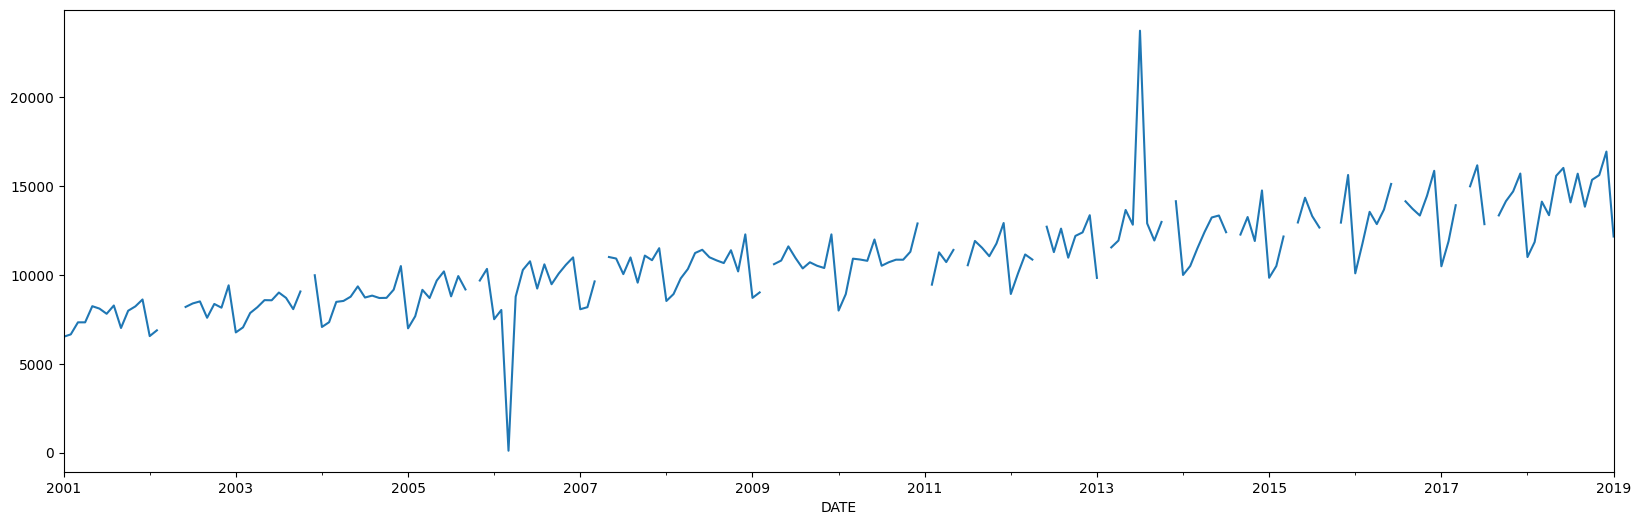

In [ ]:
mobile_sales.Sales.plot()

---

## Challenge 1: Handling missing values

So, as you can see, this is a plot that shows the monthly sales data.

Notice that there are some **missing values** in the data.






We need to
- Find where the values are missing
- Analyze if there is any pattern
- Fill them with the most appropriate value.

<br>

> **Q. How do we find the missing values?**

By now, we already know how to find missing values. We use the `isna()` method to get a sense of how many values are missing.

In [ ]:
mobile_sales.isna().sum()

Sales    19
dtype: int64

Let's try to see if there is any pattern in these 19 missing entries.

In [ ]:
mobile_sales.loc[mobile_sales.Sales.isna()]

Sales
DATE             
2002-03-01    NaN
2002-04-01    NaN
2002-05-01    NaN
2003-11-01    NaN
2005-10-01    NaN
2007-04-01    NaN
2009-03-01    NaN
2011-01-01    NaN
2011-06-01    NaN
2012-05-01    NaN
2013-02-01    NaN
2013-11-01    NaN
2014-08-01    NaN
2015-04-01    NaN
2015-09-01    NaN
2015-10-01    NaN
2016-07-01    NaN
2017-04-01    NaN
2017-08-01    NaN

There is no visible pattern.

So we can safely move forward, but if there was a pattern we would have handled that differently.

<br>

> **INTERACTION**
> - Can you suggest some ways to fill missing values? (mean, median, 0, etc)

<br>

### Imputing with Mean/Median
#### Q. How can we go about imputing the missing values?
One basic intuition is to fill these missing values with the **mean** or the **median** of the signal.

Let's look at both these values, and try filling up the missing values with them.

In [ ]:
mobile_sales.Sales.mean()

10842.757575757576

In [ ]:
mobile_sales.Sales.median()

10745.0

As you can see, both these values are similar, so we can safely assume that using either of these values to fill up the missing values would fetch similar results.

Let's try replacing missing values with the mean in this example and let's plot the same

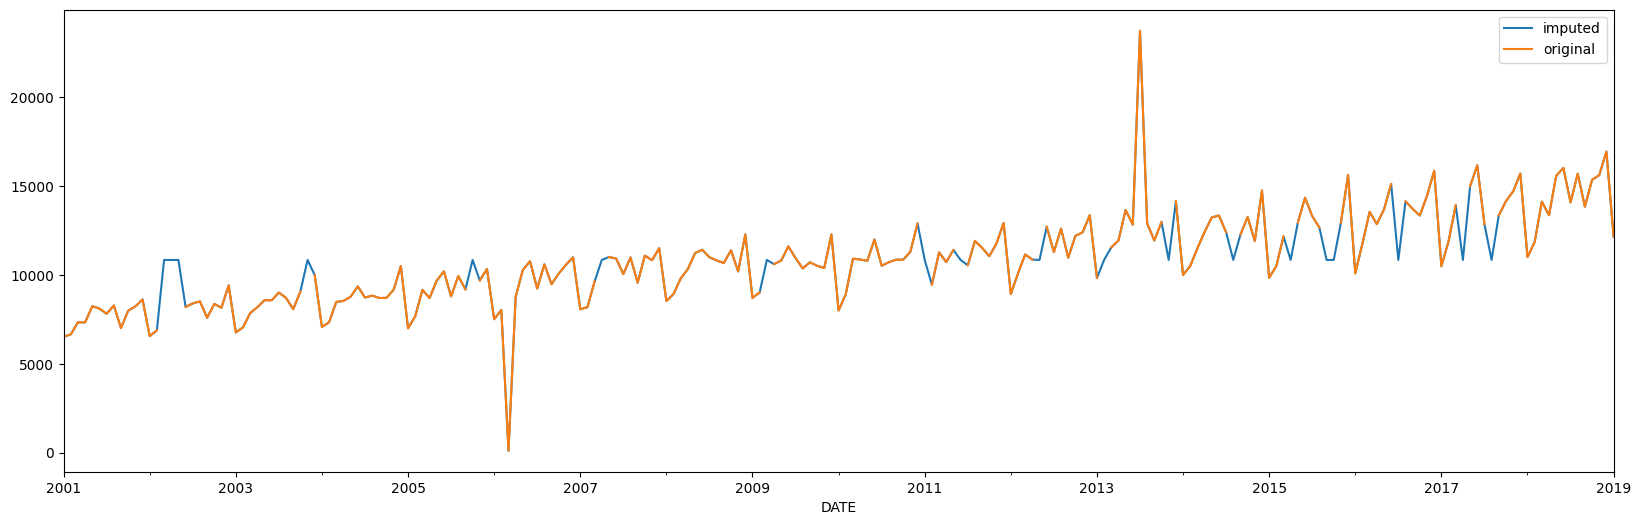

In [ ]:
mobile_sales.Sales.fillna(mobile_sales.Sales.mean()).plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

### Imputing with 0

> **Q. What if we impute by replacing the missing values with 0?**

**That doesn't make sense for this time series.**

The monthly sales of a mobile phone would not just drop to 0 on random months.

**But in many cases, this works very well.**

A lot of times, time series can be at a daily level, and it can happen that the sales for particular days is 0, owing to the store being closed on public holidays, or Sundays.

In industry, in order to do that, we need to first check in with the client who owns that data, to cross-check first without making assumptions.

This is very common practice.


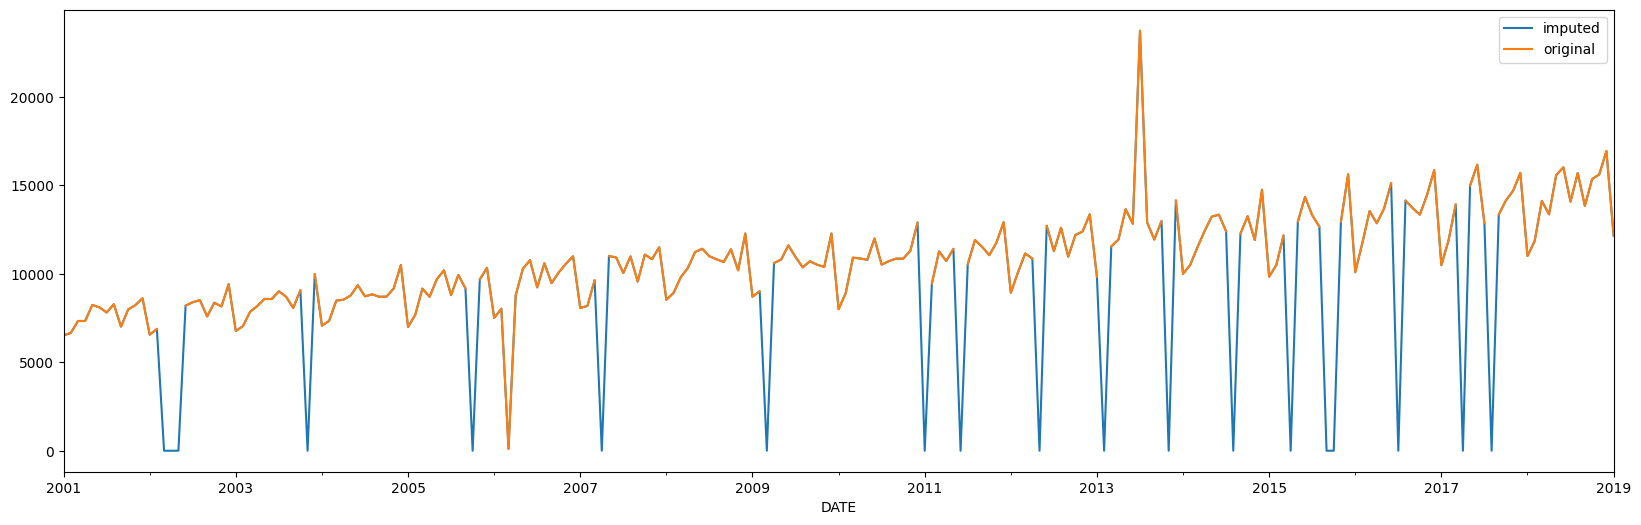

In [ ]:
mobile_sales.Sales.fillna(0).plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

### Interpolation

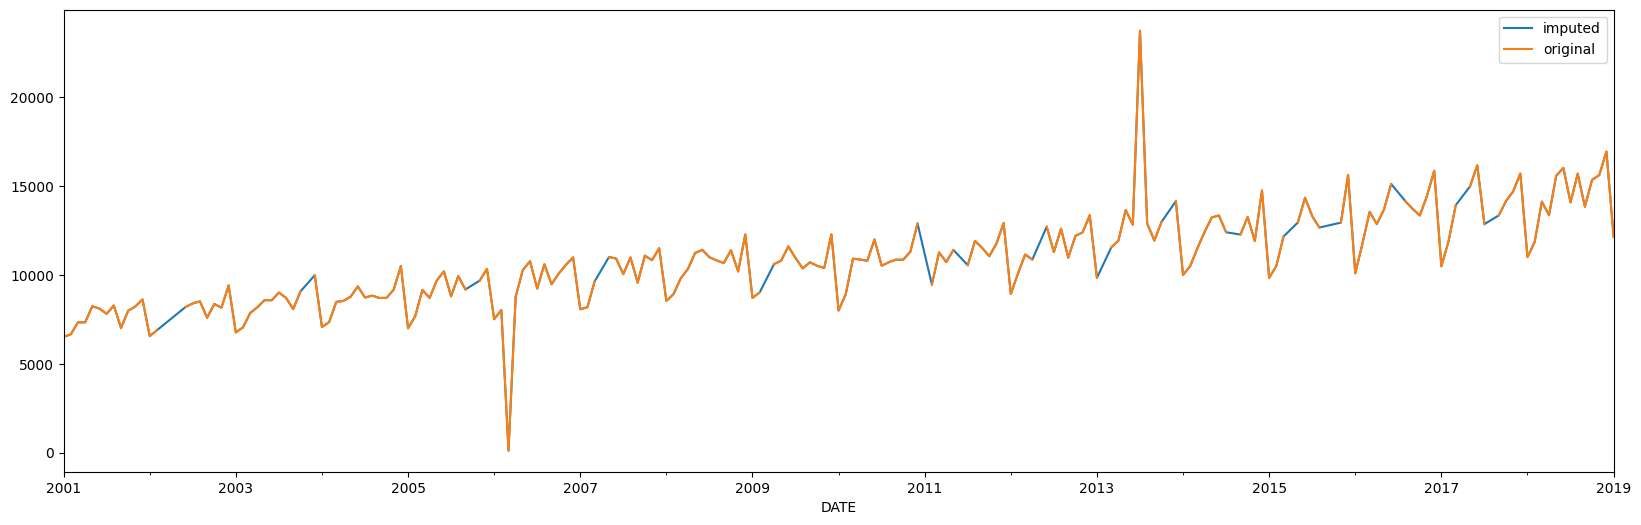

In [ ]:
mobile_sales.Sales.interpolate(method='linear').plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()


This looks better than the previous plot.

The imputed values don't seem to be forced.

We're essentially joining the first point before and first point after the missing values with a **straight line** in the plot.

**Other types of interpolations**

Besides linear, there exist other types of interpolation, some of them are:-
- `pad`: Fill in NaN using existing values
- `polynomial`: You need to specify an **order**

In [ ]:
# Let's save this interpolated signal

mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

---

## Challenge 2: Anomalies

Lets look at the other issue in our data

> **Q. What is an anomaly in context to time series?**

Anomaly/outlier is an **abnormal or unsual data point** in the data set, which stands out of the data.

It can simply be seen as a **wrong entry** in the data, and that can happen at times.

Alternatively, it could be the correct entry but for a **one time event**, which is  not likely to repeat in future.

If it's a one time event, it's not going to repeat in the future, or at least, we cannot predict it getting repeated in the future.

So, even if it's a valid data, we would like to remove it from our training set, because we don't want our model to get biased by that one time event that is not going to happen again.

<br>

> **Q. What are the anomalies in our dataset?**

1. In Feb 2006 of our time series, we see a drastic dip.
 - There was probably no data for that month,
 - So owing to a different data engineering process, it got filled by 0
 - Giving us an anomaly.

2. Similarly, in mid 2013, we see an abnormal spike.
 - Even if this is correct data for that period, we want to remove it.
 - That is another anomaly in our data.




> **INTERACTION**
- Now that we've estalished that we have anomalies in our series, how can we remove them?
### Replacing with NaN

> **Q. What if we replace the points of anomaly with NaN?**

This does not work very well.

If we replace sales value by NaN, then for that date, we would not have any data. The model would not know what happened that month.

<br>

> **Q. Why is not having data for specific entries a problem?**

Most of our forecasting methods, as you'll see, rely on the time steps being equally spaced.

If we have a missing time step, the formula would still work, but we'd get an incorrect answer.

<br>


### Lets visualise our data to identify the outliers

One of the best way to identify the anomalies are by plotting **Histogram**

Let's plot one for our dataset

[]

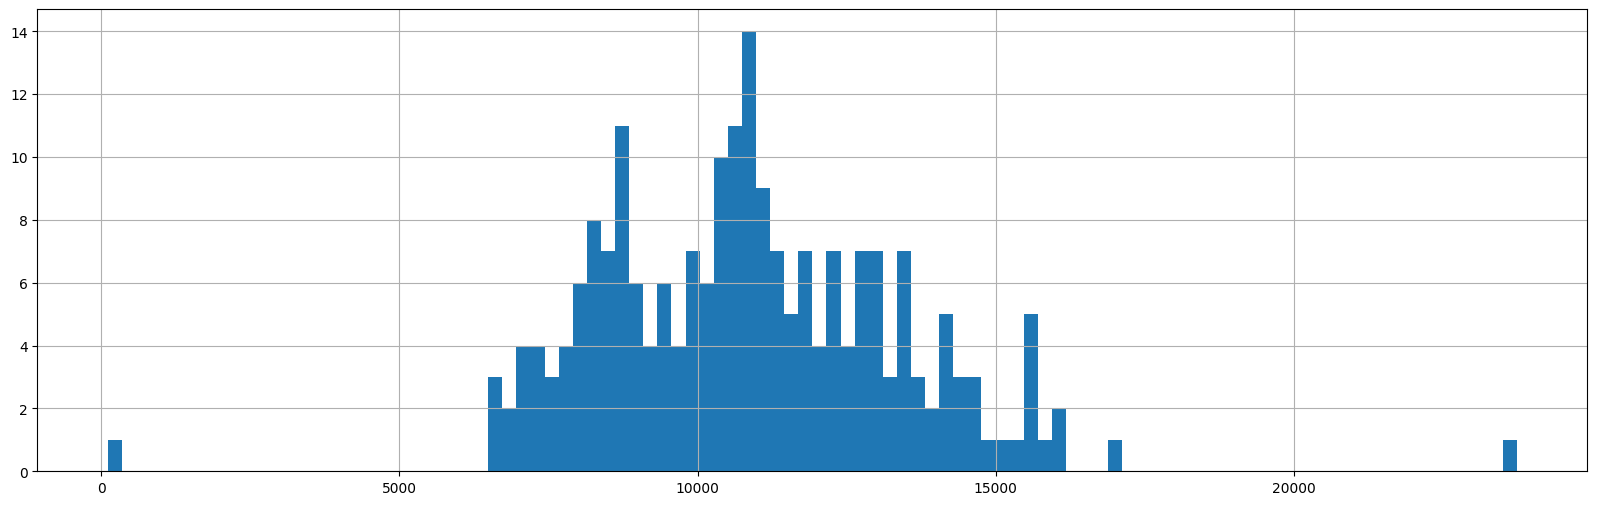

In [ ]:
mobile_sales.Sales.hist(bins=100).plot()

From the plot, we can clearly see the anomalies.

We can easily decide where to cut the data, in order to get rid of anomalies.
* For instance, We can replace all the $values < 5000$ by 5000 and all the $values > 20,000$ by 20,000

<br>

> **Q. But what would we do if this histogram plot was more continuous?**

Then we would not know where to cut the data.

<br>


### Using Quantiles
> **Q. What if we use the concept of quantiles to help deal with anomalies?**

This seems promising. Lets see how we'll go about it.

First lets describe the data to see the quantiles.

In [ ]:
mobile_sales.Sales.describe()

count      217.000000
mean     10873.046083
std       2571.620954
min        108.000000
25%       8923.000000
50%      10793.000000
75%      12555.500000
max      23740.000000
Name: Sales, dtype: float64

In [ ]:
mobile_sales.Sales.quantile(0.95)

15164.599999999997

This means that 95% of the values in our signal are less than 15,164.6, or that only 5% values are higher than this value.

Similarly, lets find the value for 5 percentile

In [ ]:
mobile_sales.Sales.quantile(0.05)

7307.8

This means that only 5% of the values in our signal are less than 7307.8, or that about 95% values are higher than this value.

Using these values, we can cap them as the maximum and the minimum values of our series, respectively.

One way to do that using the `loc` method, as we have been doing till now.

Alternatively, we can utilise the `clip()` method in pandas. We need to assign values to parameters **upper** and **lower** to specify where to clip.

Lets look at a plot for the same as well.

<Axes: xlabel='DATE'>

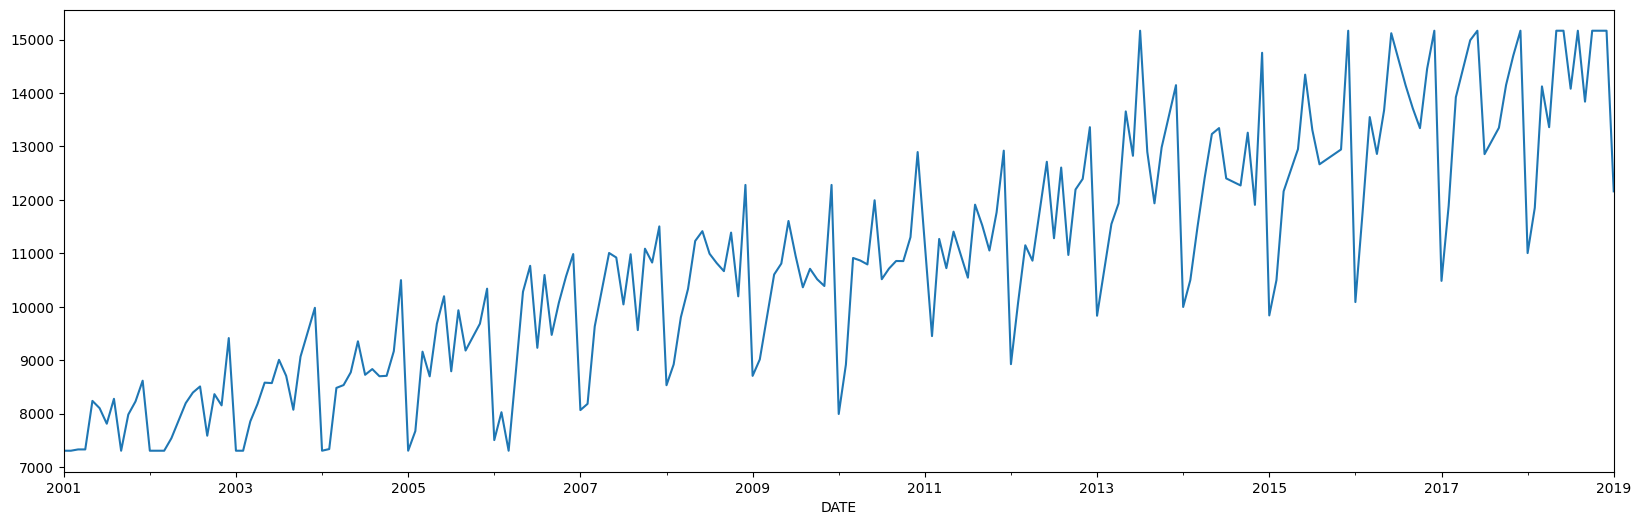

In [ ]:
mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.95), lower=mobile_sales.Sales.quantile(0.05)).plot()

Notice that the scale for plot has changed now that outliers have been removed.

But as you can see in the beginning as well as in the end, some important values are also getting clipped.

> **Q. How do we solve the problem of useful data getting clipped?**

Let's change the percentiles that we're clipping on. - [98, 2]


**NOTE:**
- Try to keep the quantiles symmetric, if there's no reason to keep them non-symmteric.
- This means that if you're updating the upper bound as we did here, then update the lower bound accordingly.

<Axes: xlabel='DATE'>

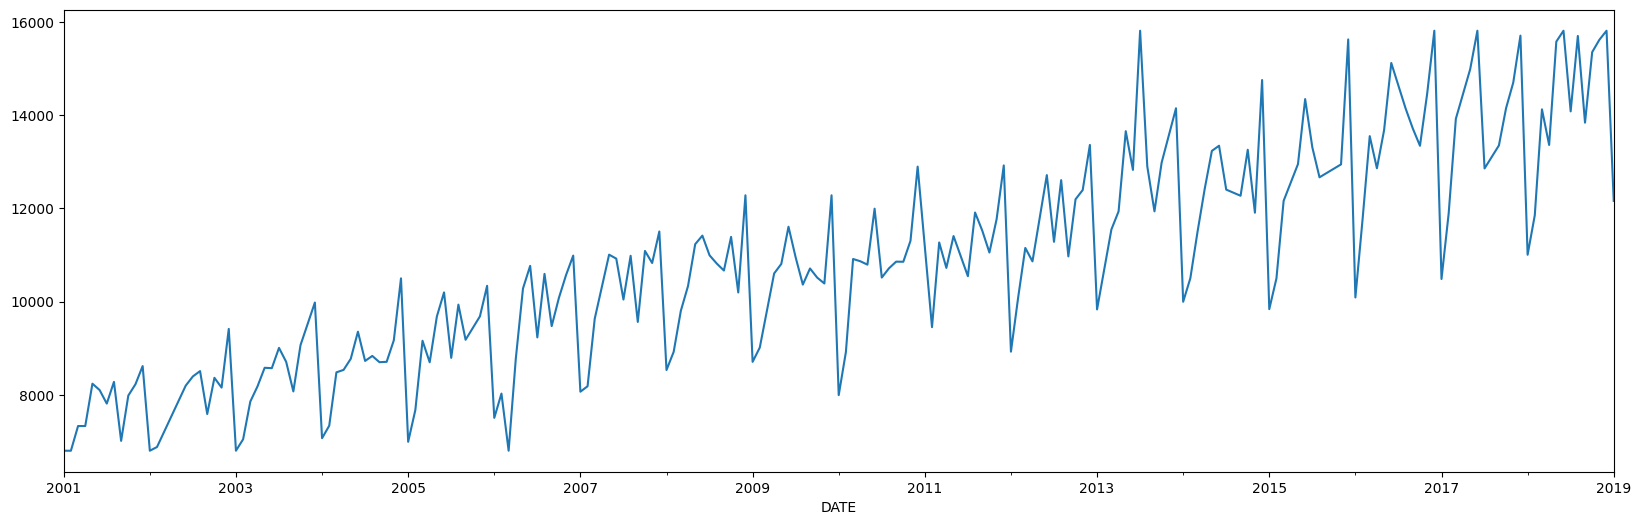

In [ ]:
mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02)).plot()

In [ ]:
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

---

## Task-1: Breaking down a time series


**Lets look at the Agenda 1 of our business case: Analyse and understand any patterns in the data**

Let's plot the same graph, just to have a look

<Axes: xlabel='DATE'>

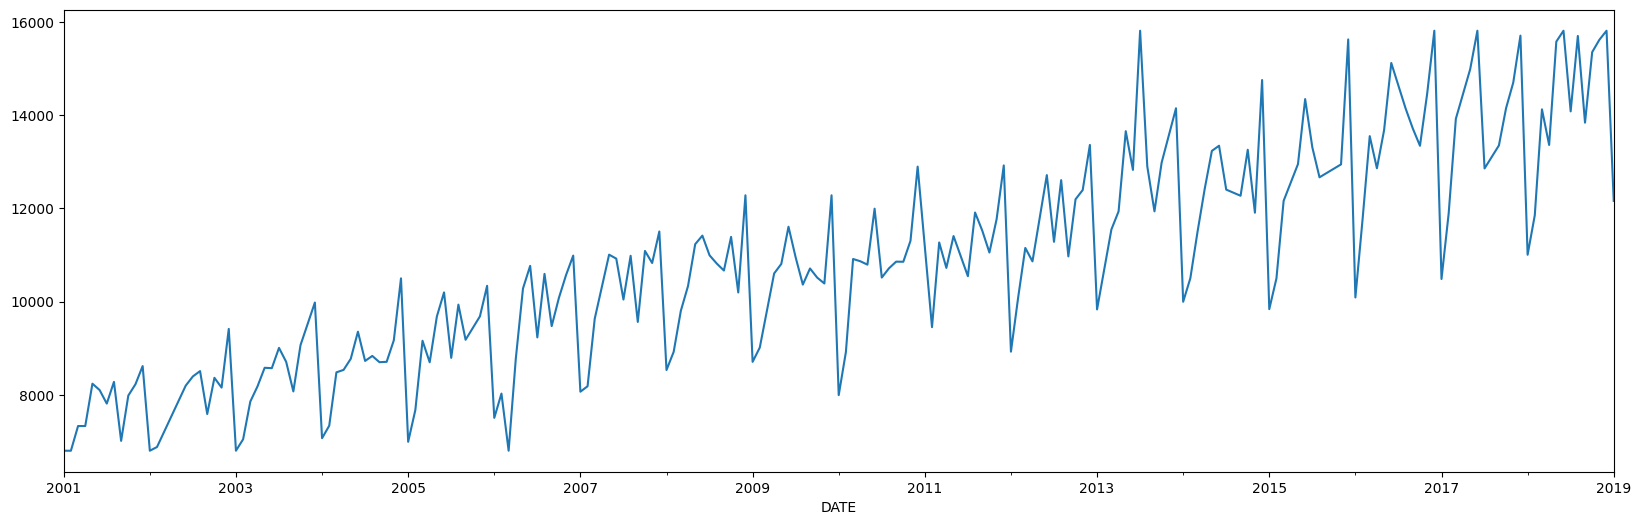

In [ ]:
mobile_sales.Sales.plot()

> **Can we seperate out trend and seasonality? Any Ideas?**

For that let us look at a new concept called **Moving Averages**

## Moving Averages


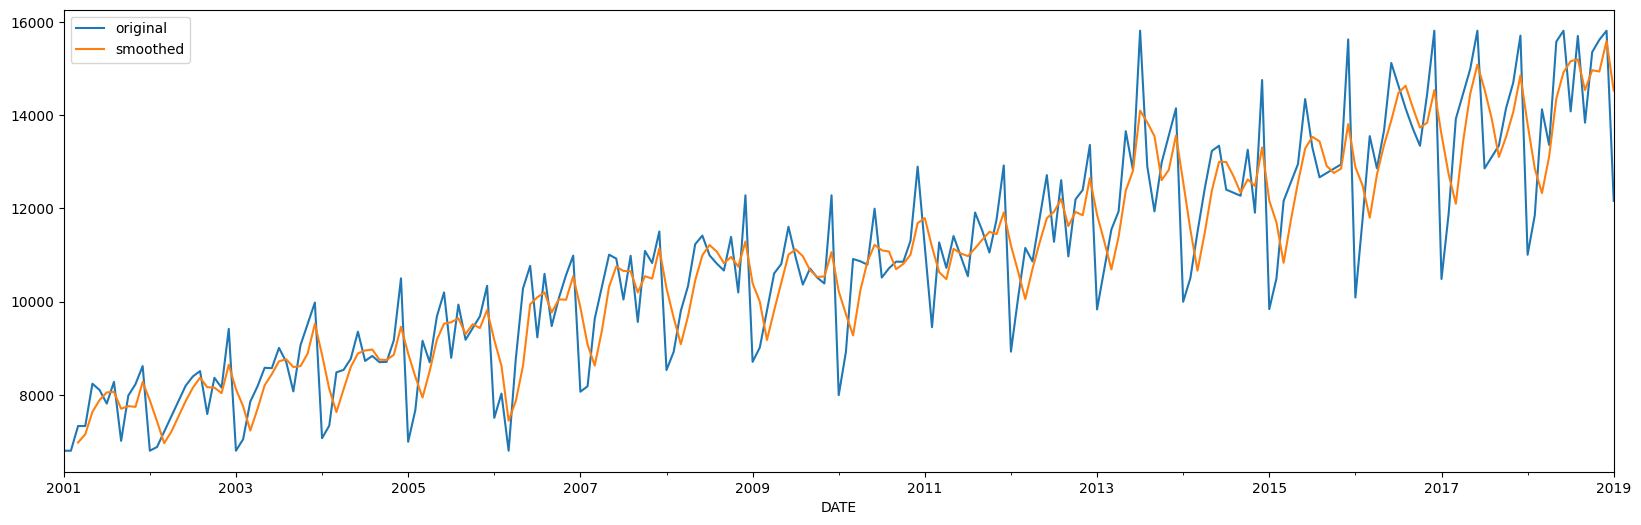

In [ ]:
# Plot original data
mobile_sales.Sales.plot(label='original')

# Plot data after implementing Moving Averages
mobile_sales.Sales.rolling(3, center=False).mean().plot(label='smoothed')

plt.legend()

> **Q. What observations can we make from this plot?**

- We can see that the smoothed series is **lagging**.
- Notice that both maximas and minimas are lagging by 3 units along x axis. This is because our rolling window was 3.
 - Benefit of this is, if the time series value changes suddenly, the smoothed series would change a few days/weeks/months later.
 - Thereby, adjusting to the new level.
- **Less-spikey**
- Notice that there are some **missing values in the beginning**
 - This makes sense, since our `window size=3`, the very first MA value we can get is after 3 data points.

<br>

> **Q. What if we take window size = 1?**

In this case, the smoothed series should be exactly same as the original time series.

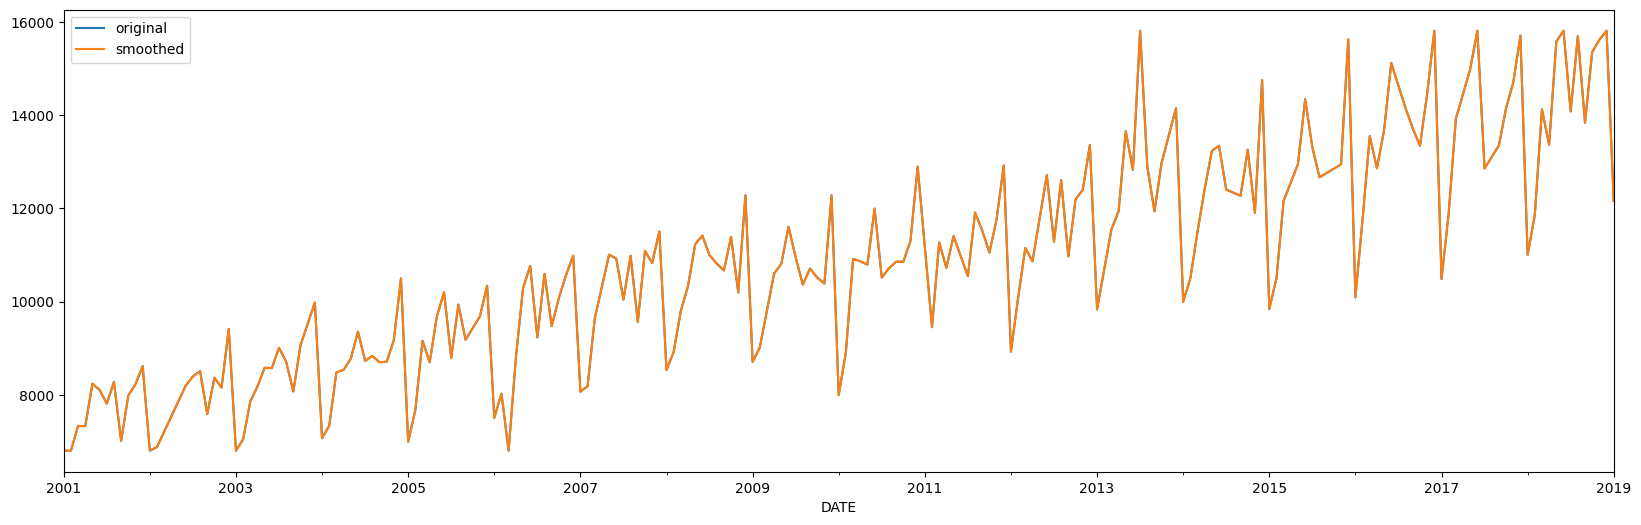

In [ ]:
# Plot original data
mobile_sales.Sales.plot(label='original')

# Plot data after implementing Moving Averages
mobile_sales.Sales.rolling(1, center=False).mean().plot(label='smoothed')

plt.legend()

> **Q. What would happen if we take a higher window size value?**

- It would go through the center.

- The results would be **much less noisy** in nature.
- We would be missing 12 values from the beginning of MA plot line

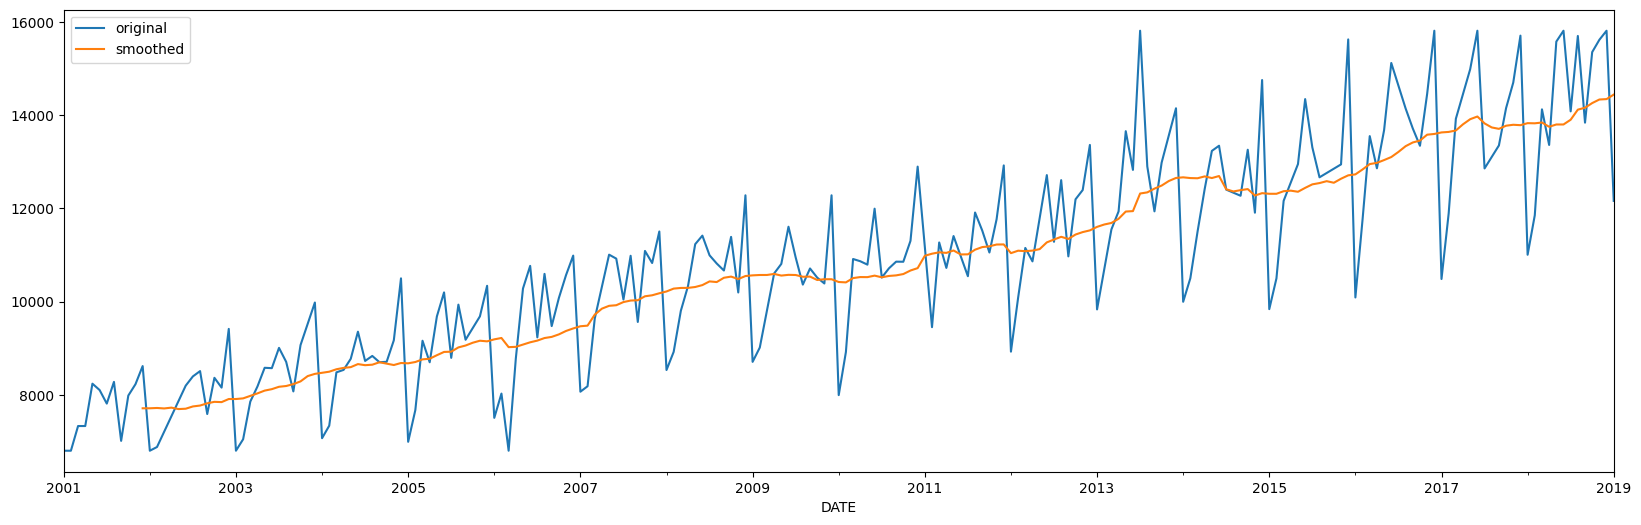

In [ ]:
# Plot original data
mobile_sales.Sales.plot(label='original')

# Plot data after implementing Moving Averages
mobile_sales.Sales.rolling(12, center=False).mean().plot(label='smoothed')

plt.legend()

### Centered Moving Average

#### As we discussed earlier, we can use this approach of Centred Moving Average to
- deal with missing values
- deal with anomalies in time series data.

Let's see how it works

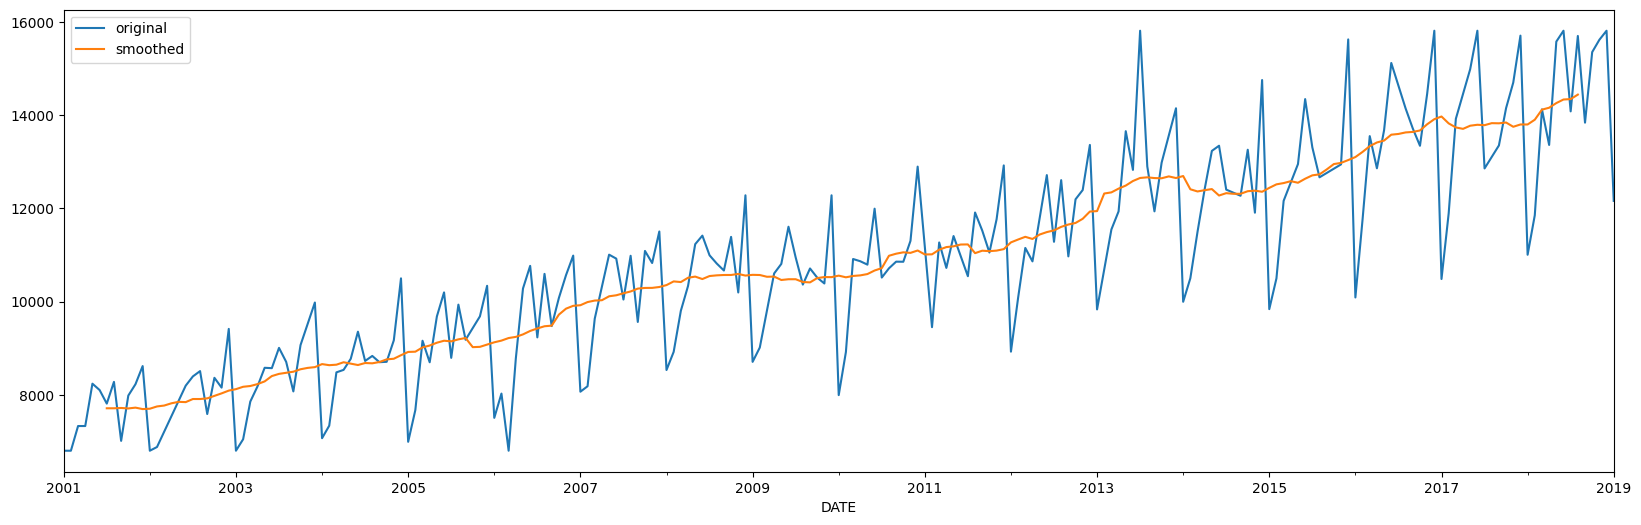

In [ ]:
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12, center=True).mean().plot(label='smoothed')
plt.legend()

> **Q. What observations can we make from the plot?**

Notice that some values are missing in the beginning and in the end.

We're missing 6 entries in both beginning and in end to be precise, since the window size is 12.

<br>

> **Q. What if we put `center=False` inside the rolling method?**

In that case, we would find that we're missing all 12 values in the beginning, and none in the end.



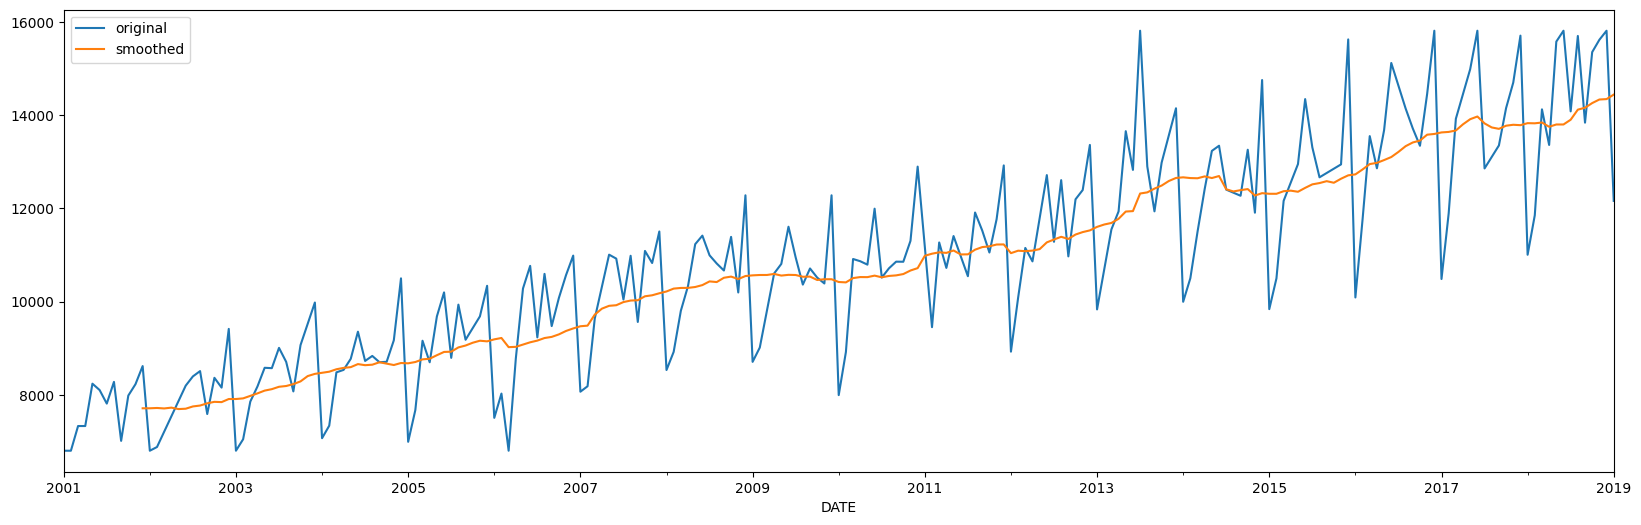

In [ ]:
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12, center=False).mean().plot(label='smoothed')
plt.legend()

---

## Trend



This is nothing but smoothing the original time series. We Have chosen to take centered moving average to represent trend this choice can be subjective

You can take period to be 1 year or 2 years. It should be big enough to remove (smooth) all the other factors such as noise / seasoanlity / etc.

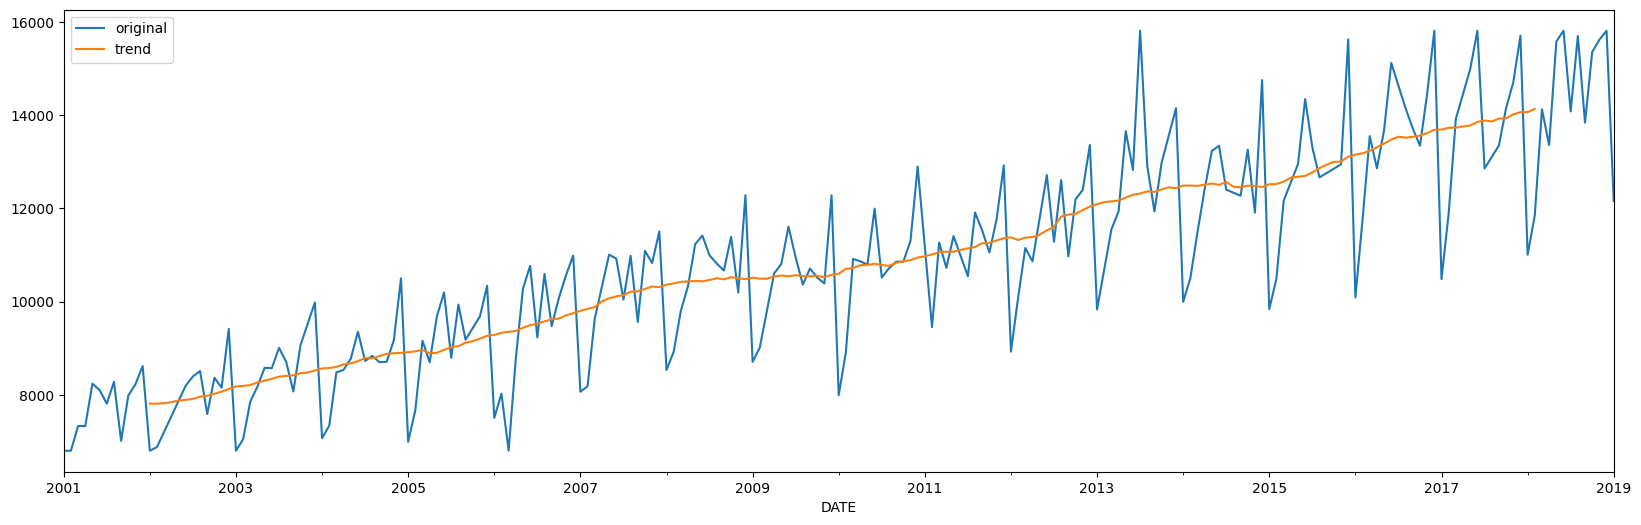

In [ ]:
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(24, center=True).mean().plot(label='trend')

plt.legend()

---

## Seasonality

In [ ]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

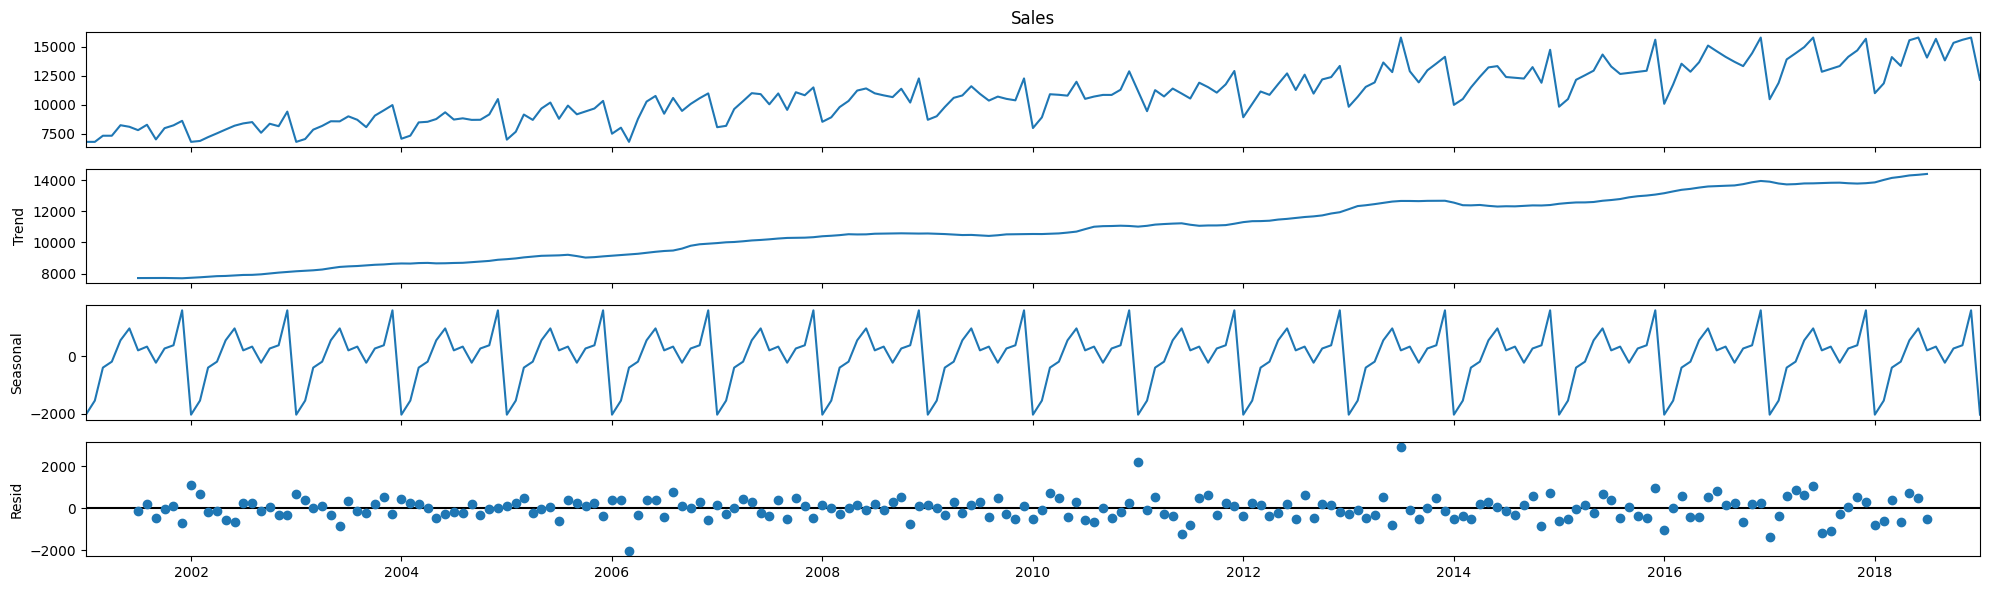

In [ ]:
# By default, we get the plot twice with this functionality
# We add ; to avoid seeing the plot

model.plot();

This plot is divided in 4 sections
1. The actual time series data
2. Trend
 - Notice the missing values in beginnning and end
 - Even statsmodel has used centered approach to calculate moving average
3. Seasonality
 - We can see that the exact same pattern is getting repeated every year.
 - This was obtained by subtracting trend from real series, and taking average over every month.
4. Residual values

<br>


Coming back to the additive model, lets take a look at the residuals plot only.

> **Q. How can we retrieve ONLY the residual plot from the model?**

We can simply use `resid` keyword to access residual values from the model, and then plot it.

<Axes: xlabel='DATE'>

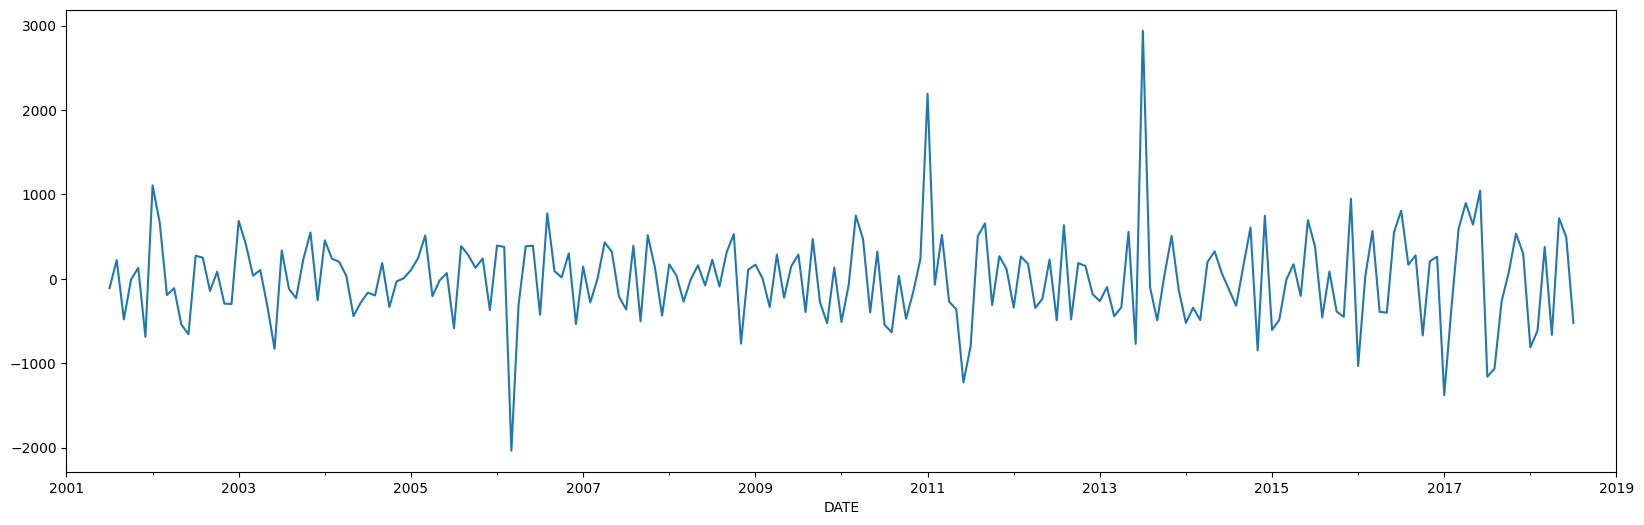

In [ ]:
model.resid.plot()

You may think that this is a new time series, and then might want to forecast for this as well.
- But notice the minimum and maximum errors we're getting here (-2000 and 3000 respectively). **Scale of the residuals is ~5% of the actuals**

> **Q. How can we check if this error is symmetric?**

We can plot a histogram for residuals, to understand the distribution of these values.

<Axes: >

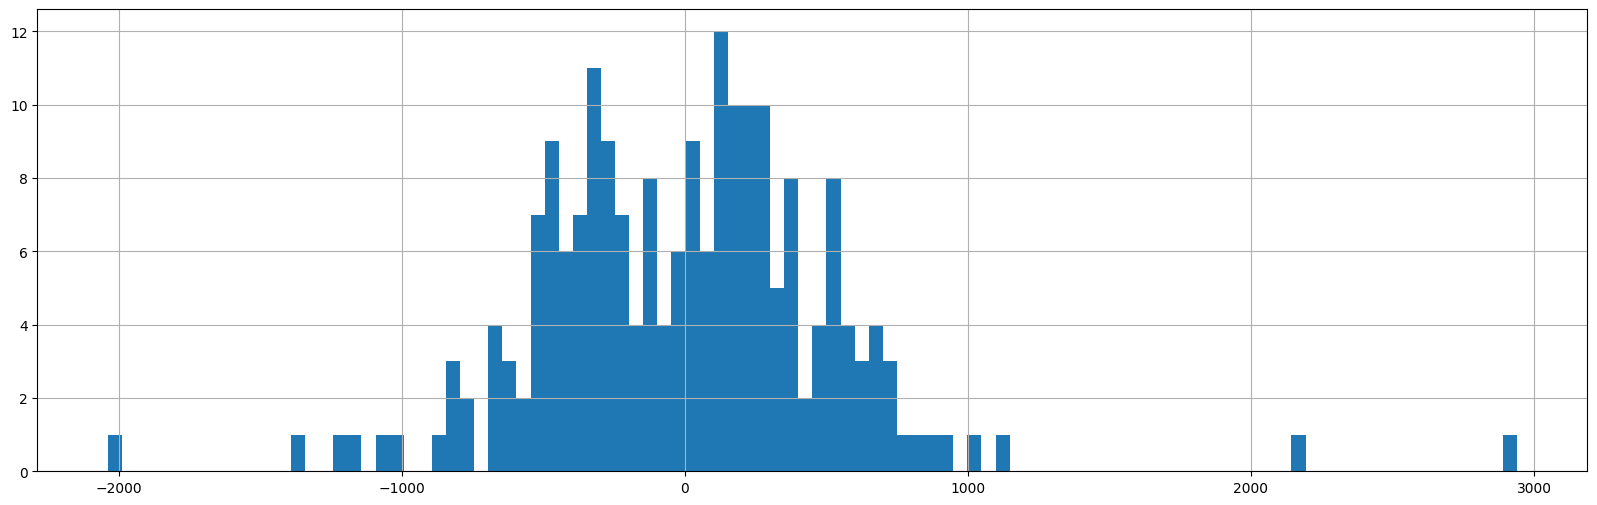

In [ ]:
model.resid.hist(bins=100)

This still doesn't look perfectly symmetric

> **Q. How do we know when to not take further forecast of the residuals?**

We can stop the forecasting of the residual once your residual mean is close to zero.

Let's check this value for our usecase.


In [ ]:
model.resid.mean()


-3.2316417029771514

In a data with values ranging from -2000 to 3000, a residual mean of -3.2 is very close to zero.

So we are neither overforecasting nor underforecasting.

### Decomposition from Scratch

**Trend_temp**

<Axes: xlabel='DATE'>

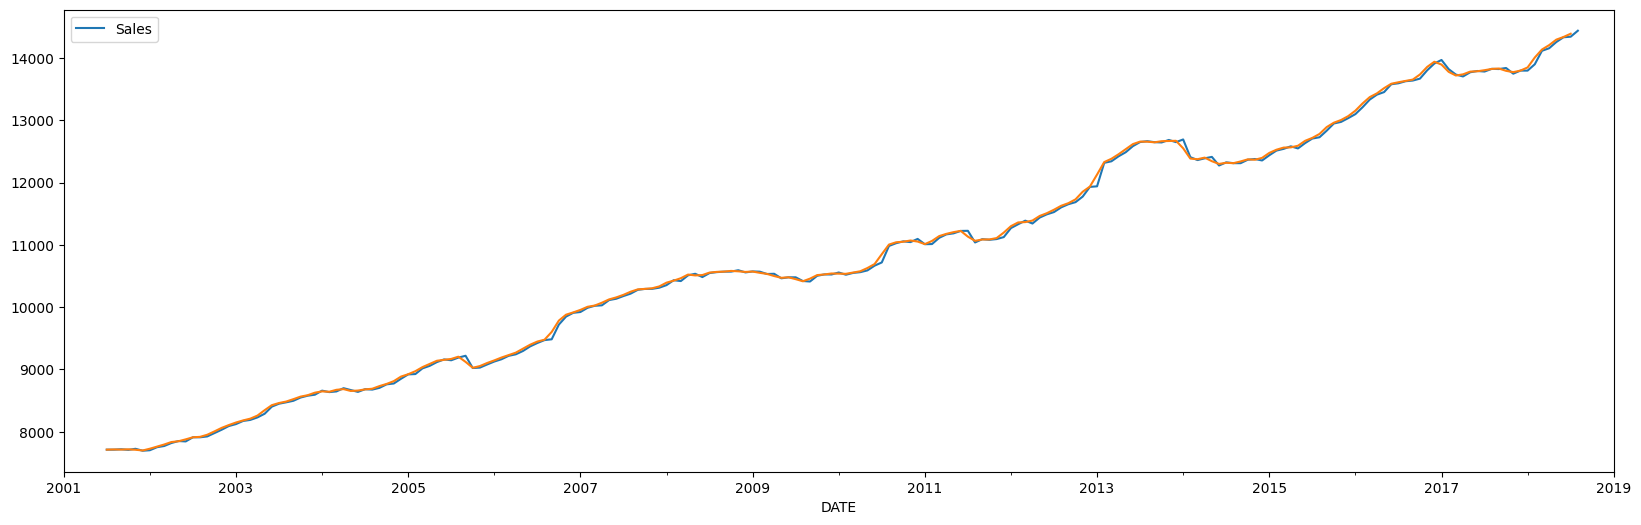

In [ ]:
trend = mobile_sales.rolling(12, center=True).mean()
trend.plot()
model.trend.plot()

<Axes: xlabel='DATE'>

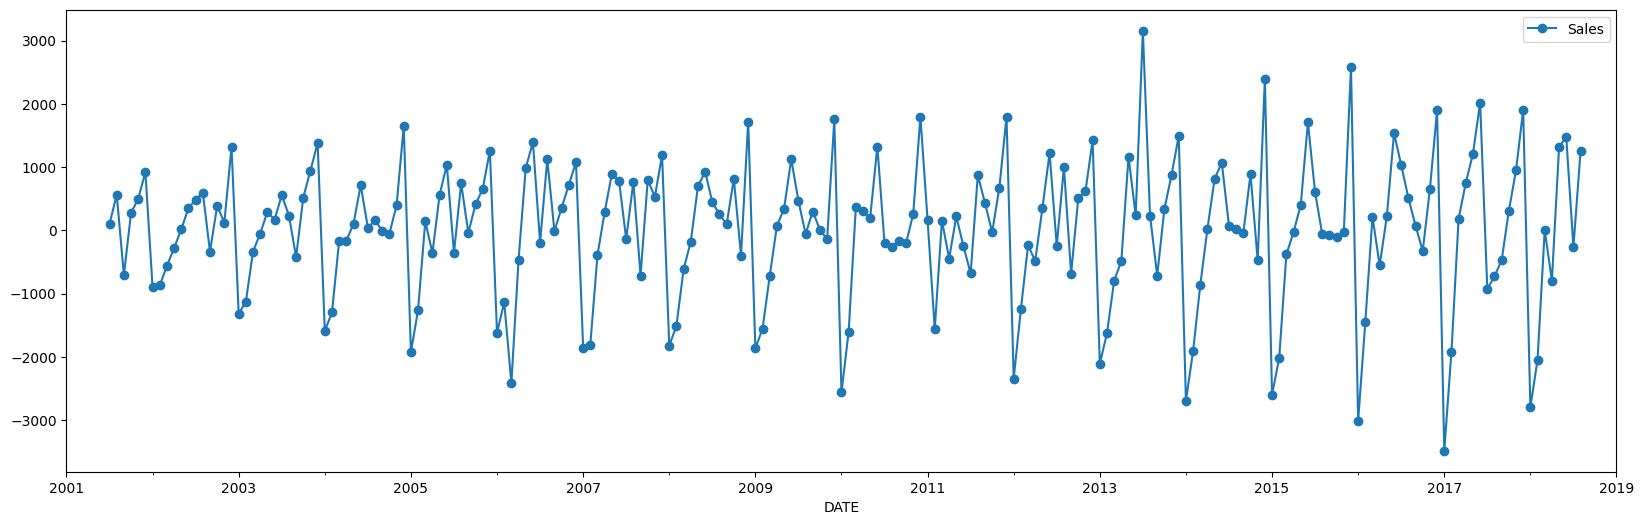

In [ ]:
de_trend = mobile_sales - trend
de_trend.plot(style='-o')

<Axes: xlabel='DATE'>

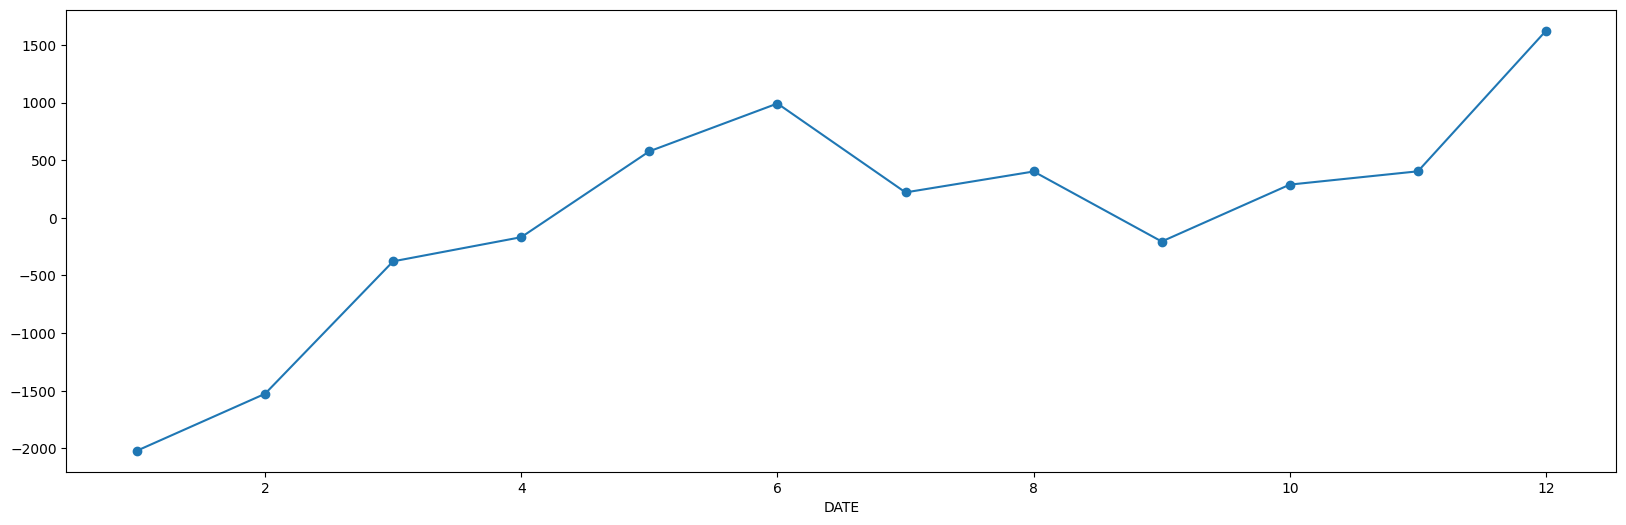

In [ ]:
dtf = de_trend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

<Axes: xlabel='DATE'>

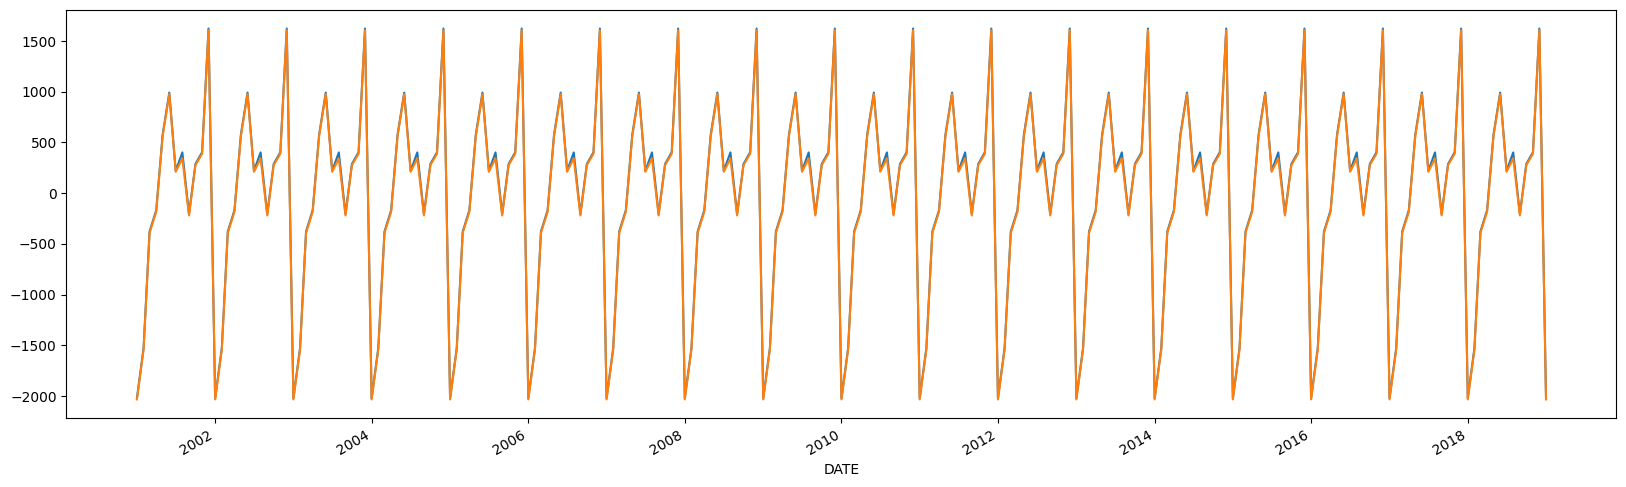

In [ ]:
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'))
model.seasonal.plot()

<Axes: >

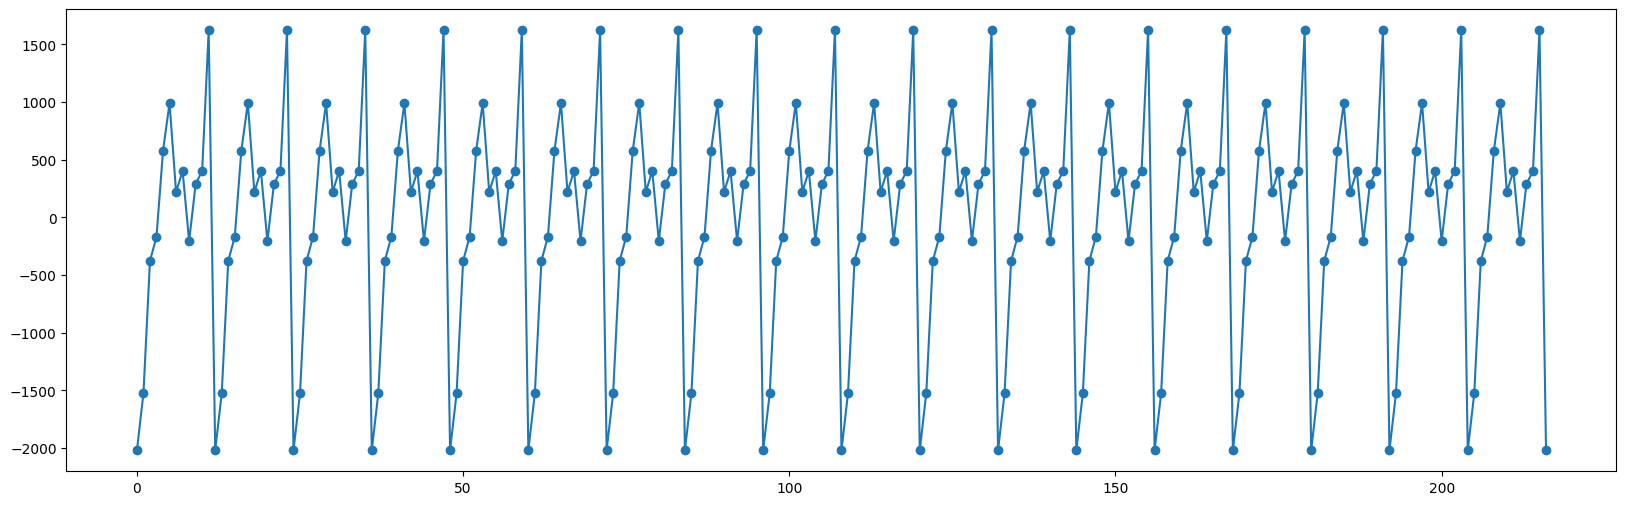

In [ ]:
dtf['season'] = dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean')
dtf['season'].plot(style='-o')

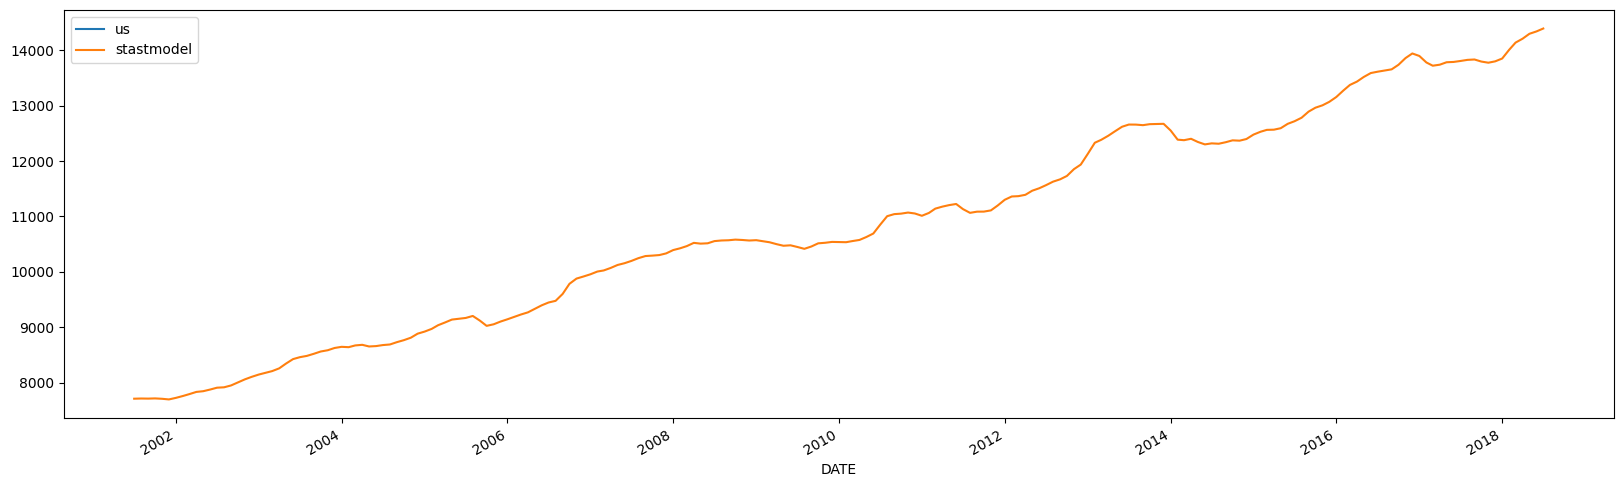

In [ ]:
trend_2 = pd.Series((mobile_sales.values[:, 0] - dtf['season']).rolling(12, center=True).mean(), index=model.trend.index)
plt.plot(trend_2, label='us')
model.trend.plot(label='stastmodel')
plt.legend()

## Task-2: Generating Forecasts

**Lets tackle the Agenda 2 of our buisness case: Make future forecasts, with a MAPE score not more than 5%.**

We would need to see a few things before we can begin
- What is MAPE
- How to do train-test splits for time series


### Mean Absolute Percentage Error (MAPE)

To get the percentage error values we use **Mean Absolute Percentage Error** (MAPE), which is obtained by dividing the absolute error with actual value and finding the mean of these terms.

Formula:


<center><h3> $MAPE = \frac{1}{N} \sum_{i=1}^{N}\left | \frac{y_{i}-\hat{y}_{i}}{y_i} \right |$</h3></center>



> **Q. What is advantage of of using MAPE  as business case metric?**

As opposed to other metrics used for time series (ME, MAE, MSE, RMSE), MAPE doesn't provide relative comparison of models. It is an absolute comparison.

With MAPE, we get an percentage of correct forecasts. We don't need to to look at MAPE values of other models to get an idea of how our model is performing in comparison.

<br>

> **Q. What if y = 0 for a point?**

That would be a problem as MAPE would become **undefined** for the entire data that way.

Therefore, one would have to use another metric for the points where real value is 0. This is just inconvenient.


---

### Train Test Splits

In [ ]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

Sales
DATE               
2018-02-01  11852.0
2018-03-01  14123.0
2018-04-01  13360.0
2018-05-01  15576.0
2018-06-01  15809.4
2018-07-01  14080.0
2018-08-01  15697.0
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  15809.4
2019-01-01  12160.0

> **Q. Where is the `train_y` and `test_y`?**

Recall that in our dataset, we have only one column of data i.e. the sales column.

Besides sales, there is no other data.

We only have dates (time) that we're using as index.

So, we cannot create a y column, if there are no columns.

Also, let's create a function  to estimate the performance of different models

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

## Simple Forecast Methods

Lets take a look at a few fundamental (not-so-intelligent) approaches

### 1. Forecasting the mean

In [ ]:
train_x['Sales'].mean()

10653.201951219511

MAE : 3786.031
RMSE : 4025.906
MAPE: 0.255


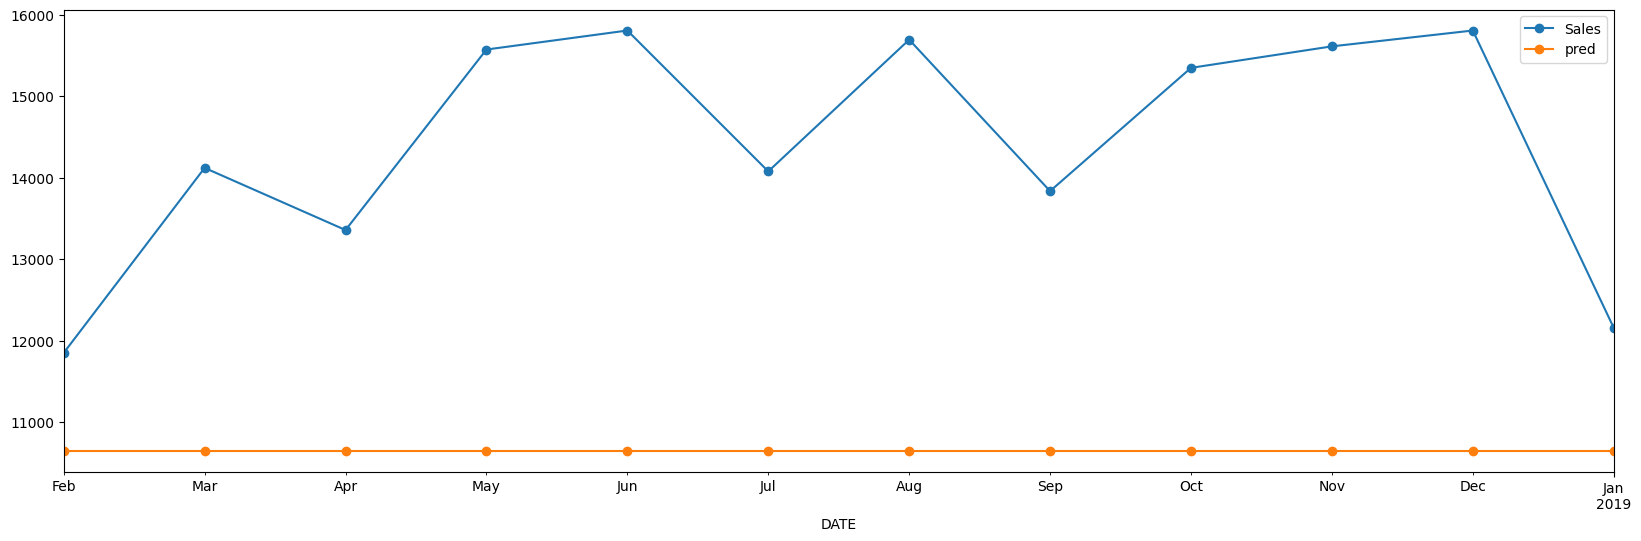

In [ ]:
test_x['pred'] = train_x['Sales'].mean()

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

It is evident that this a very bad model.

> **Q. How do we interpret the MAE score?**

This is mostly used in cases where we need to **compare multiple models.**

In such a case, we can say how well each model is performing, based on which model fetches the lowest MAE.

In this case, we can interpret it as, given that the model's values fluctuate between roughly 6k to 16k, and within those fluctuations, this model's error is around 3.7k approx.

The mean of data is approx 10k, and we're getting an MAE of 3.7k, this means roughly 37% predictions are wrong, **with respect to the mean**.

This is not good.

<br>

> **Q. How do we interpret the RMSE score?**

This value also, we're getting around 4k, which is close to the MAE

This metric is also used to **compare** performance among different models.

This value also doesn't seem to be good.

<br>

> **Q. How do we interpret the MAPE score?**

This is straightforward to intrpret.

For this model, we get MAPE as 0.255. This means that we have 25.5% error, **with respect to its own value**.

Lets look at some other way to forecast future values
### 2. Naive Approach


In [ ]:
train_x['Sales'][-1]

11005.0

MAE : 3434.233
RMSE : 3697.005
MAPE: 0.23


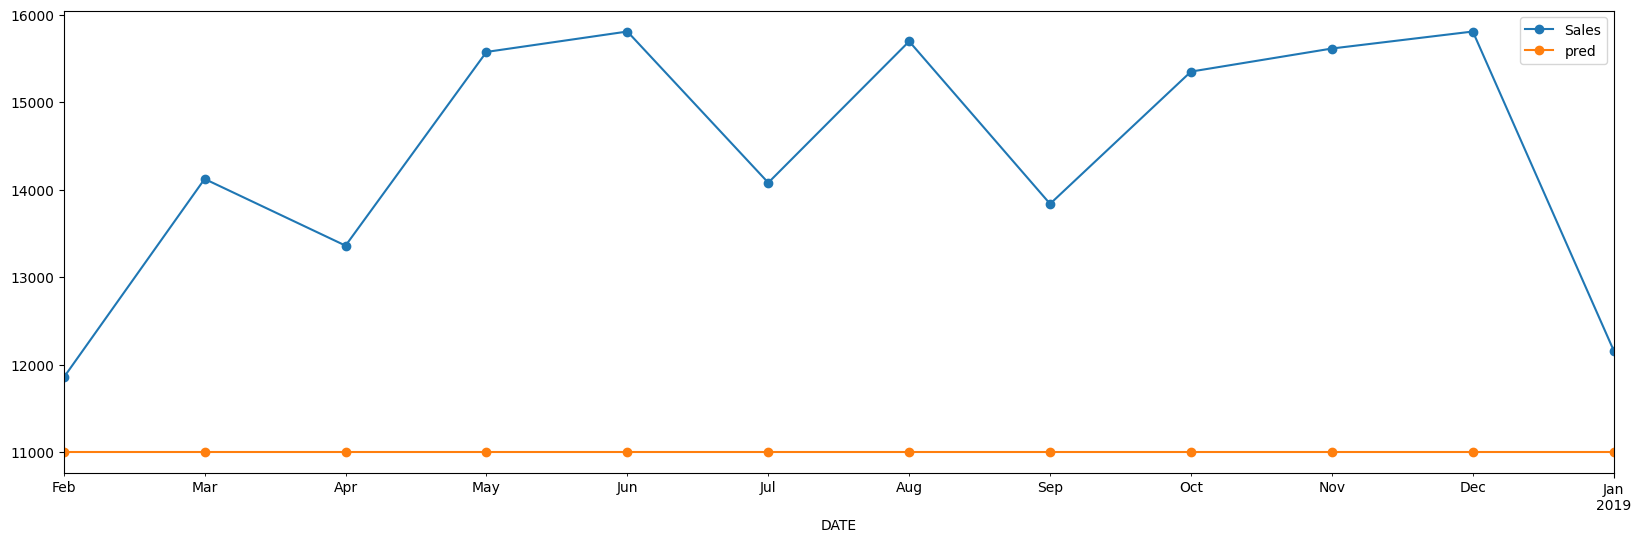

In [ ]:
test_x['pred'] = train_x['Sales'][-1]

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

This model's performance is slighly better, but we can see it's still really bad.

---

### 3. Seasonal Naive Forecast

MAE : 800.867
RMSE : 1067.837
MAPE: 0.055


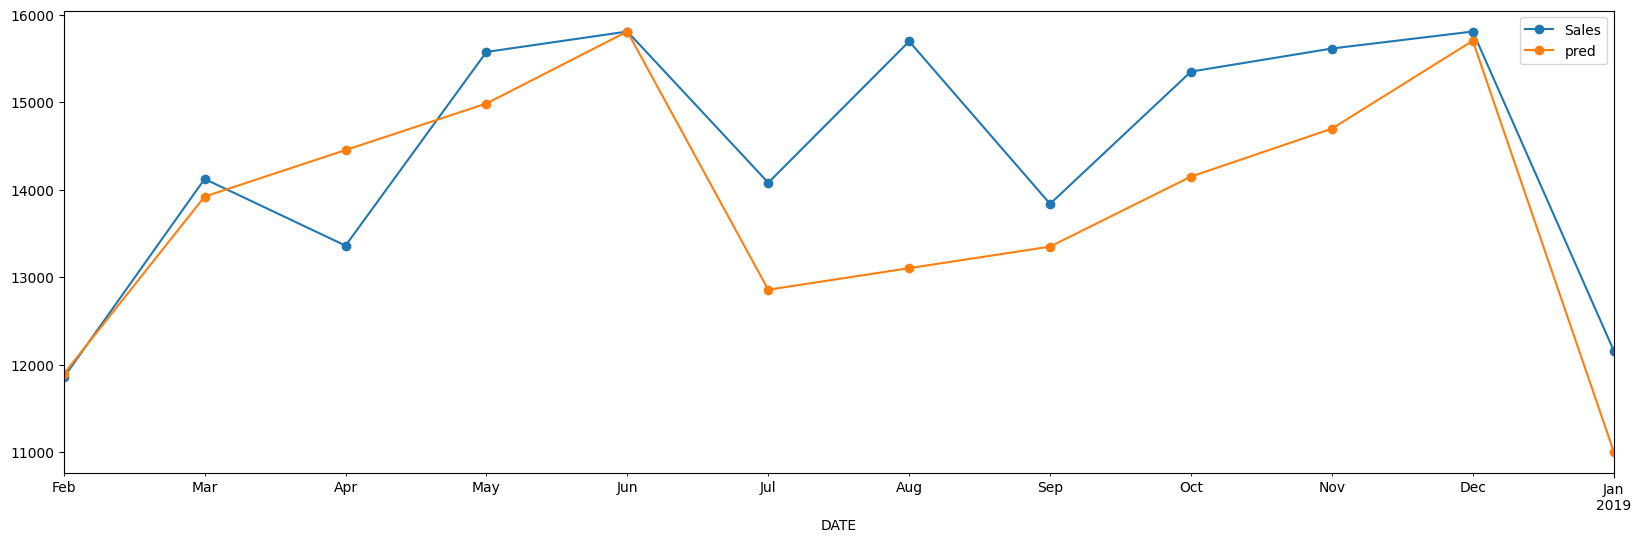

In [ ]:
for i in test_x.index:
  test_x.loc[i]['pred'] = train_x.loc[i - pd.DateOffset(years=1)]['Sales']

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

---

### 4. Drift Method

MAE : 3321.482
RMSE : 3586.323
MAPE: 0.223


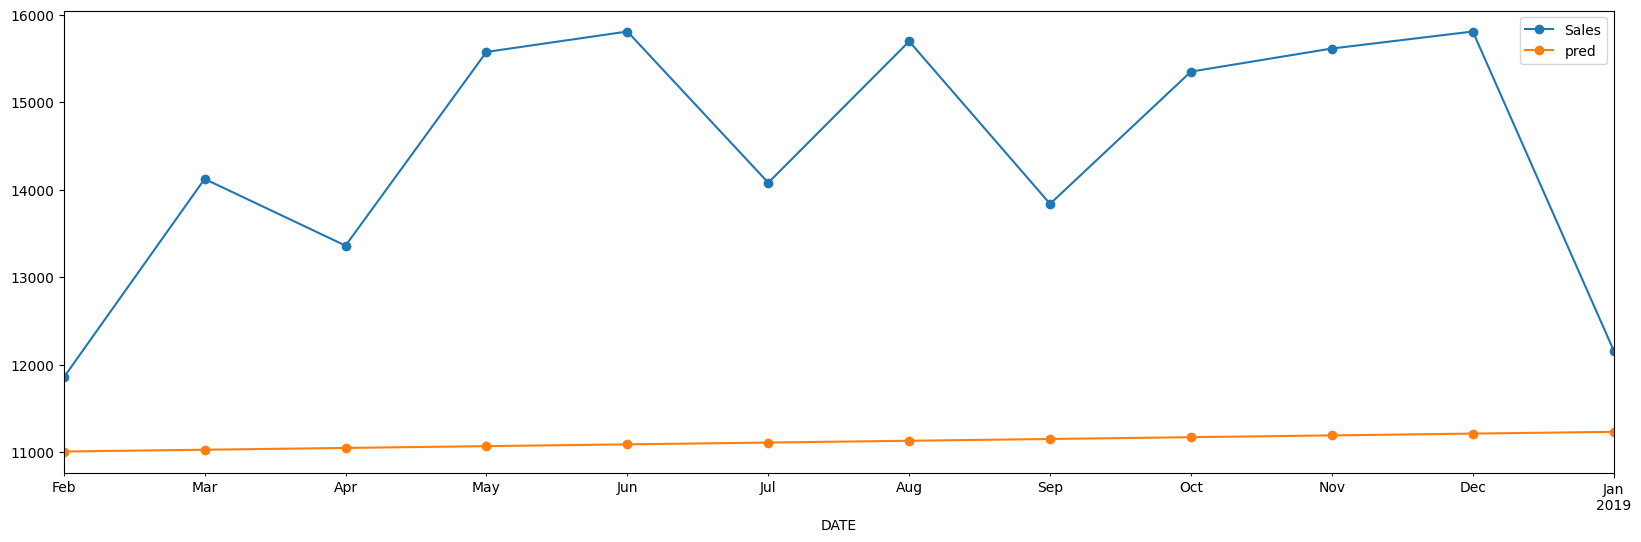

In [ ]:
# Get the slope
y_t = train_x['Sales'][-1]
m = (y_t - train_x['Sales'][0]) / len(train_x)
h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

We can see there is a drift present in our forecasts. Also, this is highly sesitive to the last value available. For example, see the following

MAE : 1503.589
RMSE : 2013.071
MAPE: 0.115


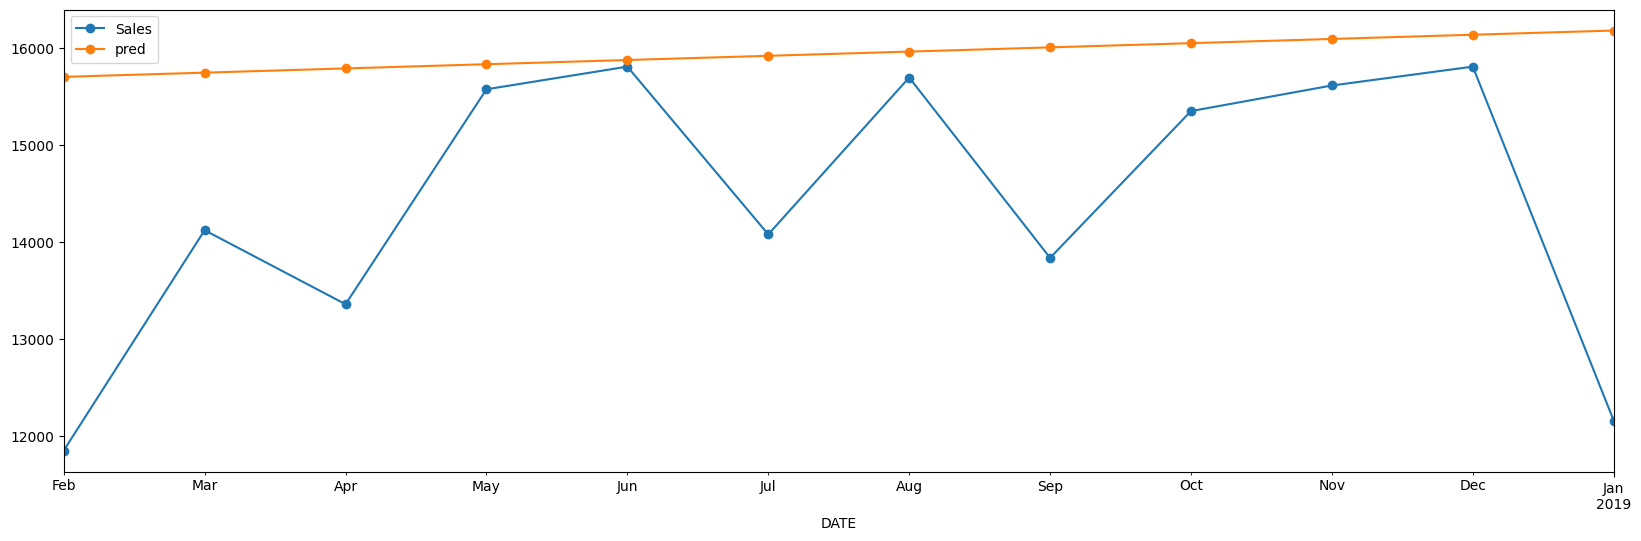

In [ ]:
# Get the slope
y_t = train_x['Sales'][-2]
m = (y_t - train_x['Sales'][0]) / len(train_x)
h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

These simple models are not exactly giving any smart forecasts.

#### Q. Why are we studying simple methods?
Sometimes one of these simple methods will be the best forecasting method available.

But in many cases, these methods will serve as benchmarks rather than the method of choice.

That is, any forecasting methods we develop will be compared to these simple methods to ensure that the new method is better than these simple alternatives.

If not, the new method is not worth considering.

## Preparing the data


Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
plt.rcParams['figure.figsize'] = (20,6)

Reading the data from excel format

In [ ]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 39.7MB/s]


In [ ]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
mobile_sales.head()

DATE   Sales
0 2001-01-01  6519.0
1 2001-02-01  6654.0
2 2001-03-01  7332.0
3 2001-04-01  7332.0
4 2001-05-01  8240.0

In [ ]:
# set index as date
mobile_sales.set_index('DATE', inplace=True)

mobile_sales.head()

Sales
DATE              
2001-01-01  6519.0
2001-02-01  6654.0
2001-03-01  7332.0
2001-04-01  7332.0
2001-05-01  8240.0

## Data Preprocessing (Recap from last lecture)

Let's do all the data processing we learnt about in the last lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

<Axes: xlabel='DATE'>

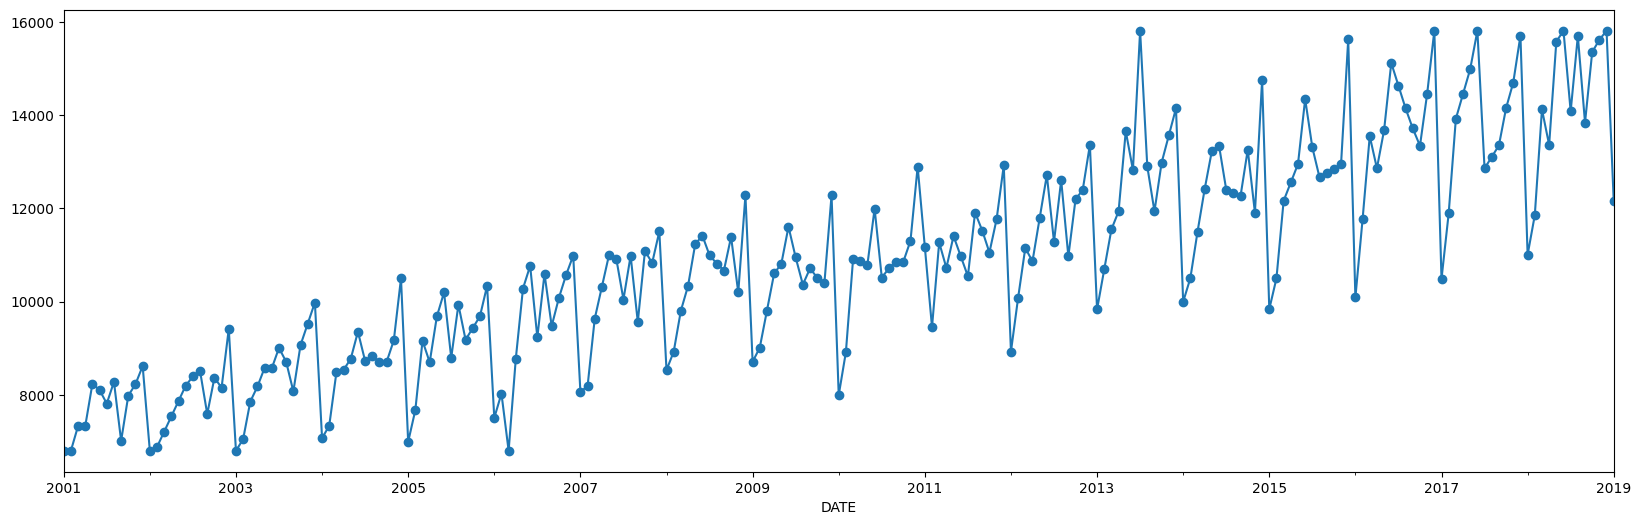

In [ ]:

# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

**Train - test splitting of data**

In [ ]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

Sales
DATE               
2018-02-01  11852.0
2018-03-01  14123.0
2018-04-01  13360.0
2018-05-01  15576.0
2018-06-01  15809.4
2018-07-01  14080.0
2018-08-01  15697.0
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  15809.4
2019-01-01  12160.0

Also, let's create a function  to estimate the performance of different models

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

Recall that in the last lecture, we had not gotten the desired MAPE score using the **simple methods**.

Now that we've performed the required preprocessing on our time series, and even split it into train and test sets, lets look at another family of forecasting techniques, called **smoothing based models**.

---

# Smoothing Based Methods


Let's expand more on the Moving Averages model.
## 1. Moving average forecasting (Implementation)

Let's make a copy of the series in df, to avoid making changes in the original series.



In [ ]:
import numpy as np

df = mobile_sales.copy()

> **Q. How do we obtain the dates for our future forecasts?**

Since we're working with a time series, naturally, we need to first create new data points with the future dates

As of now we have data till 2019-01-01, but we wish to forecast values for future.

The function **pd.date_range** is used to create the new dates for giving the forecasted values

We need to specify the following parameters in **pd.date_range**:-
- `start`: left bound for generating dates
- `periods`: Number of time steps in the range
- `freq`: frequency aliases, since we need month start frequency, our alias is `MS`. There are many more aliases.

Using the **pd.date_range**, we create a new dataframe that we can append to the existing one.

In [ ]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS'))

Empty DataFrame
Columns: []
Index: [2019-01-01 00:00:00, 2019-02-01 00:00:00, 2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00, 2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00, 2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00, 2019-12-01 00:00:00]


**Note:**
- Notice that we got the first entry as Jan-2019, which already existed in our series.
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence we utilise slicing by mentioning `[1:]`

In [ ]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')[1:]))

df.tail(20)

Sales
2018-06-01  15809.4
2018-07-01  14080.0
2018-08-01  15697.0
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  15809.4
2019-01-01  12160.0
2019-02-01      NaN
2019-03-01      NaN
2019-04-01      NaN
2019-05-01      NaN
2019-06-01      NaN
2019-07-01      NaN
2019-08-01      NaN
2019-09-01      NaN
2019-10-01      NaN
2019-11-01      NaN
2019-12-01      NaN
2020-01-01      NaN

In [ ]:
df.Sales.tail(15)

2018-11-01    15615.0
2018-12-01    15809.4
2019-01-01    12160.0
2019-02-01        NaN
2019-03-01        NaN
2019-04-01        NaN
2019-05-01        NaN
2019-06-01        NaN
2019-07-01        NaN
2019-08-01        NaN
2019-09-01        NaN
2019-10-01        NaN
2019-11-01        NaN
2019-12-01        NaN
2020-01-01        NaN
Name: Sales, dtype: float64

In [ ]:
pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

pred[-20:]

array([15809.4       , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 15809.4       , 12160.        ,
       14528.13333333, 14165.84444444, 13617.99259259, 14103.99012346,
       13962.6090535 , 13894.86392318, 13987.15436671, 13948.20911446,
       13943.40913479, 13959.59087199, 13950.40304041, 13951.13434906])

So, we can see that we have forecasts here, based on average of last 3 points for all new points.

Let's round them.

In [ ]:
pred = pred.round(1)
pred[-20:]

array([15809.4, 14080. , 15697. , 13838. , 15351. , 15615. , 15809.4,
       12160. , 14528.1, 14165.8, 13618. , 14104. , 13962.6, 13894.9,
       13987.2, 13948.2, 13943.4, 13959.6, 13950.4, 13951.1])

Now let's plot this.

<Axes: >

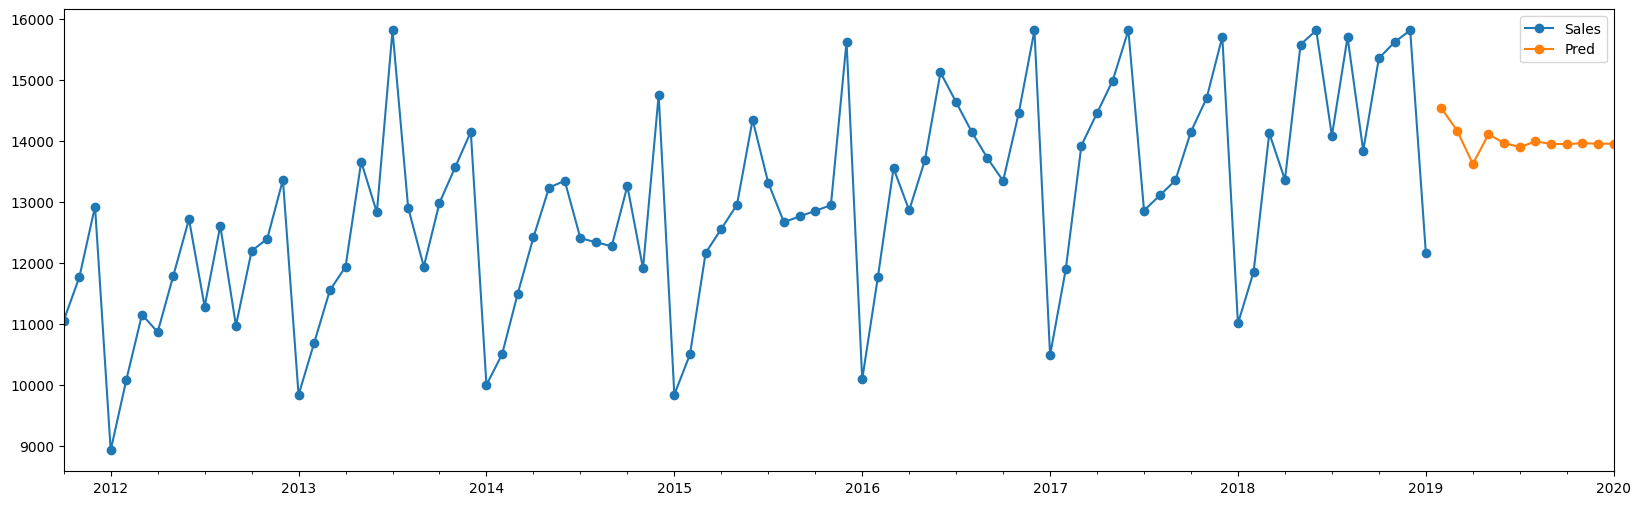

In [ ]:
df['Pred'] = pred

df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(100).plot(style='-o')

> **Q. Does this look like a good forecast?**

These forecasted values are certainly better than forecasting the mean/median or any constant values. At least, the levels looks okay.

However, it can be clearly seen that the forecast is not able to predict the variations and it gives a flat line after few predictions.

<br>

Also, if you think about it, this technique, doesn't seem to using the past data.

What is the point of having data spanning over 18 years, if we're just looking at the last 3 entries to forecast a new value.

> **Q. What would be the performance of the Moving Averages model?**

While we're at it, let's check the performance of Moving Averages model also, by using train and test sets.

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


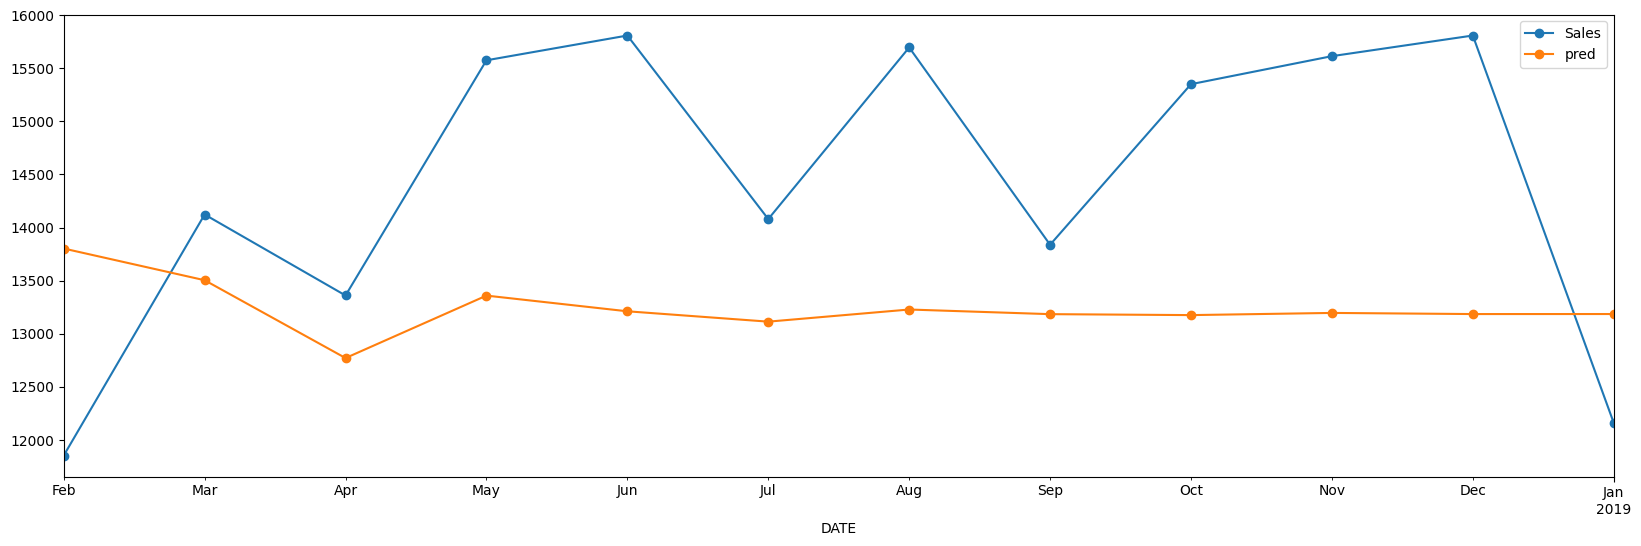

In [ ]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As per MAPE, we can say that our model has 11.5% error.

This is much better than the other models we saw. Lets look at more models.

## 2. Simple exponential smoothing

> **Q. How can we implement this concept in code?**

Let's look into the code for the same.

We have a built-in method for this technique `SimpleExpSmoothing()`, under **statsmodels** library.

While fitting this model, we need to specify the `smoothing_level` parameter, which is the same as $\alpha$ we've been looking at.
- The recommended starting point value for `smoothing_level` is $\frac{1}{2* seasonality}$
- For our case, this becomes $\frac{1}{2*12}$


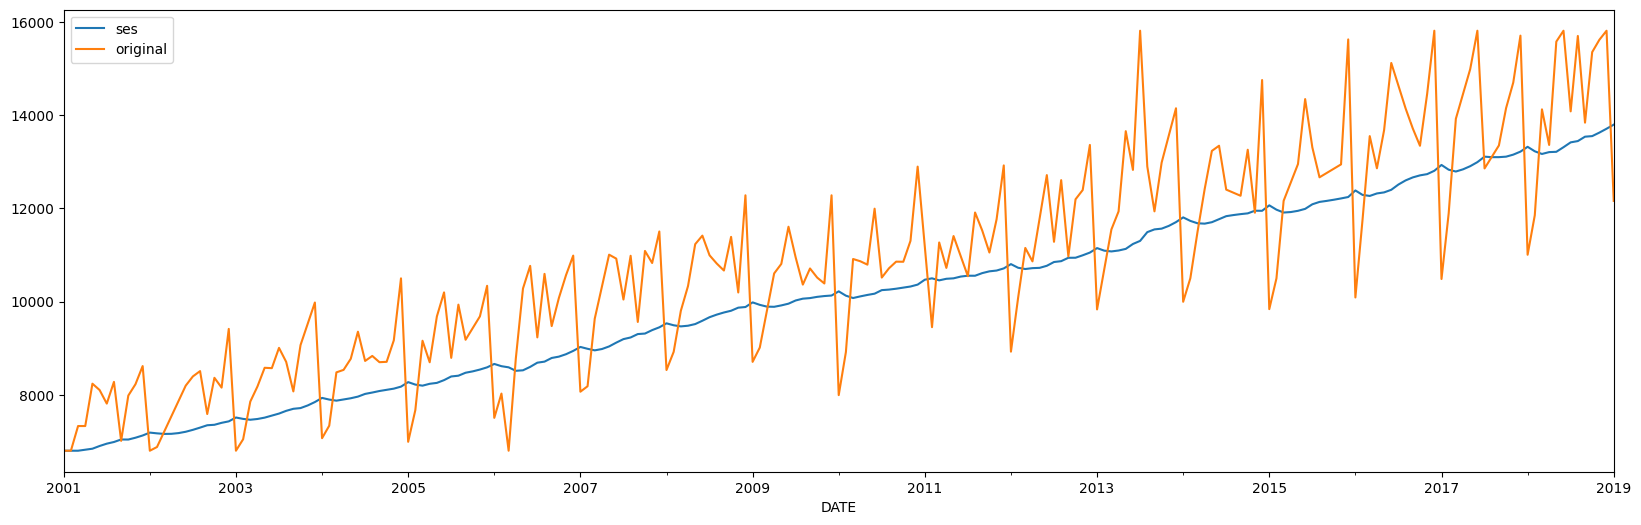

In [ ]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

model.plot(label='ses')
mobile_sales.Sales.plot(label='original')
plt.legend()

From the graph, it looks like the Simple Exponential Smoothing, got the levels right.

> **Q. How is this plot different from Moving Averages plot?**

This looks similar.

But, Unlike moving averages, it **does not have the offset** in beginning and end, because this method is initialised properly.

They fix the previous values as well.

<br>

> **Q. How can we make future forecasts from this method?**

`SimpleExpSmoothing` in statsmodels also have a `forecast()` method.

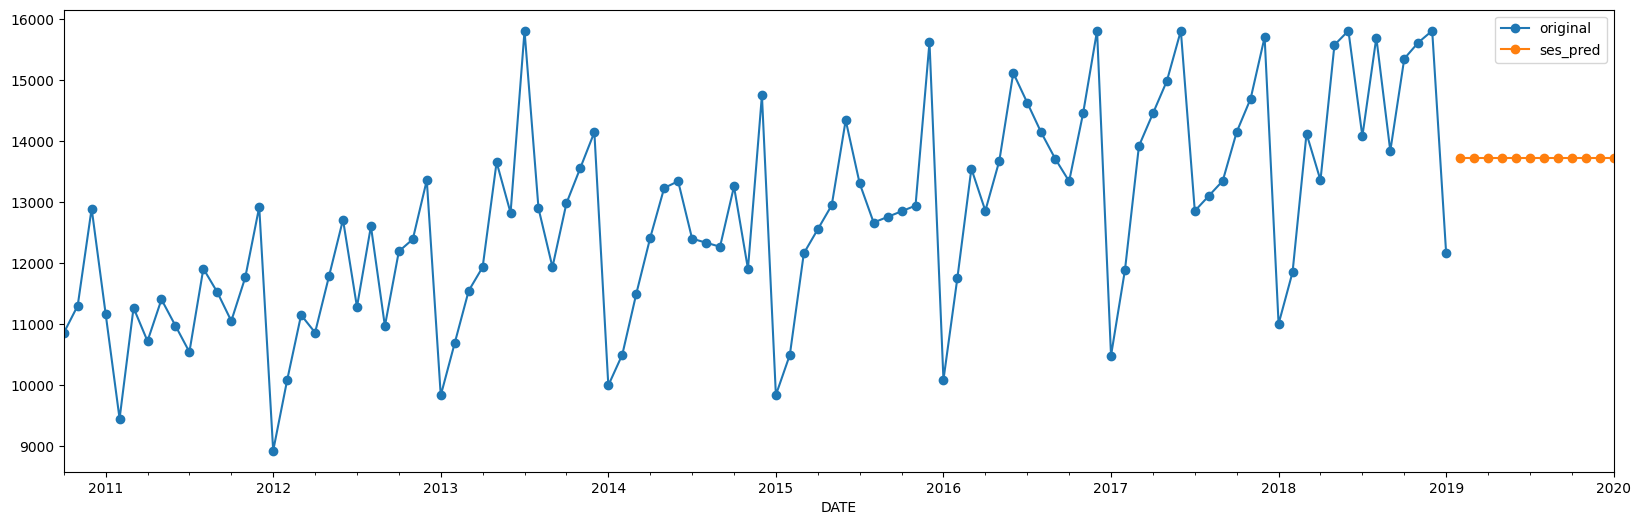

In [ ]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))
pred = model.forecast(steps = 12)

mobile_sales.Sales.tail(100).plot(label='original', style='-o')

pred.plot(label='ses_pred', style='-o')
plt.legend()

MAE : 1621.49
RMSE : 1830.741
MAPE: 0.109


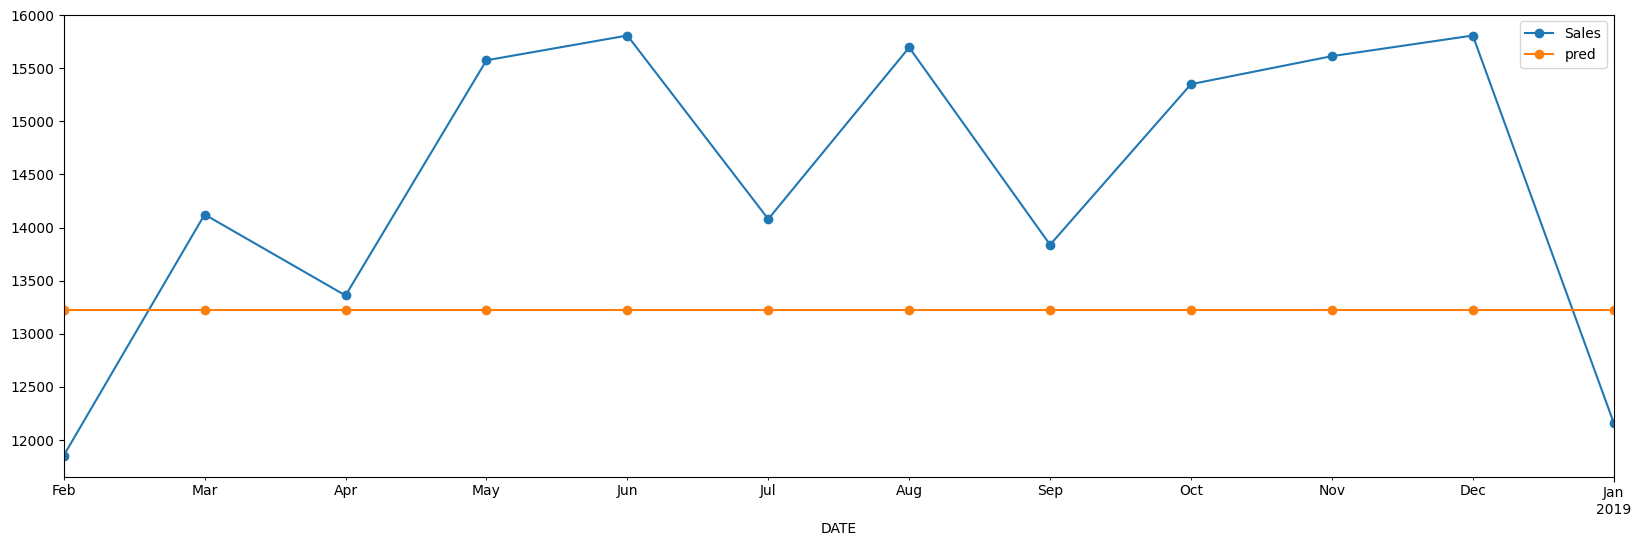

In [ ]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As expected, the prediction is a straight line, but the erros is 10% which is less than the error of  moving average.

So this model is performing better.

<br>

The SES Model is missing both
- trend, and
- seasonality




> **Q. How can we implement double exponential smoothing in code?**

Within our `ExponentialSmoothing()` function of statsmodels, we can assign the parameter `trend`.

Based on whether we wish to use an Additive or a Multiplicative model, we can assign `trend="add"` or `trend="mul"` respectively.

This way, the trend gets incorporated into the smoothing function.

Let's see the plot after double exponential smoothing.

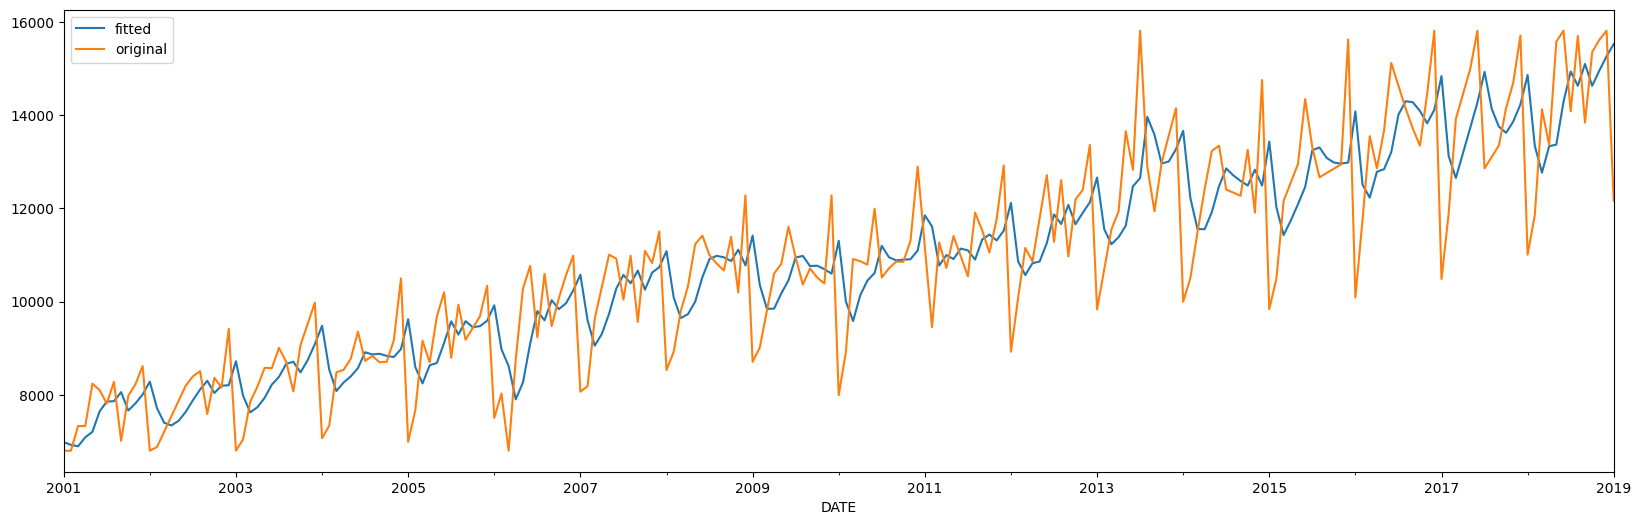

In [ ]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit(smoothing_level=0.4)
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

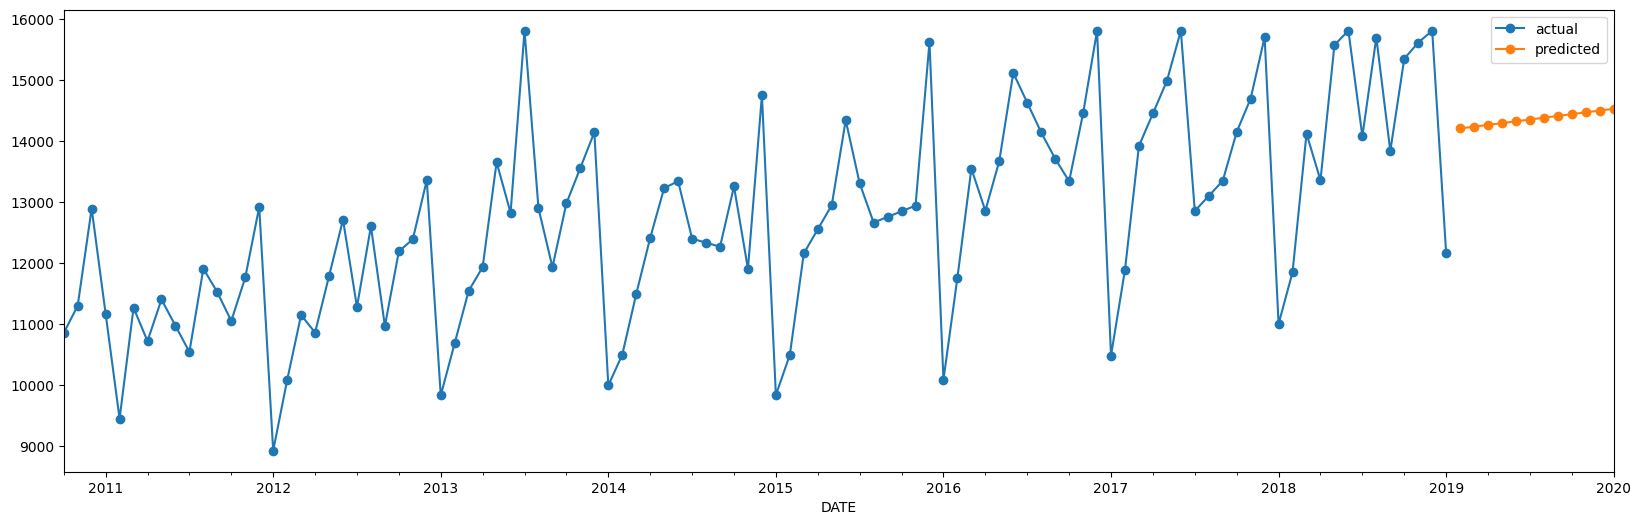

In [ ]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

From the graph you can see that, the trend of the series is also obtained along with the level of values.

<br>


> **Q. What would be the performance of the Double Exponential model?**

While we're at it, let's check the performance of Holt's method model also, by using train and test sets.

MAE : 1163.781
RMSE : 1352.497
MAPE: 0.083


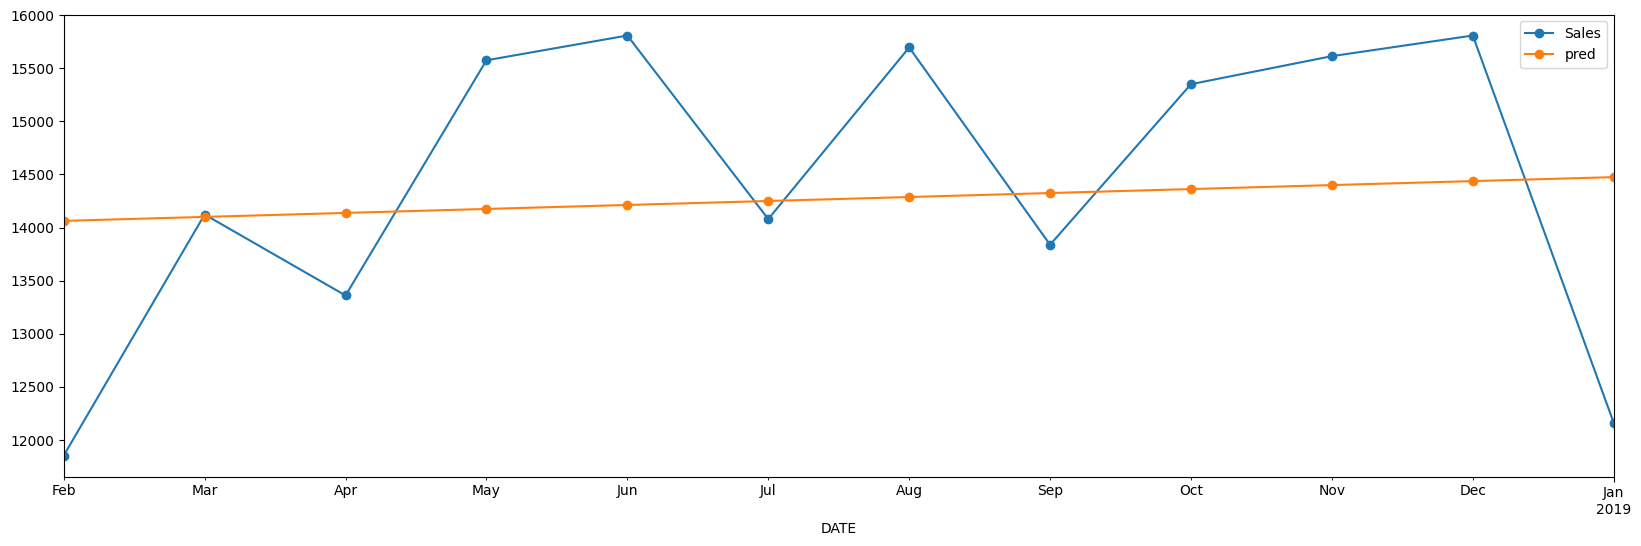

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Again, the error has reduced to 8.3% now.

Also, the MAE and RMSE values also dropped.

---

## 4. Triple Exponential smoothing (aka Holt-Winters Method)

<Axes: xlabel='DATE'>

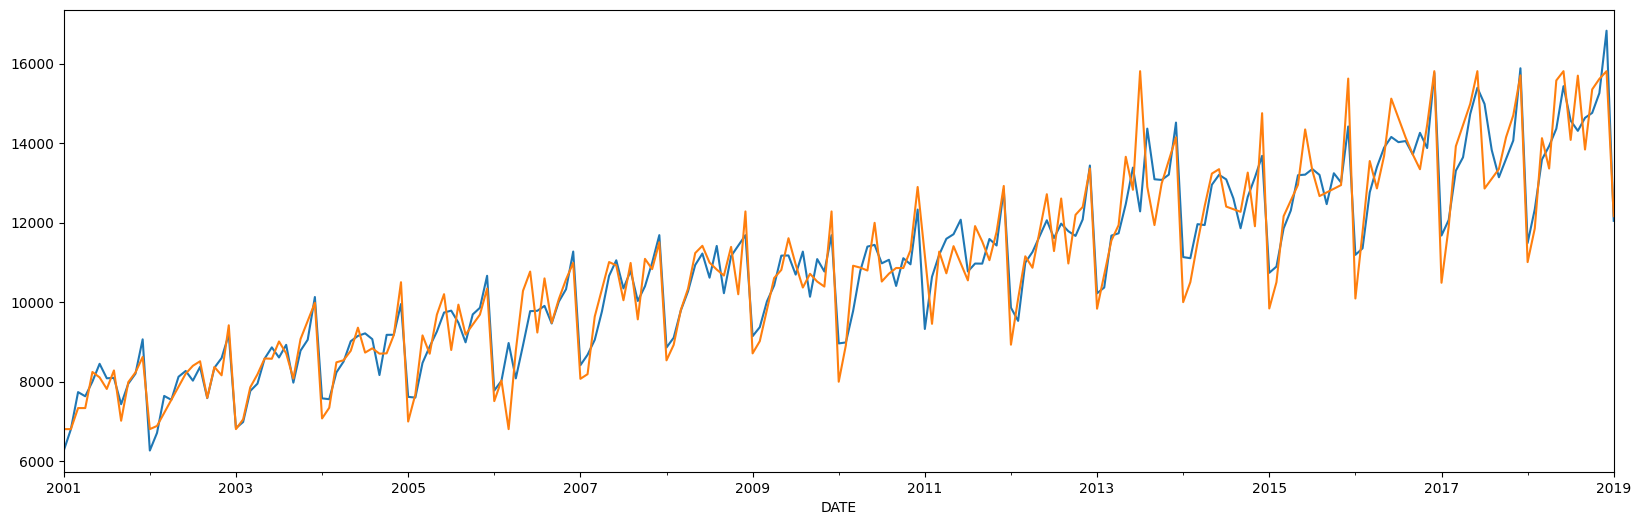

In [ ]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=0.4)
model.fittedvalues.plot()
mobile_sales.Sales.plot()

<Axes: xlabel='DATE'>

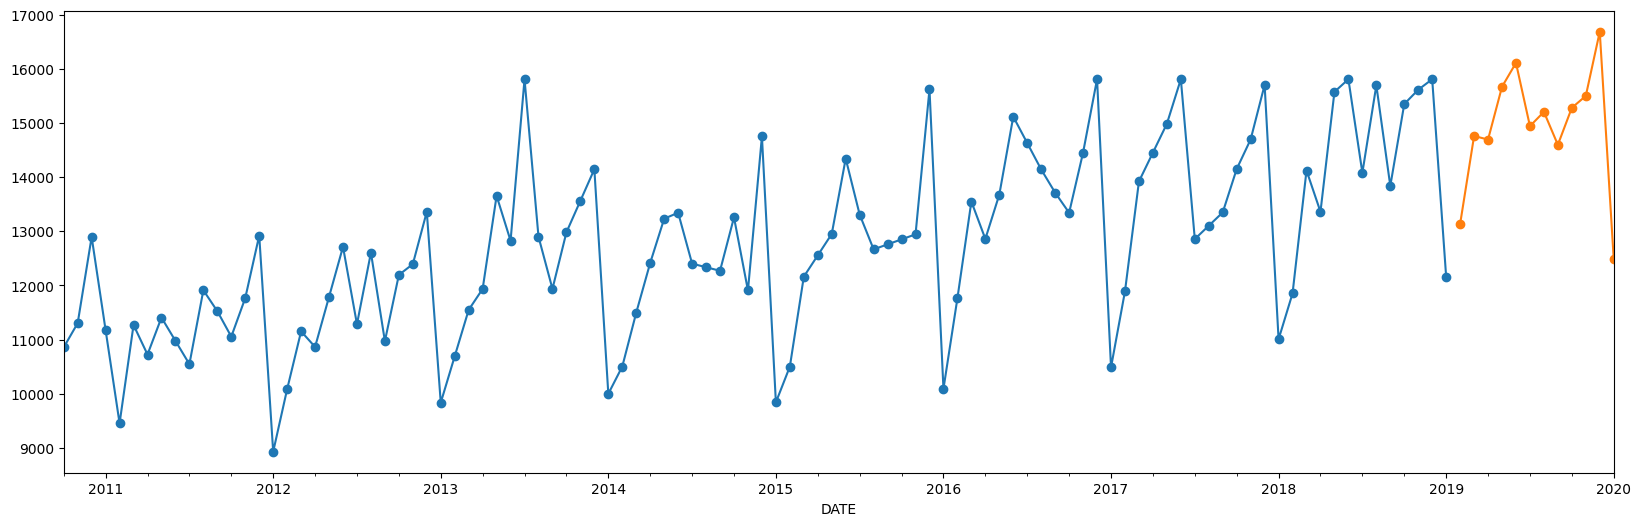

In [ ]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o')
pred.plot(style='-o')

From the plot we can see that our forecasts now look promising upon incorporating the trend and seasonality components.

<br>


> **Q. What would be the performance of the Triple Exponential model?**

While we're at it, let's check the performance of Holt-Winter's method model also, by using train and test sets.

MAE : 582.172
RMSE : 667.354
MAPE: 0.04


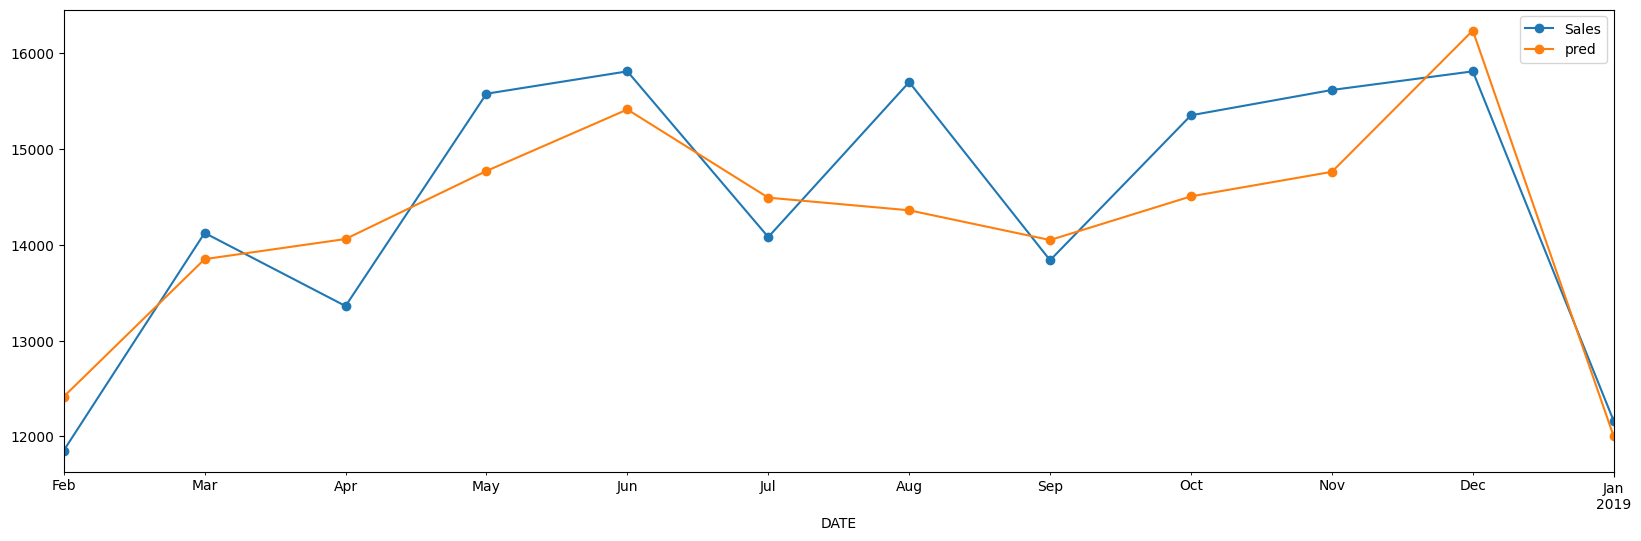

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In this plot we can clearly see that this model is having a better performance.

To back this, we can see that even MAPE error is only 6.8% now.

Also, the MAE and RMSE values have gone down a lot, from where we started.

#### Q. What if we take a mixture of additive and multiplicative models? Would that improve the performance?

MAE : 558.618
RMSE : 617.007
MAPE: 0.038


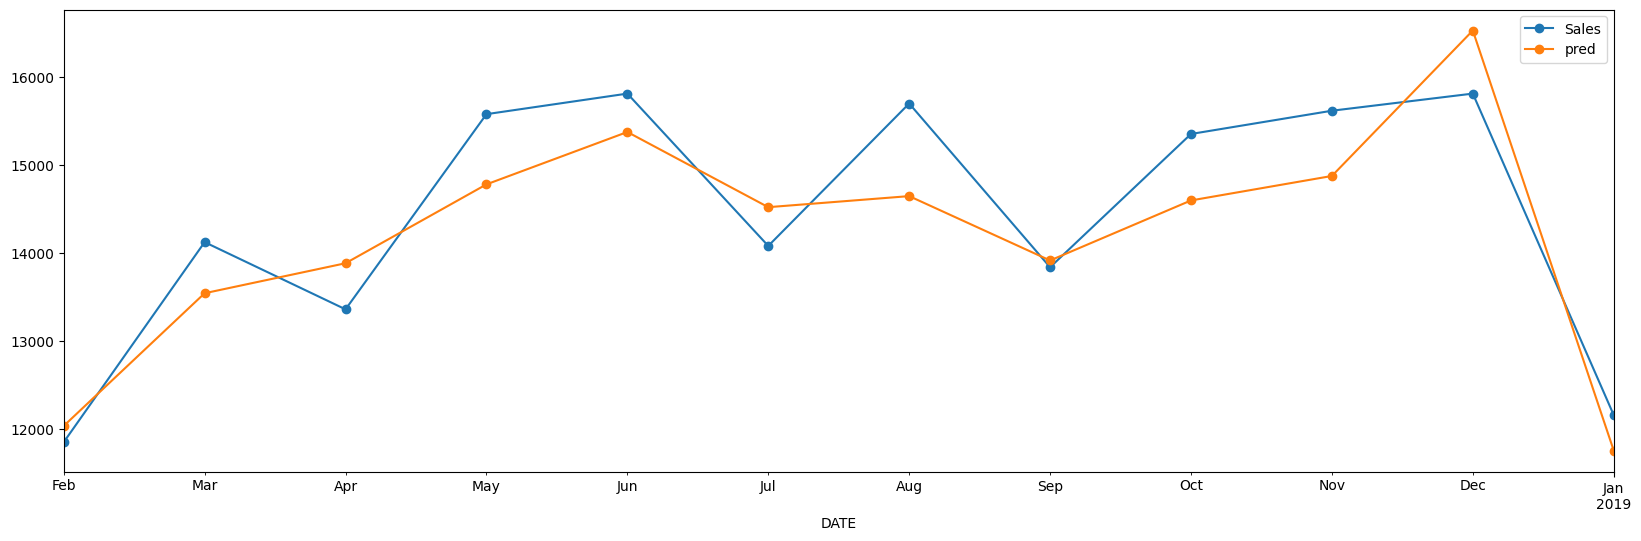

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

MAE : 488534784139.245
RMSE : 497187987765.962
MAPE: 34120366.05


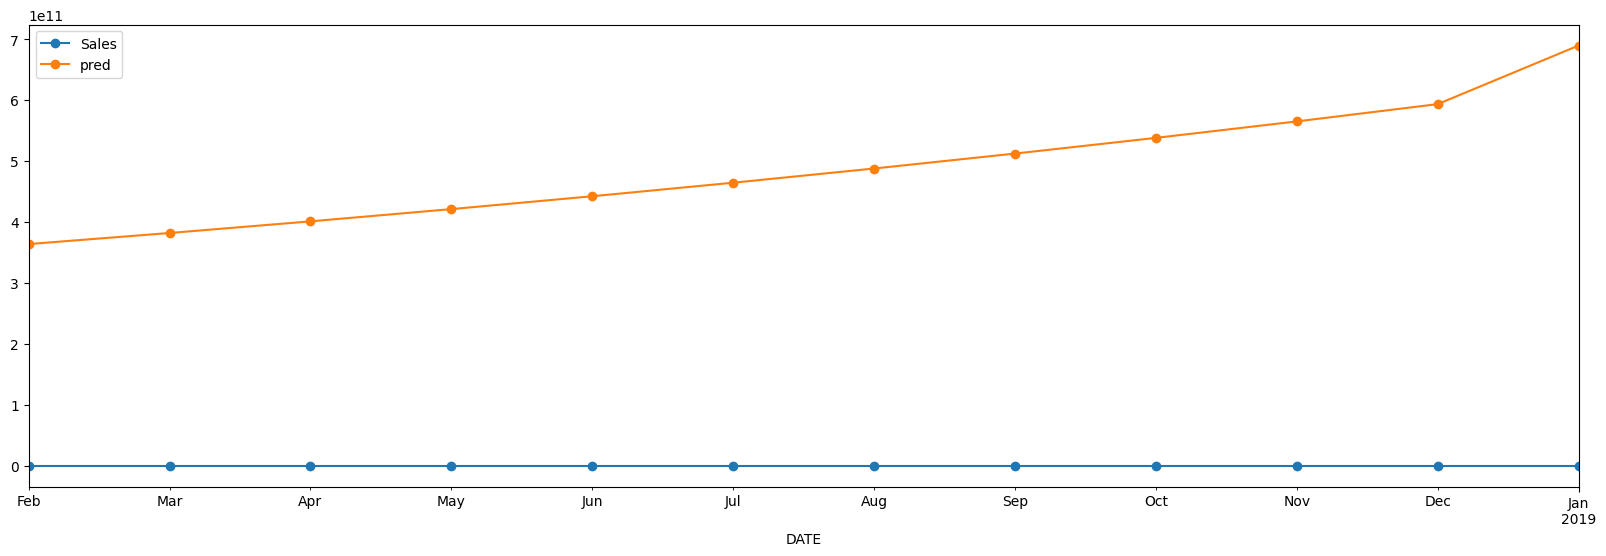

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='mul', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Here we can see that the performance of multiplicative model is better than linear model.

There is no rule for which model model (mul / add) to use when. We need to try and see which performs better.

---

## Stationarity

So far, we've been dealing with non-stationary time series. But in order to use certain forecasting methods (that we will see shortly), we need to the series to be stationary.

> **Q. What does it mean for a time series to be stationary?**

Being stationary means that, parameters (like mean, variance, amplitude, frequency) of the models should **not be dependent on time**.

Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.


**For example:** Heart beats (mean=0; standard deviation=1) is stationary — it does not matter when you observe it, it should look much the same at any point in time.

In general, a stationary time series will have no predictable patterns in the long-term.


<br>

> **Q. Why do we want to know if a time series is stationary?**

If a model's parameter varies over time, then there is a complex relation that needs to be modelled, which all models are not able to account for.

Many models assume the series to be stationary to be able to give useful results.

So, either we want to have a stationary time series, or convert to it.


### Dickey-Fuller Test

> **Q. Is there a test to help determine stationarity?**

There is a **statistical** method called **Dickey-Fuller test**, designed for testing for stationarity.

It fits an auto regressive model, checks if it worked or not. If it did, then that means it was a stationary time series.

There is a complicated mechanism to it. We don't need to know how it works. Just need to be aware of this test, as it can be handy.

<br>

> **Q. How can we implement Dickey-Fuller Test?**

We can find this as a built in function under **statmodels** library as `sm.tsa.stattools.adfuller()`.

<br>

> **Q. How do we interpret the result of Dickey-Fuller test?**

This test returns the **pvalue**.

In order for a time series to be stationary, the **pvalue** should be less than 0.05

Let's do the test for our timeseries

In [ ]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

0.9789233920172065

The pvalue of the timeseries is very high, 0.98 approx.

So we can conclude that our time series is **not stationary**.

This makes sense because our time series has both, trend and seasonality.

Let's define a simple function to know if the plot is stationary or not.

In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')


In [ ]:
adf_test(mobile_sales.Sales)

Sequence is not stationary


So, we've established, our time series is not stationary. We need to tackle this.

<br>

> **Q. How do we convert a non stationary time series into a stationary time series?**

As per basic intuition, if we remove trend and seasonality, from our time series, it should become stationary.

If it's still not stationary, then maybe there's still some seasonality or trend component left in the series.

Ideally, trend gets removed in one step. However seasonality can take multiple steps to be removed.

These processes are called **Detrending** and **Deseasonalising** respectively.

---

### De-trending

<Axes: xlabel='DATE'>

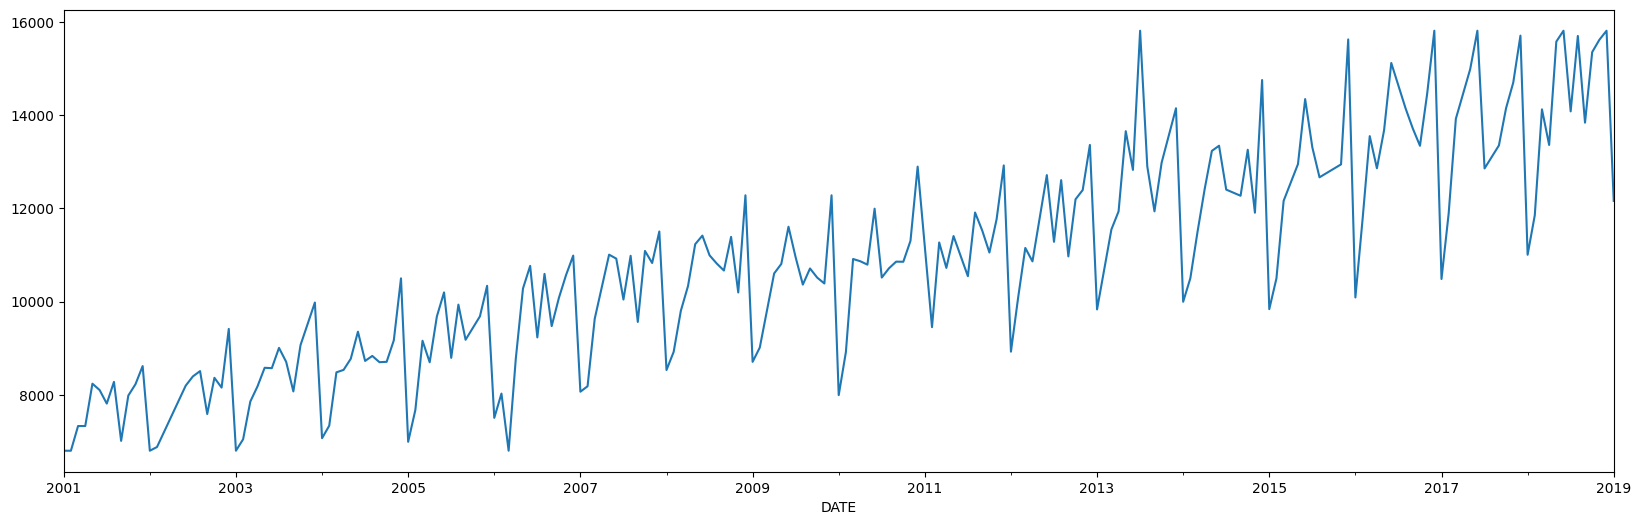

In [ ]:
mobile_sales.Sales.plot()

> **Q. How can we implement this concept of differencing in code?**

We use the `diff()` method of **pandas**.

This method calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row, as the default value is 1).

<Axes: xlabel='DATE'>

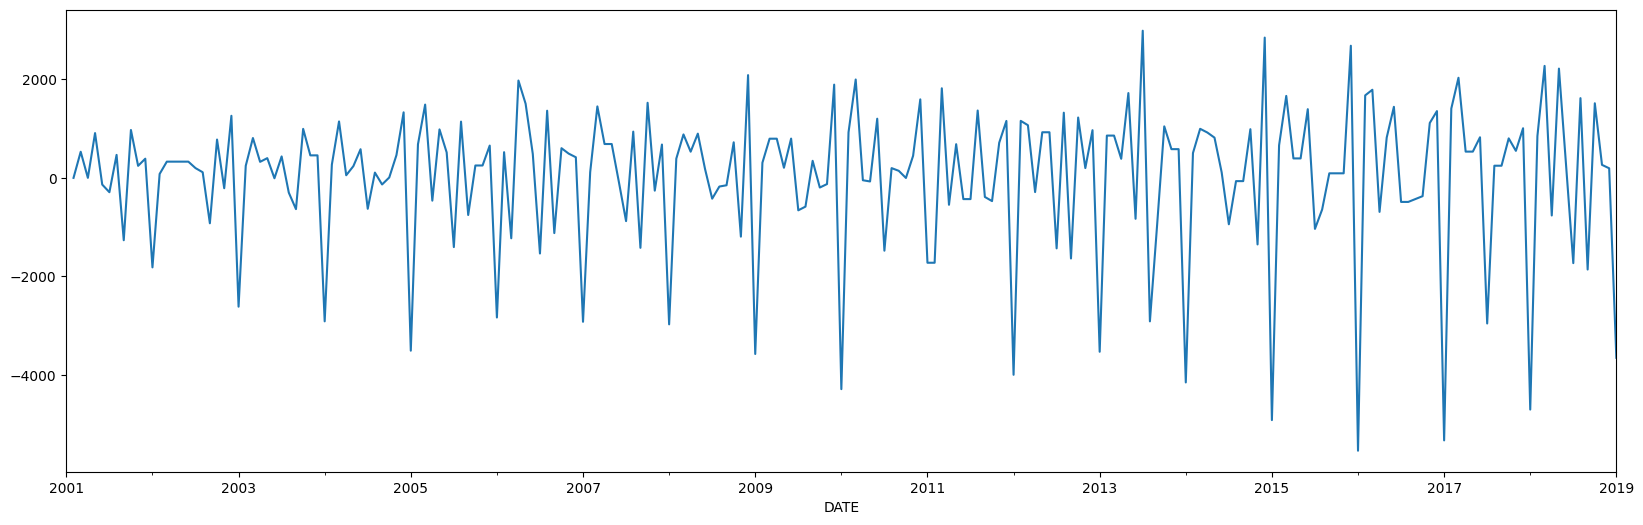

In [ ]:
detrend = mobile_sales.Sales.diff()
detrend.plot()

As you can see, here the series has been detrended.

Let's perform the Dicker-Fuller test to cross check.

In [ ]:
adf_test(detrend.dropna())

Sequence is stationary


Though very less, there is still some seasonality, as can be seen.

### De-seasonalising

<Axes: xlabel='DATE'>

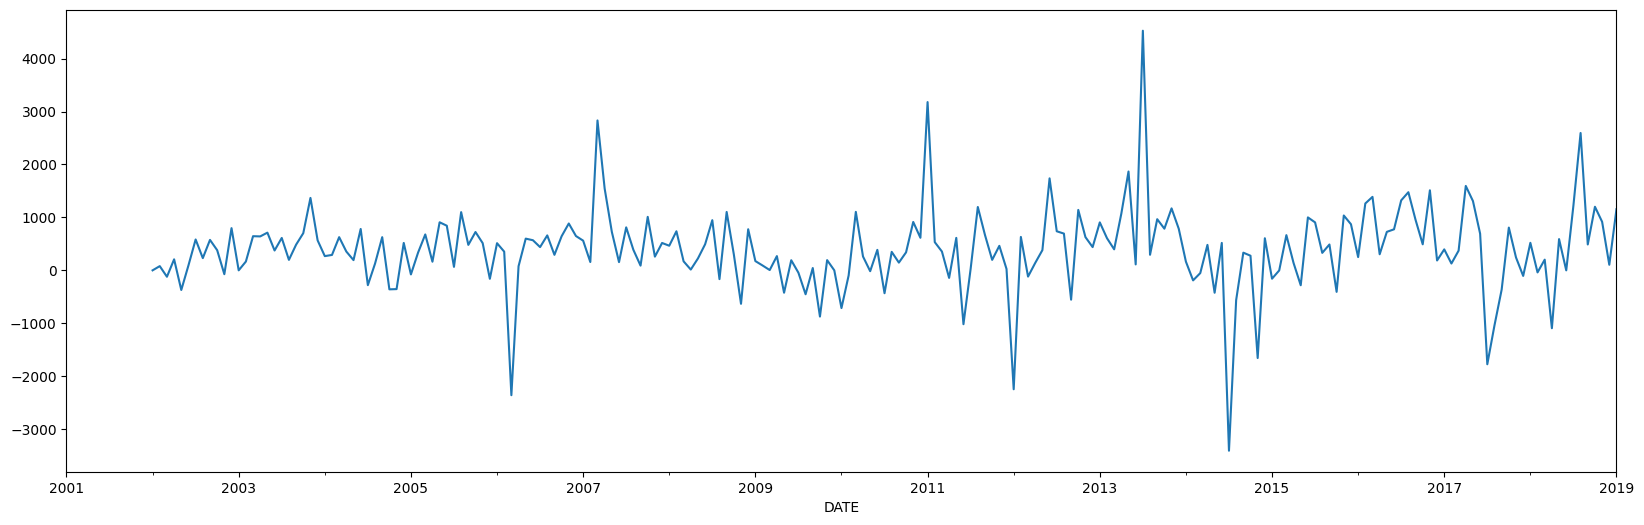

In [ ]:
deseas = mobile_sales.Sales.diff(12)
deseas.plot()

Here, as you can see we can still see very small trace of trend still.

Let's try detrending AND deseasonalising at once.

<Axes: xlabel='DATE'>

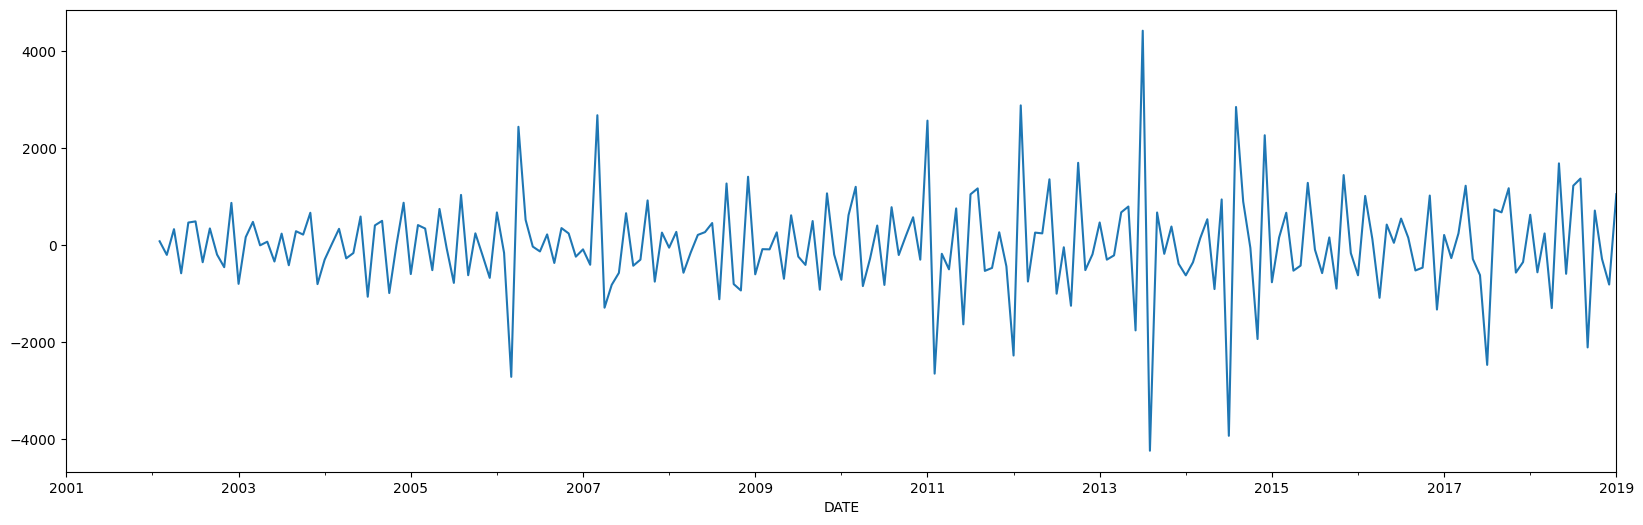

In [ ]:
stationary = mobile_sales.Sales.diff(1).diff(12)
stationary.plot()

As you can see, we've obtained a stationary time series.

**We have removed both trend and seasonality from the time series. So now all we have left is the error values:**

$y(t) - b(t) - s(t) = e(t)$

<br>

> **Here, we could visually see in the plot that value of m seems to be 12, but in other cases, it might not be obvious.**
- So we need to find the optimal value of m.


## AutoCorrelation and PartialAutoCorrelation

Let's see what the head of data looks like.

In [ ]:
mobile_sales.Sales.head()

DATE
2001-01-01    6802.44
2001-02-01    6802.44
2001-03-01    7332.00
2001-04-01    7332.00
2001-05-01    8240.00
Name: Sales, dtype: float64

Let's shift this by 1, and see what happens.

In [ ]:
mobile_sales.Sales.shift(1).head()

DATE
2001-01-01        NaN
2001-02-01    6802.44
2001-03-01    6802.44
2001-04-01    7332.00
2001-05-01    7332.00
Name: Sales, dtype: float64

Hence you can see that since now the first value in shifted time series becomes NaN, we need to skip those values while calculating ACF and PACF.

> **Q. How will we calculate correlation between two time series?**

We have the `corrcoef()` function in **numpy** library that can be utilised for this.

In [ ]:
lag = 1
np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag)[lag:])[0][1]

0.8002851477229684

We can change the value of **lag** above to see what happens for different values.

We can see that as we increase lag, the correlation decreases. At 13, it increases again.

Let's plot this.

> **Q. How can we plot the ACF and PACF values?**

There are functions in **statmodels** library, called `plot_acf()` and `plot_pacf()`, that can help here.

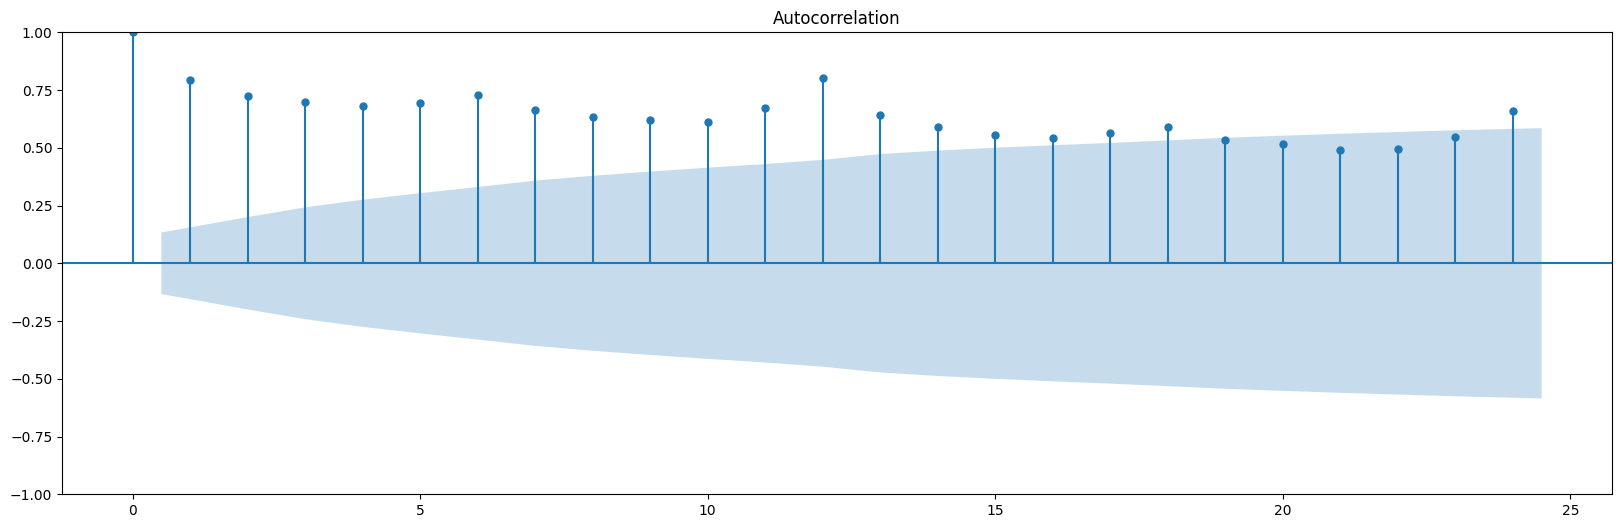

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(mobile_sales.Sales);

- From the plot we can see that the correlation value increases at every six months which we couldn't recognise just by looking at the actual data plot. So there is also a **6 month seasonality**.

- It peaks every 12th month.

<br>

For this time series, correlations are quite high.

Let's see the ACF plot for the **de-trended series**. Because intuitively also, finding seasonalities on a de-trended series would be better.

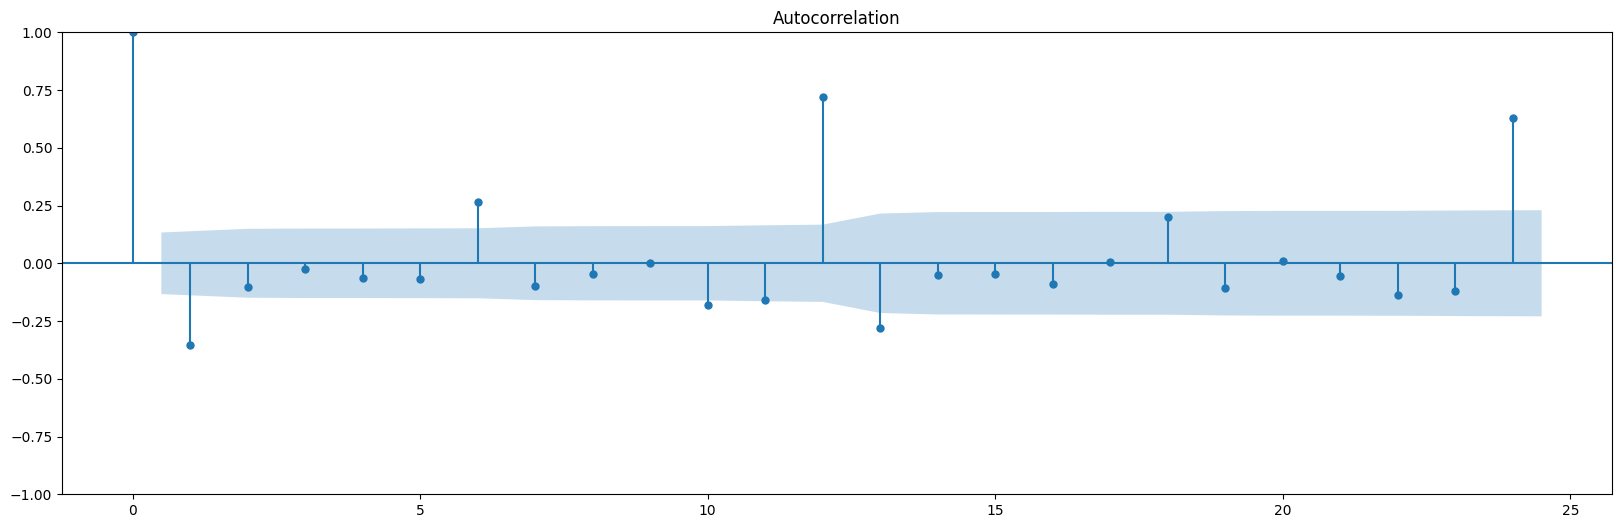

In [ ]:
plot_acf(mobile_sales.Sales.diff().dropna());

- After de-trending the series, we can see the correlation of the series is high at period of 12 and 6. This indicates there is some seasonality.

- Besides that, the correlation values are random and small.
- On removing the trend, we're **able to capture negative correlations** between the original series and lagged series with more ease.
 - As per business logic, we can expect to see a dip right after peak/holdiday season.

<br>

> **Q. What does the blue shaded region signify?**

// significance
The blue colour highlighted part is the **confidence interval** which gives the significance level of the correlation

**If the correlation is higher or out side of the blue highlighted area, that can be considered as the highly significant value.**

So the major values of lag we consider to study the seasonality pattern here are:-
- Correlation at lag=1
- Correlation at lag=6
- Correlation at lag=12
- Correlation at lag=24

Other points lie within or very close to the blue shaded region of confidence intervals.
- This means that we are not very confident about these correlation values.

**The confidence interval increases as we consider time series that are lagged more**

<br>

We will study about confidence interval in depth in the next class.

Let's do the de-seasoning, in order to get a **stationary series**, and see the ACF for it.

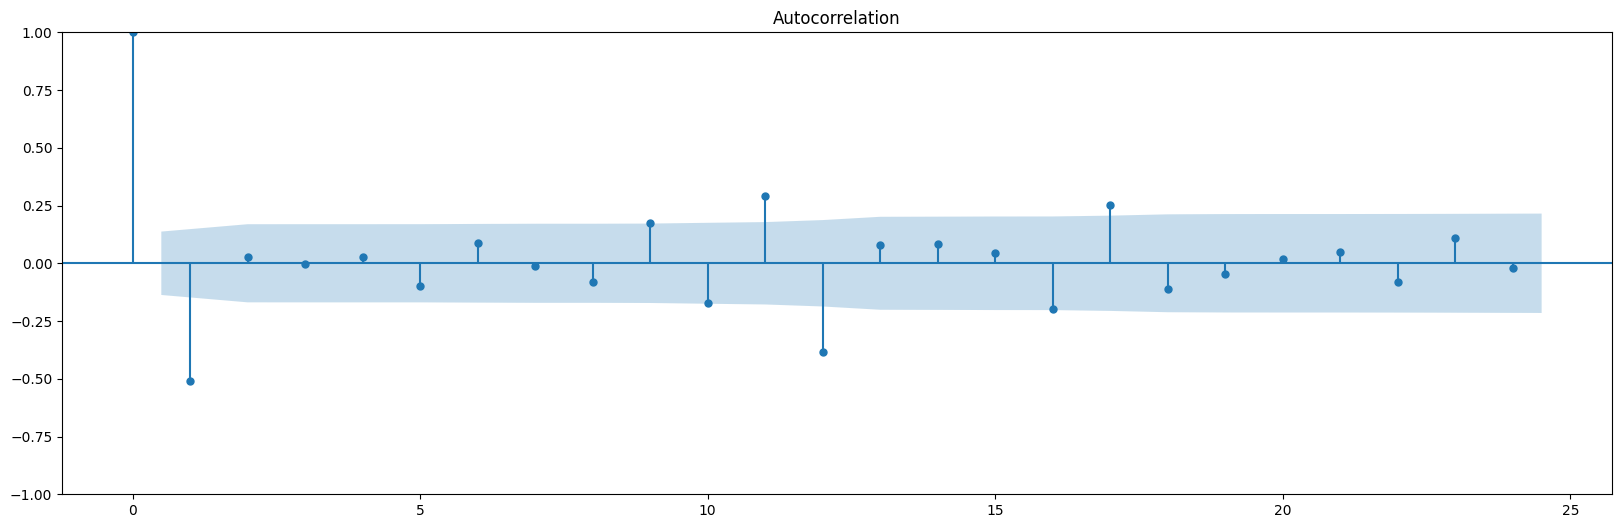

In [ ]:
plot_acf(mobile_sales.Sales.diff().diff(12).dropna());

Here we can see the significant decrease in the correlation values , that means seasonality is reduced

Even though some points are outside the confidence interval, we need not worry about them. We should only consider the points if they have a value >0.7, that is when they're significant.

Otherwise, we can choose to ignore it, it won't have that much of an effect.

Let's have a look at the Partial Auto Correlatio Plot (PACF)

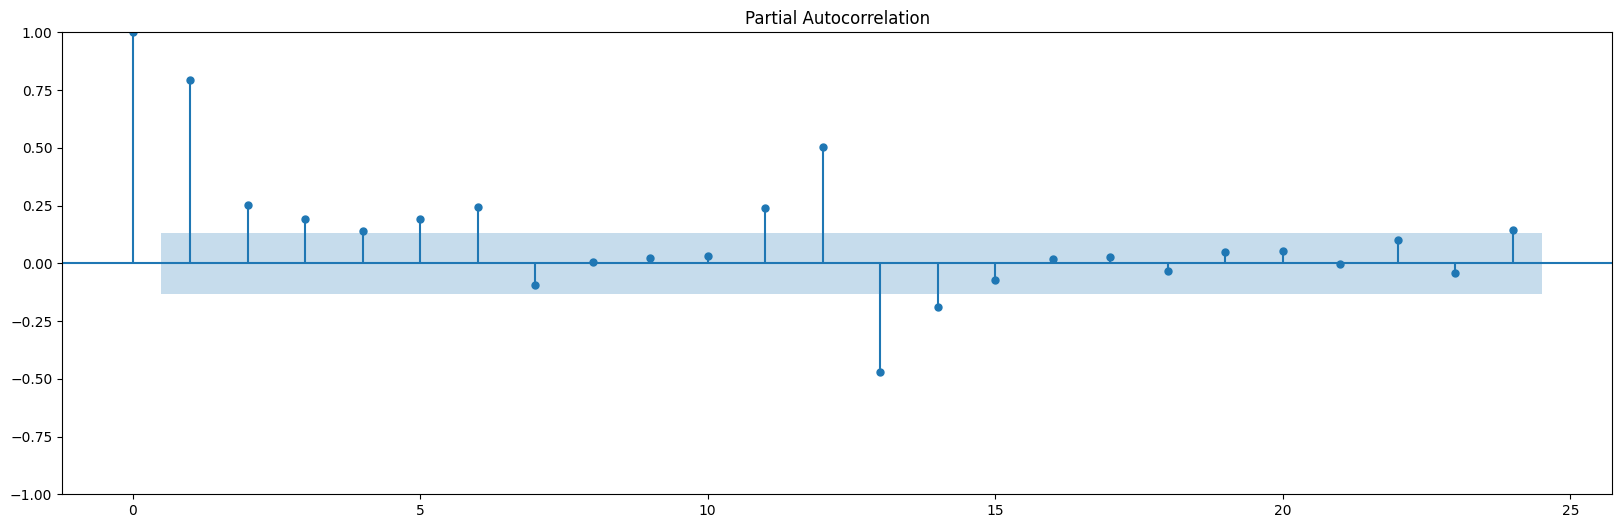

In [ ]:
plot_pacf(mobile_sales.Sales);

This PACF makes the correlation clear.

**Interpretation:-**
- Value at $i=1$ is high: This means that given the values of time series $y(t)$, we can compute the values of a time series with lag 1, $y^1(t)$ with ease.
- There is a high value at $i=12$
 - This means that even if we ignore the information given by all the time series with $lags=1, 2, ..., 11$, the information carried in time series $y^{12}(t)$ alone is very high.
 - This shows strong seasonality

<br>


**Observations:-**
- Autocorrelation plot is as expected; series does not seem to be stationary
- Diff series is indeed stationary. Also, seasonality can be seen using this plot.
- De-seasoned series does not have any seasonality or trend.
- PACF suggests that only the first lag and 12th lag is strong.

> **NOTICE:-**
- We calculate PACF on the original time series, whereas ACF is plotted on stationary time series.

## Correlation Vs Causation

> **Q. If a variable x is correlated with another variable y, does that mean that x causes y?**

A variable x  may be useful for forecasting a variable  y, but that does not mean x is causing y.

For example,
- it is possible to model the **number of drownings at a beach** resort each month with the **number of ice-creams sold** in the same period.
- The model can give reasonable forecasts, not because ice-creams cause drownings, but because people eat more ice-creams on hot days when they are also more likely to go swimming.

So the two variables (ice-cream sales and drownings) are **correlated**, but one is **not causing** the other.

They are both caused by a third variable (temperature).

This is an example of **confounding**.

<br>

> **Q. What is the relevance of correlation and/or causality with forecasting models?**

Correlations are useful for forecasting, even when there is no causal relationship between the two variables.

For example,
- It is possible to forecast if it will rain in the afternoon by observing the number of cyclists on the road in the morning.
- When there are fewer cyclists than usual, it is more likely to rain later in the day.

This model can give reasonable forecasts, not because cyclists prevent rain, but because people are more likely to cycle when there is less or no chance of rain.

In this case, there is a causal relationship, but in the opposite direction to our forecasting model.

<br>

> **Q. If we can get good forecasts based on correlated variables, why bother trying to understand the causality behind them?**

Though we can get good forecasts based on correlated variables, if we try and understand the causality behind those variable, we can identify better features, thereby creating a better model.

- A better model for drownings example will probably include **temperatures** and **visitor numbers** and exclude ice-cream sales.

- A good forecasting model for rainfall will not include cyclists, but it will include **atmospheric observations** from the previous few days.


---

# ARIMA Family of Forecasting Techniques

## 1. Auto Regression (AR)

Before applying the AR Model, let's check the nature of our time series right now (stationary/non-stationary) using the `adf_test()`

In [ ]:
train_x.head()

Sales
DATE               
2001-01-01  6802.44
2001-02-01  6802.44
2001-03-01  7332.00
2001-04-01  7332.00
2001-05-01  8240.00

In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(train_x.Sales)

Sequence is not stationary


Recall that we need to have a stationary time series to use AR Model.

Let's **de-trend** it by taking a difference of 1.

In [ ]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


> **Q. How can we implement AR in code?**

We import the SARIMAX function from **statsmodel**. We will shortly see what SARIMAX itself means.

We have to pass `order` parameter. It accepts a tuple of 3 values, we will see what these values mean.

For now, in order to implement pure AR, we pass `(1,0,0)` to `order`, where 1 specifies the order we wish to use for AR. We can change this order as per our choice.

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(1, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

DATE
2018-02-01    1728.700558
2018-03-01    -635.966295
2018-04-01     233.963671
2018-05-01     -86.072170
2018-06-01      31.664824
2018-07-01     -11.649074
2018-08-01       4.285542
2018-09-01      -1.576595
2018-10-01       0.580009
2018-11-01      -0.213378
2018-12-01       0.078499
2019-01-01      -0.028879
Name: pred, dtype: float64

Since we've gotten the forecasts from the de-trended series, we need to **integrate the trend back**, in order to obtain the true value of our forecasts!

In [ ]:
# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

MAE : 2307.213
RMSE : 2585.999
MAPE: 0.153


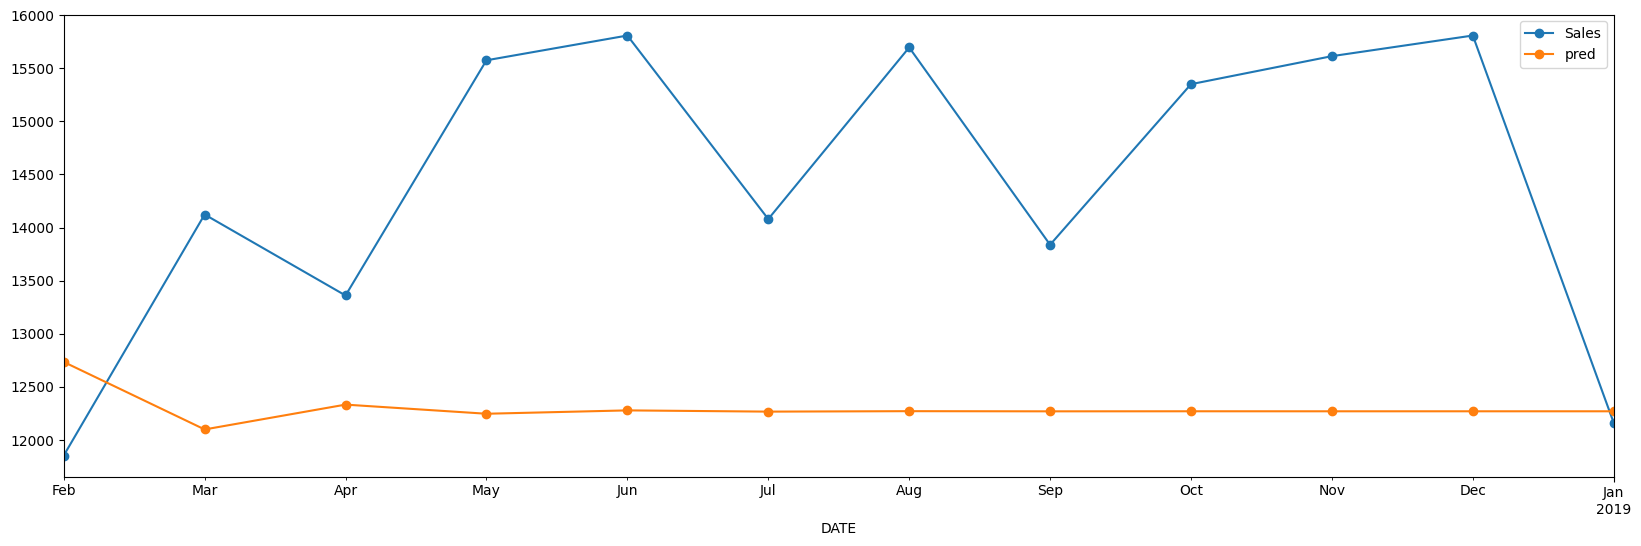

In [ ]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

This is not performing that well. Let's see what the optimal value for order should be by looking at PACF plot.

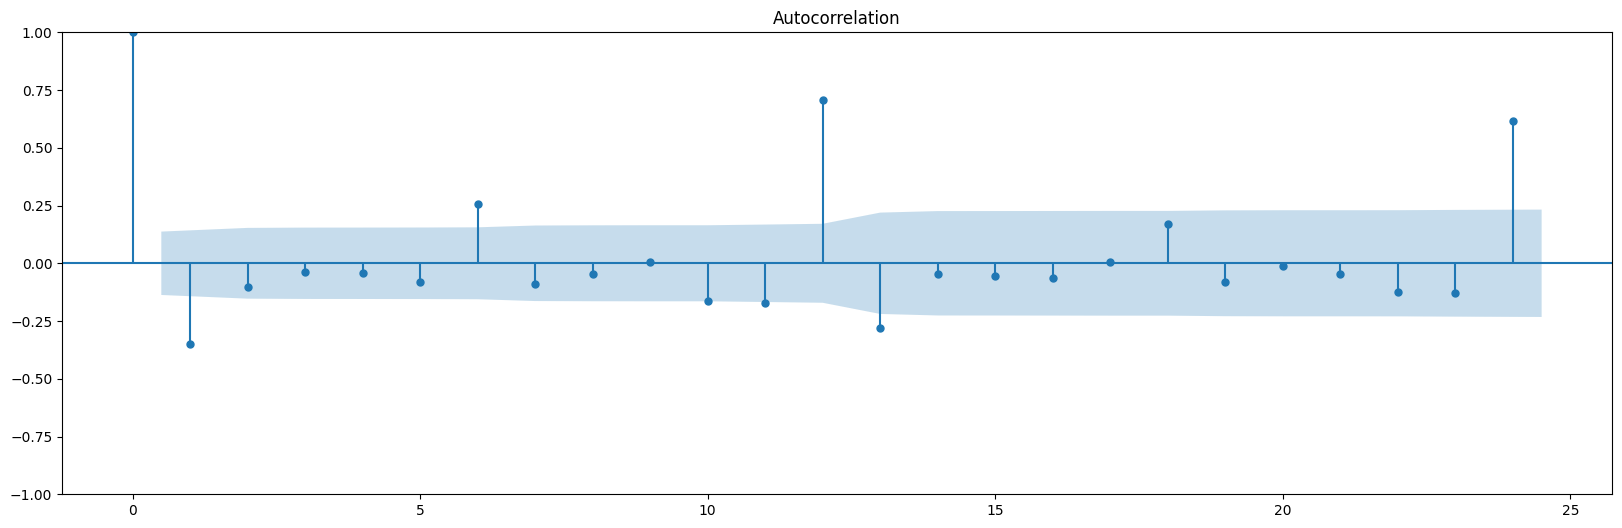

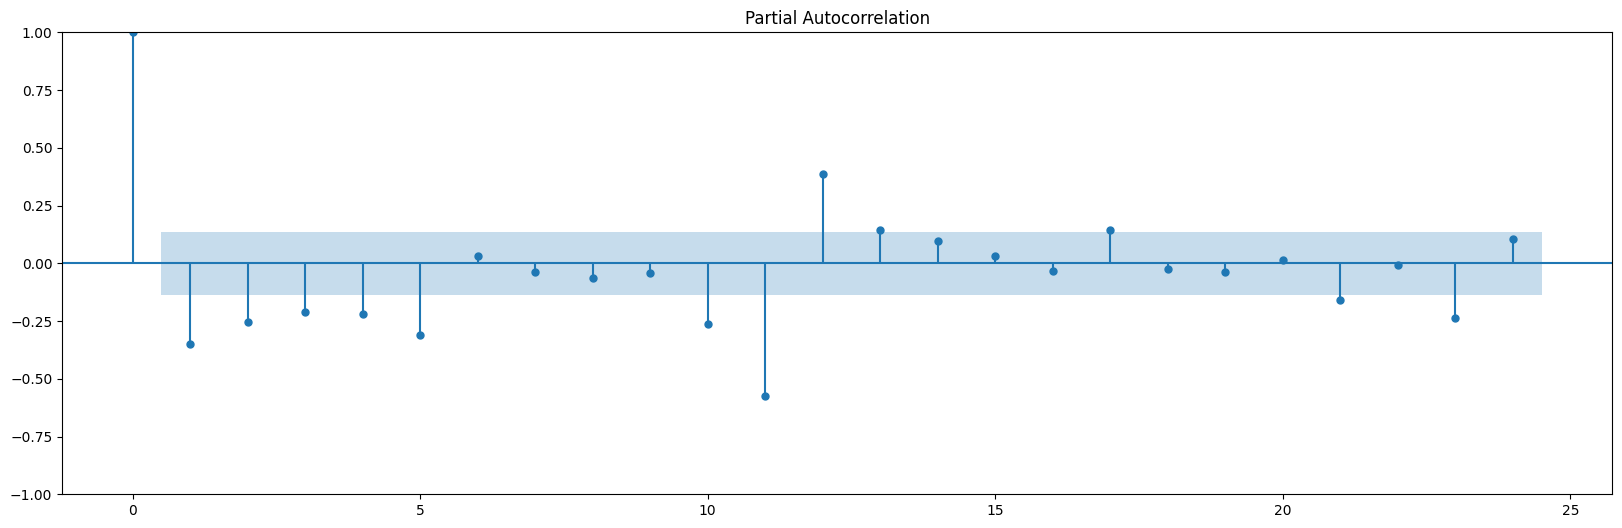

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(train_x_st.Sales);
plot_pacf(train_x_st.Sales);

> **GUIDE**
> - **If the ACF plot gradually decreases, and PACF plot suddenly cuts of after lag k, then we can consider AR model with order p=k**
> - Here, there is also some seasonality which we did not remove, maybe there is also some quaterly seasonality, which is why the above rule does not give a clear guess -- Human judgement call needed here

From here, we see the best value is 3. Note that -ve is also significant. (Here it could also be 4-5, but taking a judgement call, later correlations maybe due to some more left over seasonality).

Lets try that

MAE : 1647.061
RMSE : 1890.003
MAPE: 0.11


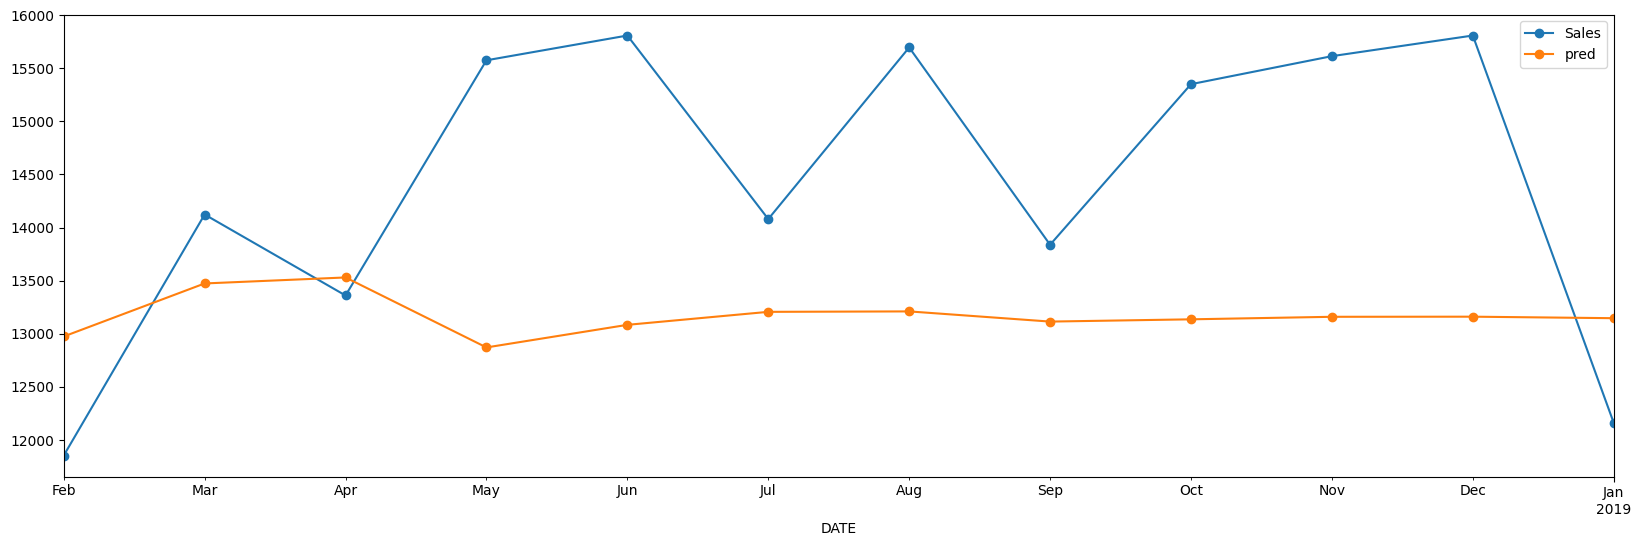

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

MAE : 1362.947
RMSE : 1558.015
MAPE: 0.093


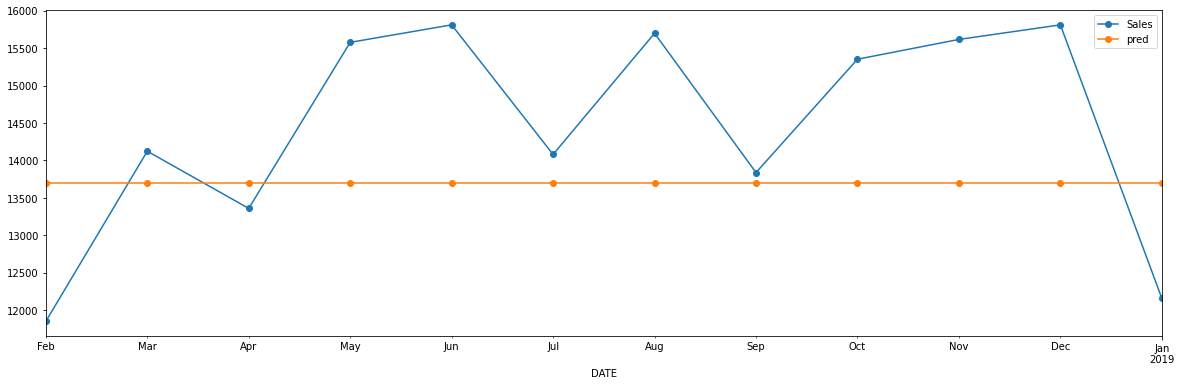

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 1))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Great.

Lets try 3 as order of MA. (Just doing some manual trial and error)

> **GUIDE**
> - **If the PACF plot gradually decreases, and ACF plot suddenly cuts of after lag k, then we can consider MA model with order p=k**
> - Here, its not very clear and so we cannot easily judge the best MA value

MAE : 1359.181
RMSE : 1555.968
MAPE: 0.092


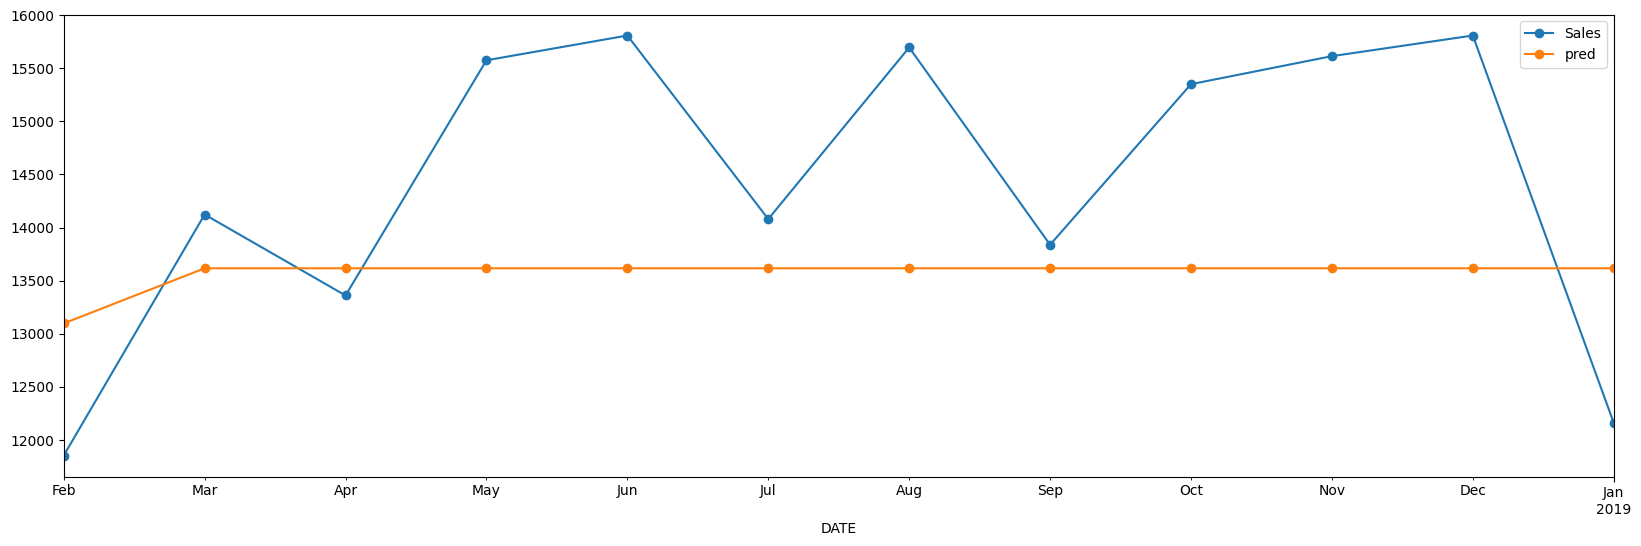

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 2))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---

## 3. Auto Regression - Moving Averages (ARMA)

> **Q. What is the limitation of ARMA method?**

- The major limitation of this technique is that the series should be **stationary**
 - because, if we're training a Linear Regression, the variables can not be dependent on each other.

<br>

Let's see the code part for the same

> **Q. Can anyone guess How to implement ARMA in code?**

We specify order of AR and MA as first and third place in the tuple containing `order` parameter value.

MAE : 1298.761
RMSE : 1521.207
MAPE: 0.088


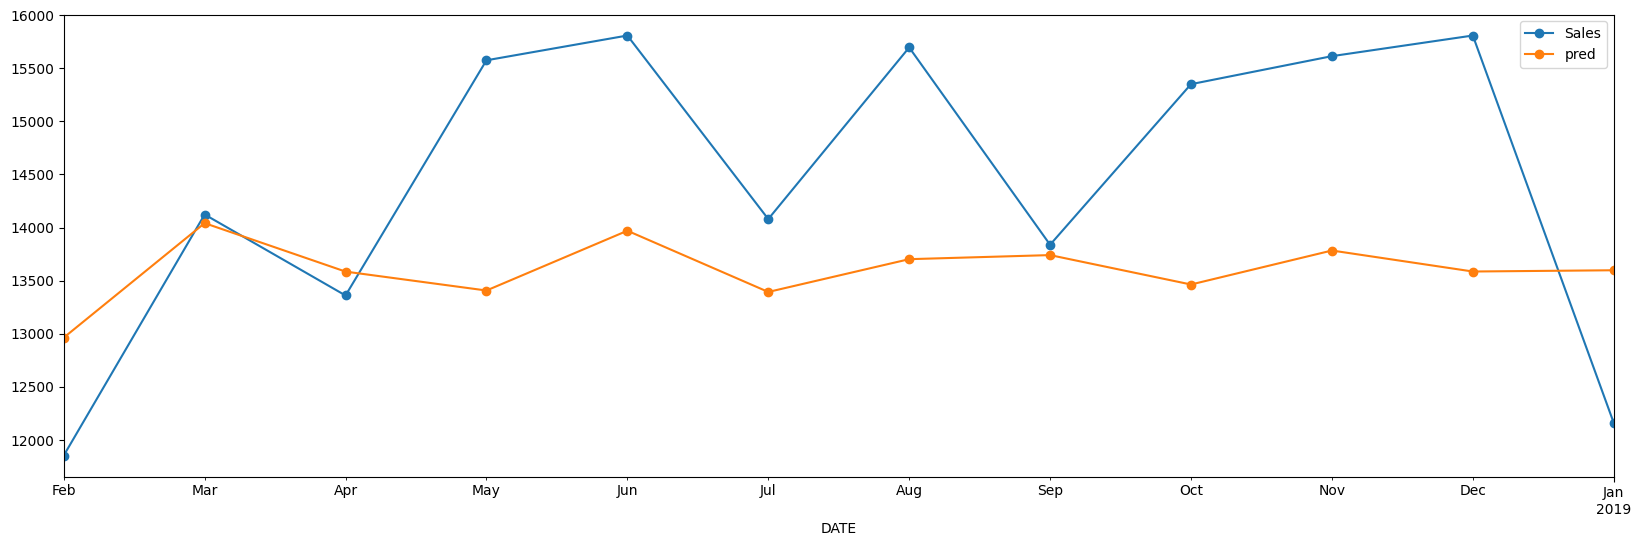

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---

## 4. ARIMA

MAE : 1307.345
RMSE : 1529.03
MAPE: 0.088


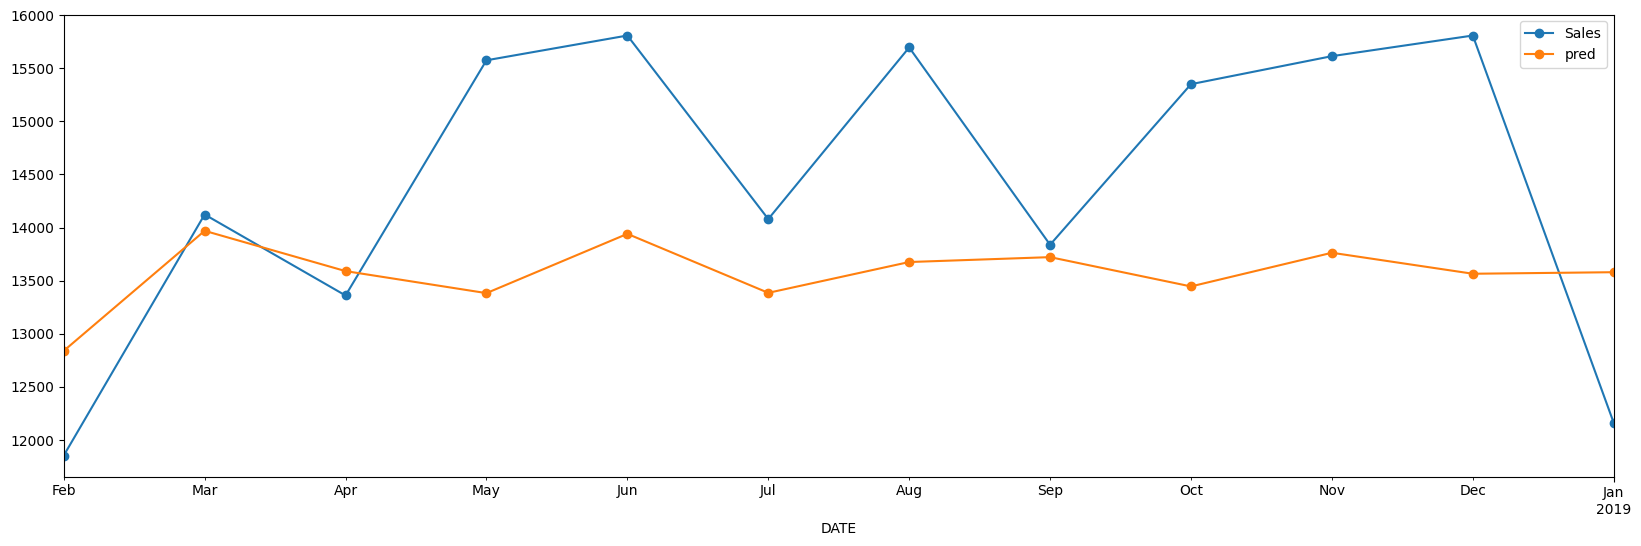

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_x.Sales, order=(3, 1, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

> **NOTICE:-**
- This is the same as us using the ARMA model with manual integration !!
- It means our logic is as good as the authors of statsmodels! That's always encouraging !

Now lets try higher order for differencing and see if that helps.

MAE : 1725.716
RMSE : 1951.8
MAPE: 0.116


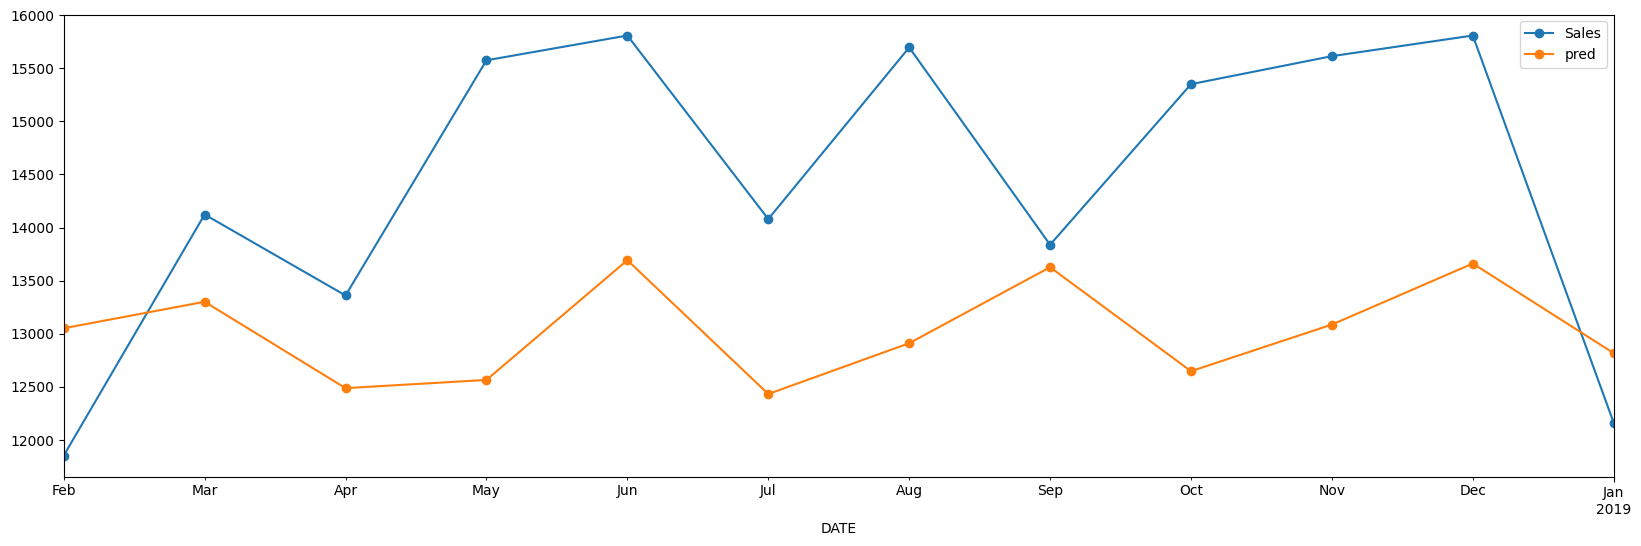

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_x.Sales, order=(3, 2, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Does not get better ! Lets leave it at 3,1,3


---

## 5. SARIMA

If we wish to account for seasonality, the process becomes:-
- first differentiating $(x[i] - x[i-T])$, to remove seasonlity,
- then performing AR and MA,
- then integrating the seasonality back,

This is very tiring.

<br>

Instead of doing so much work to utilise the ARIMA model, we can just apply another model called :the **SARIMA model** directly.

There are 7 parameters for SARIMA: `P,Q,D,p,q,d,s`

We're already familiar with `p, q, d` hyperparameters. Let's take a look at the other parameters.

<br>





Let's take a look at `P, Q, D`.
- These are similar to `p, q, d` parameters respectively, but they **account for seasonlity components as well**.


### Hyperparameter `P`

Recall the functionality of `p`
- When we set the order of AR as `p`, the formulation becomes: $\hat{y}_t = \alpha_0 + Σ_{i=1}^p α_iy_{t-i}$

<br>

> **The effect of setting `P` hyperparameter for SARIMA is: $Σ_{i=1}^P β_i y_{t-is}$**
 - Since our seasonality is 12
 - Essentially, `P` enables in creating an AR Model on data that is 12 months old, 24 months old, ..., 12P months old: $y_{t-12}, y_{t-24}, ..., y_{t-12P}$
 - So this is exactly like an AutoRegression, but with seasonality.

<br>

Suppose we wish to forecast $\hat{y}_{100}$ (i.e. t=100) with following hyperparameter values:-
- $p = 4$
 - Contribution to final forecast: $α_1 y_{99} + α_2 y_{98} + α_3 y_{97} + α_4 y_{96}$

- $s = 12$

- $P = 3$
 - Contribution to final forecast: $β_1 y_{100-12=88} + β_2 y_{88-12=76} + β_3 y_{76-12=64}$

TODO: Scribble 100

### Hyperparameter `Q`

> **Similarly, the effect of setting `Q` hyperparameter for SARIMA is: $Σ_{i=1}^Q c_i \epsilon_{t-is}$**
 - Since our seasonality is 12
 - Essentially, `Q` enables in creating an MA Model on data that is 12 months old, 24 months old, ..., 12Q months old: $y_{t-12}, y_{t-24}, ..., y_{t-12Q}$
 - So this is exactly like an MovingAverage, but with seasonality.


<br>

Suppose we wish to forecast $\hat{y}_{100}$ with following hyperparameter values:-
- $q = 4$
 - Contribution to final forecast: $m_1 ϵ_{99} + m_2 ϵ_{98} + m_3 ϵ_{97} + m_4 ϵ_{96}$

- $s = 12$

- $Q = 3$
 - Contribution to final forecast: $c_1 ϵ_{100-12=88} + c_2 ϵ_{88-12=76} + c_3 ϵ_{76-12=64}$

TODO: Scribble 101

> **Q. How to implement this in code?**

- Besides specifying values for the `order` parameter, we also need to add values for the `seasonal_order` parameter.
- This is done in the order: `P, D, Q, s`

Let's see how the plot looks like

MAE : 536.809
RMSE : 622.984
MAPE: 0.037


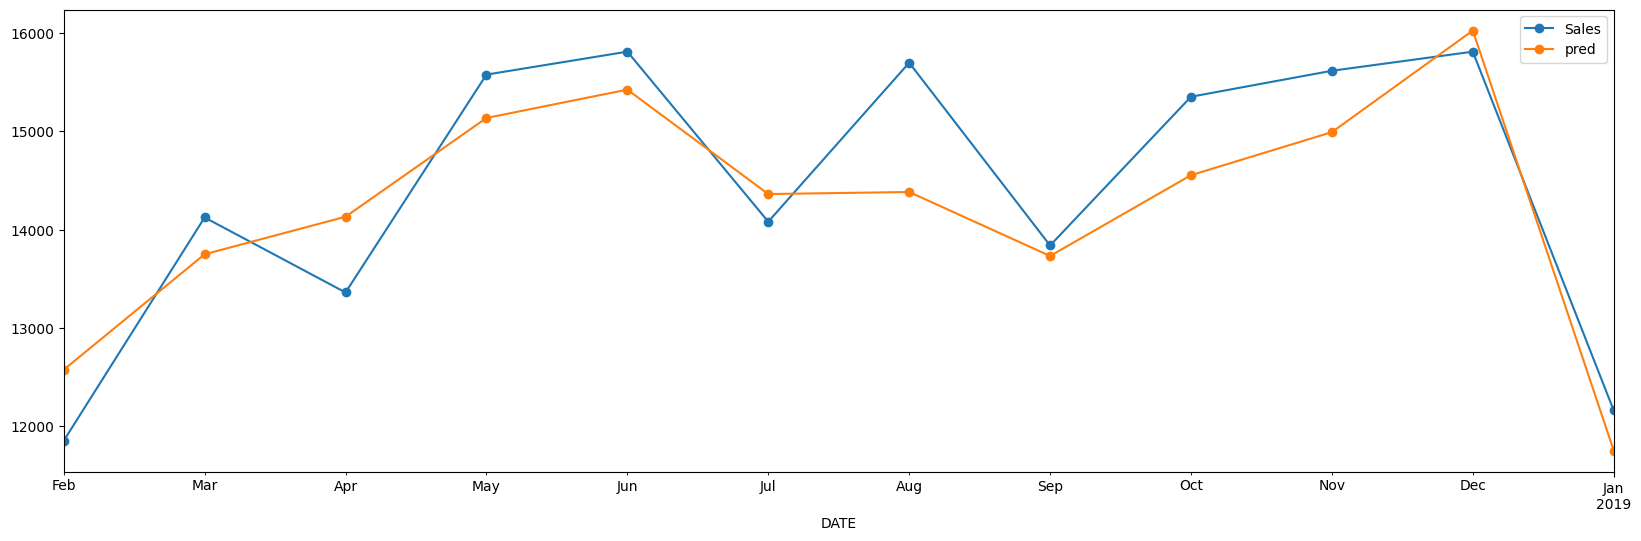

In [ ]:
model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Great ! This is the best fit so far!! Even better than TES.

---

# End Note

We have seen:
  - Naive Methods (only good for baseline estimates)
  - Smoothing Methods, TES seemed to work great for us.
  - ARIMA methods, SARIMA was the best so far!

Also note that although SARIMA was best but we did not try a lot or different params. It can be hard to find the best combinations of params, and although there are some methods to guess them, they are complex and we wont be didcussing them here.

Hence ARIMA can be great but hard to tune !

---
---

## Data Preprocessing (Recap from last lecture)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,8)

In [ ]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 39.6MB/s]


Here we are just importing the `Mobile Sales` dataset that we have used in the past two lectures. We have performed the three preprocessing steps:

1. Setting the `DATE` feature as index.
2. linear interpolation (to fill the `Nan` values.
3. Taking care of anamolies by clipping the values using quantiles.

Then we have simply visualized the time series.

<Axes: xlabel='DATE'>

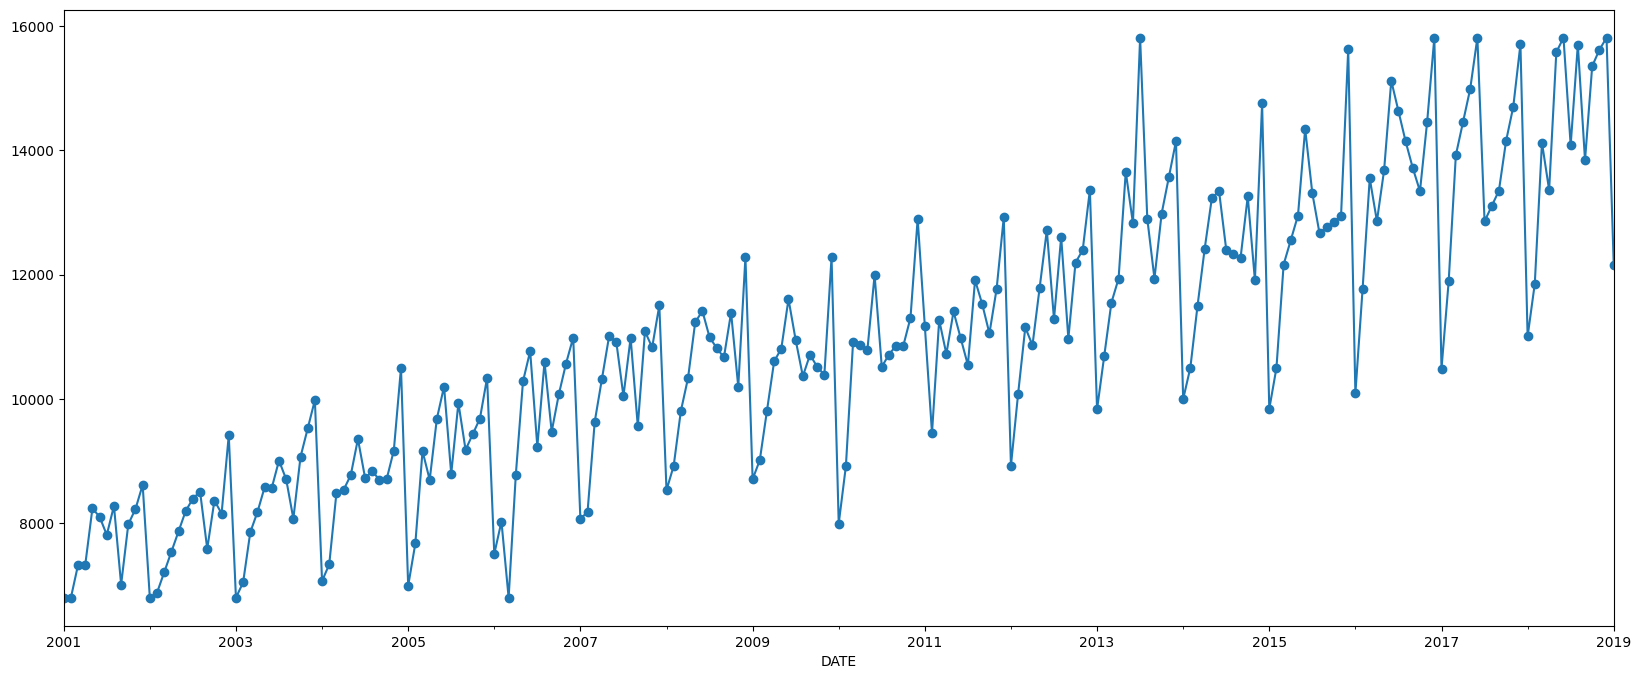

In [ ]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
# set index
mobile_sales.set_index('DATE', inplace=True)
# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')
# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))
# plot
mobile_sales.Sales.plot(style='-o')

Let's also define the function for calculating all the performance metrics.

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In the last lecture, the model that gave the best results was **SARIMA Model**

> **Training the SARIMA**

MAE : 536.809
RMSE : 622.984
MAPE: 0.037


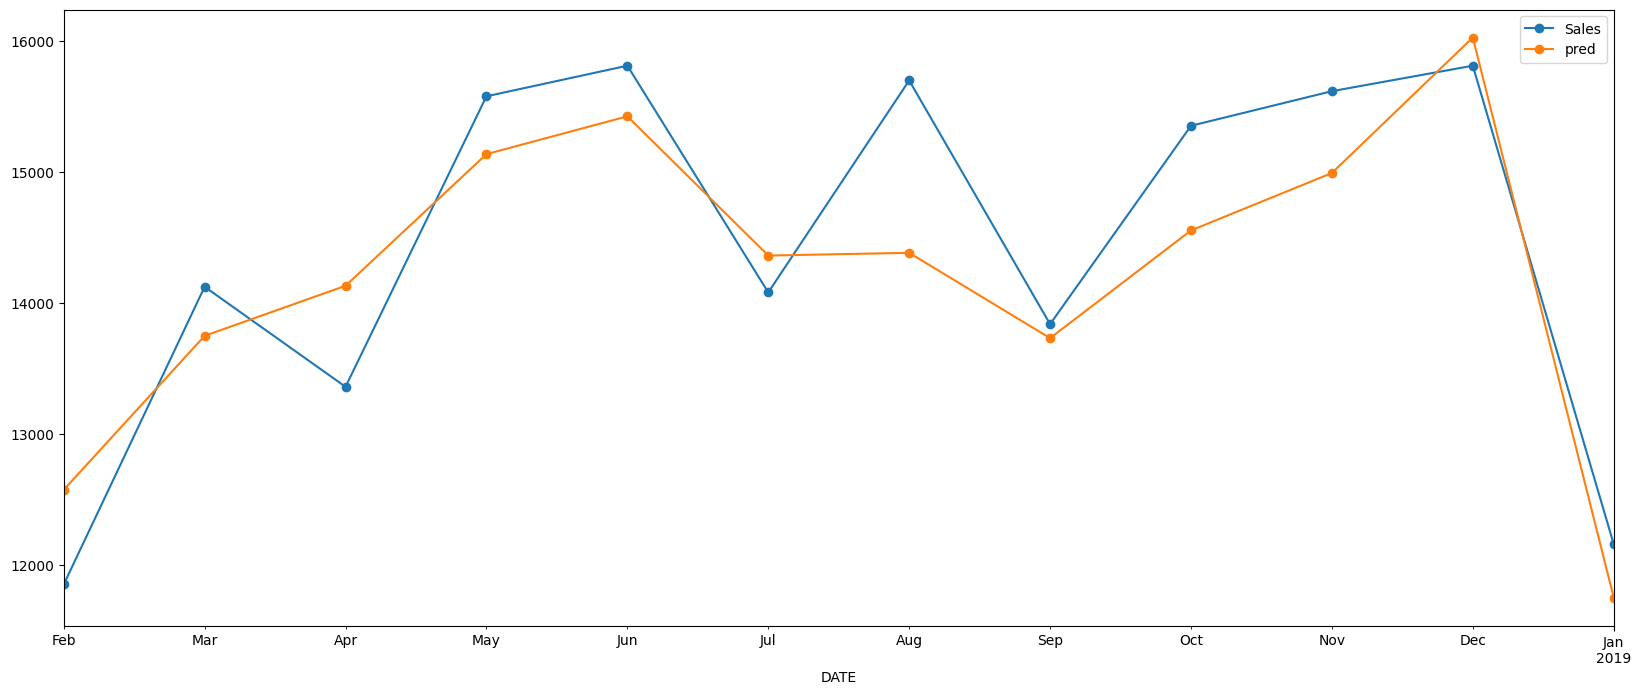

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

There is one more model in the ARIMA family: **SARIMAX** itself!

Before we jump into that, let's cover a few more concepts first, that will help us understand it better.

## Confidence Intervals

####Q. **How to interpret confidence intervals?**

Suppose our forecasted value is $\hat{y}$. And you pass a value of `alpha = 0.05` for which you get the confidence interval as `(m,n)`.

It means that the time series model will estimate the upper(n) and lower(m) bound of values around the forecast, where there is only a 5% chance that the real value will **not be** in that range.

That is, 95% that our forecast will fall within the range `(m,n)`.

Let's use the returned upper and lower bound values of each forecast using the function `conf_int` to create separate series for lower and upper bounds for visualization purpose.

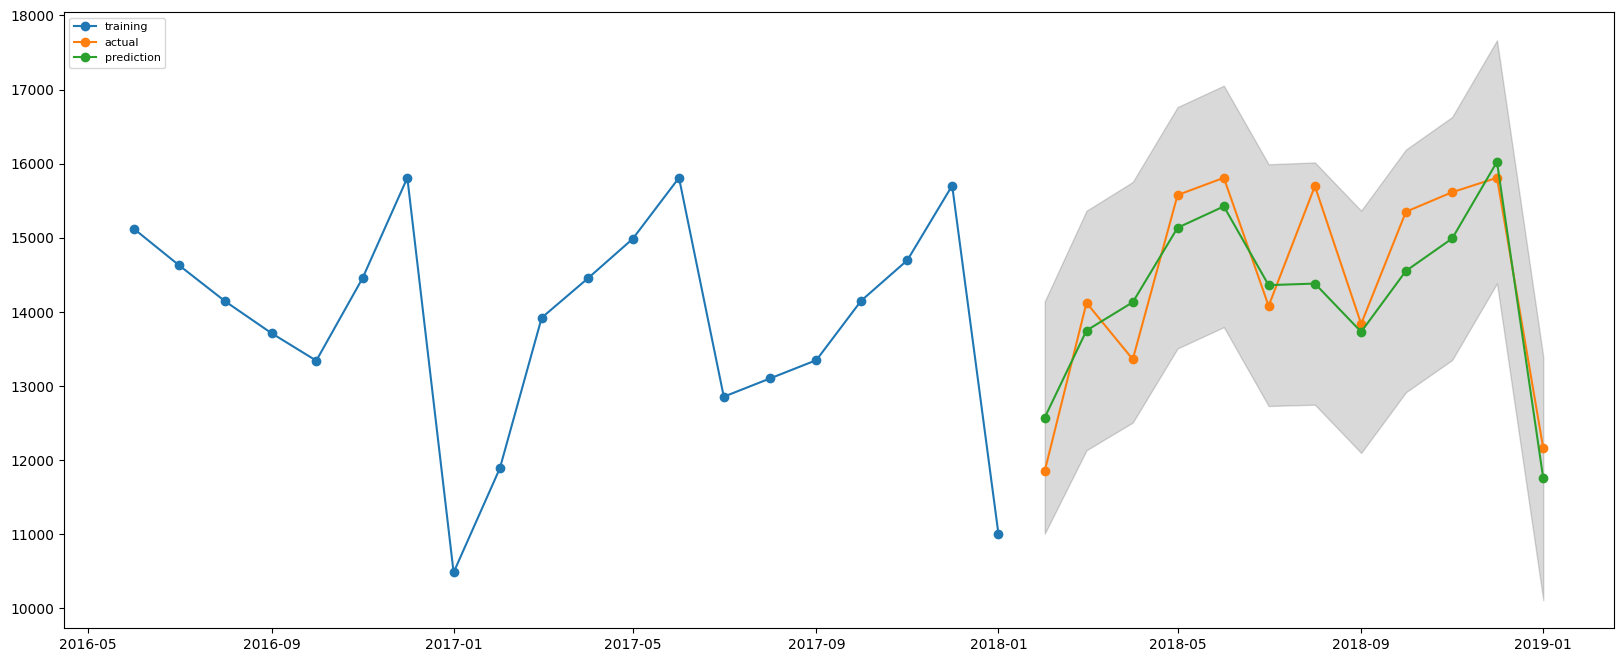

In [ ]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In the above plot, we can observe
- The actual observed values of test set
- Forecasted values of the test set
- Confidence intervals

As shown in the legend of plot, the green and orange lines show the forecasted and actual values respectively.

**Observation**:
- The greyish area around the predictions are actually the values for 95% confidence intervals.
- The actual values are indeed within the predicted confidence intervals

> **Q. What does `conf_int` return?**

- In the code we are first getting the forecast for the 1st step just after the last date of fitted training data.
- Then we are using `conf_int` on the forecast, to get the lower and upper bound values for each forecast.

In [ ]:
a = model.get_forecast(steps=1).conf_int(0.05).values
a

array([[11007.63031249, 14140.89868022]])

## Change Points

In [ ]:
from IPython.display import Image
Image(url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/752/original/illustration_of_change_point_detectopn_via_sliding-window.gif?1658421673')

#### **Q. What are the other factors, based on which one can identify a change point?**

In [ ]:
# No need to explain this
def plot_changepoints(signal, changepoints):
  for cp in changepoints:
    plt.axvline(x=cp, color='#FA8072')
  plt.plot(signal, '-*', label='signal')

  start = 0
  trends = np.array([])
  for i in changepoints:
    x = np.arange(start, i)
    y = signal[start:i]
    l1 = np.polyfit(x, y, deg=1)
    trend = x*l1[0] + l1[1]
    trends = np.append(trends, trend)
    start = i

  plt.plot(trends, label='trend')
  plt.legend()
  plt.show()

We will use the **difference in slope for each window**, and wherever the difference is huge, we will mark that as a changepoint.

- For finding the slope of regression line that goes through all points in a window we can use ```numpy.polyfit``` with 1 degree polynomial.
- You can also use ```sklearn.LinearRegression```, but here polyfit syntax is linear.
-Both will give similar results

<br>

>**INSTRUCTOR NOTES**
- Explain the changepoints computations slowly, while plotting at every step

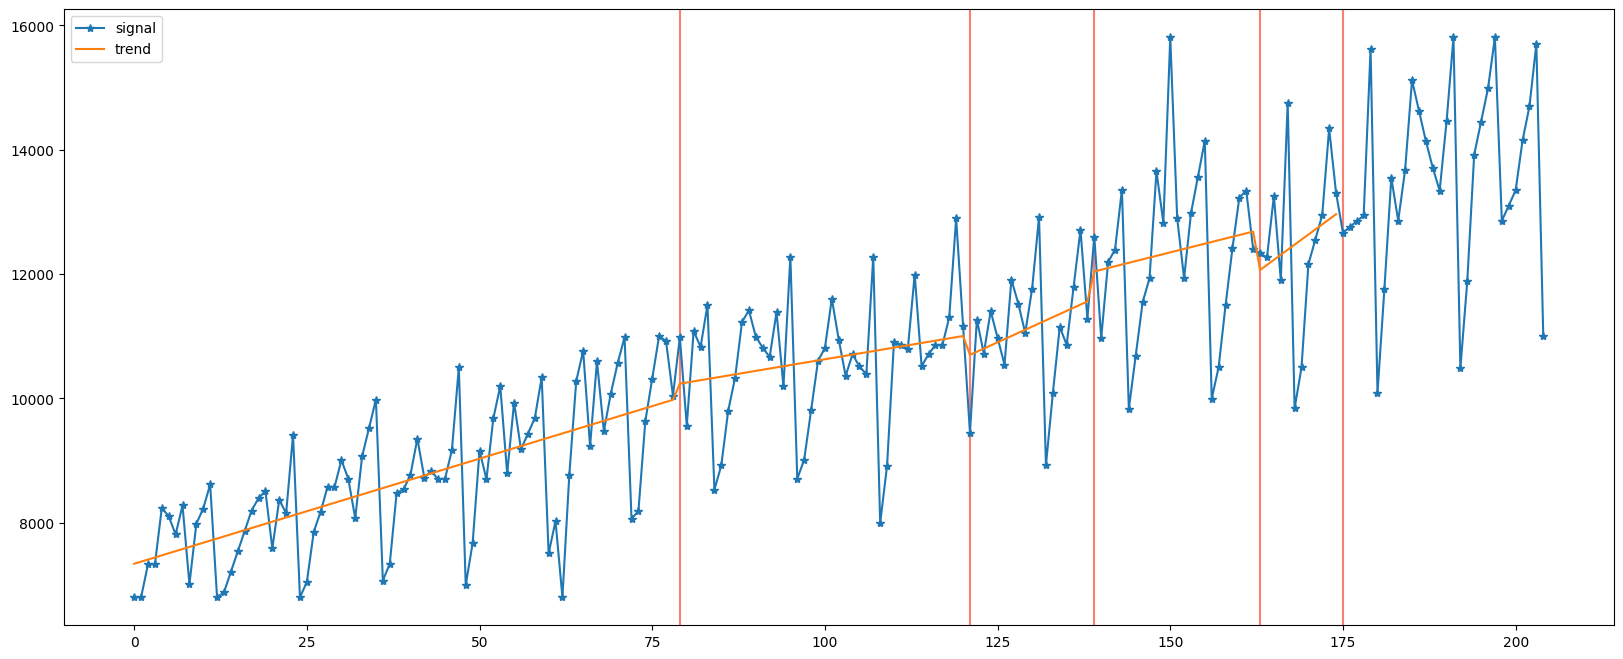

In [ ]:
signal = train_x.Sales # Stationarise for mean as cost function
window=60
def get_slope(y):
  return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 7.5].index
# converting to index from dates
temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()

plot_changepoints(signal.values, changepoints)

- Great, Looks like we did find some valid changepoints.
- However, maybe depending on the domain we may feel that the cps are too frequent, or close to each other.
- Also we need to experiment with the window and threshold etc.

Let us use a library which has much more complex algorithms to better detect changepoints

Quickly trying the first algorithm from a package called 'rupteres'. If you want to try other on your own, you may visit https://github.com/deepcharles/ruptures

> **INSTRUCTOR NOTES**
> - Just skim through this code, the idea is to just show whats possible, not elaborately cover this library.
- All arguments passed are just first guesses.

In [ ]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00


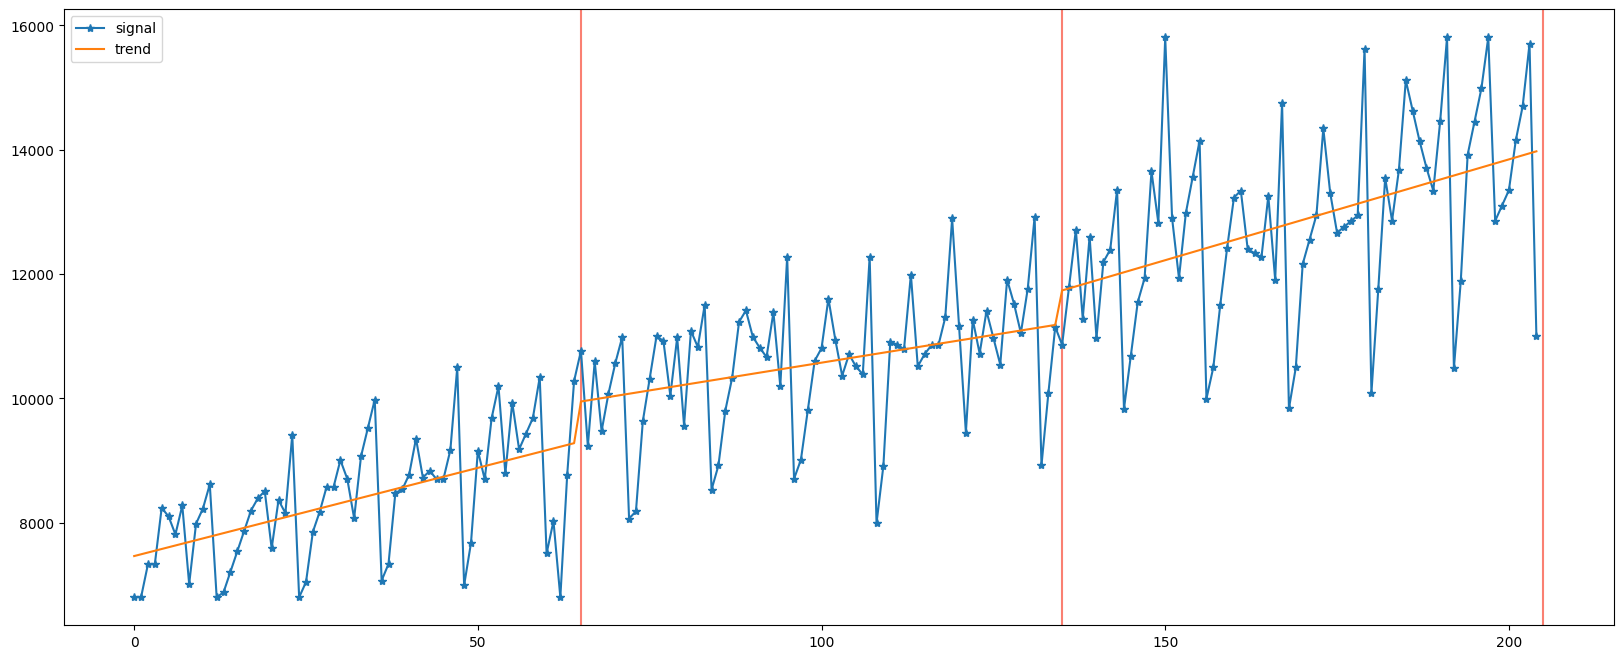

In [ ]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal = train_x.Sales.values
# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
changepoints = algo.predict(pen=5)


plot_changepoints(signal, changepoints)

---


## Imagine you are a Data Scientist at a food chain ‘Xotica’!

Your manager has asked you to forecast the number of visitors for upcoming 39 days (almost 6 weeks) using the number of visitors recorded within the past 1-1.5 years.


Reading the data

In [ ]:
!gdown 1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO

Downloading...
From: https://drive.google.com/uc?id=1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 28.4MB/s]


In [ ]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

date   weekday  holiday  total
0  1/1/2016    Friday        1  296.0
1  1/2/2016  Saturday        0  191.0
2  1/3/2016    Sunday        0  202.0
3  1/4/2016    Monday        0  105.0
4  1/5/2016   Tuesday        0   98.0

In [ ]:
df.shape

(517, 4)


The provided dataset has features `‘Date’, ‘holiday’, 'weekday' and 'total`(total no. of visitors).

The data consists of number of **daily** visitors to the restaurant located in the United States, subject to American holidays.

The data set contains 517 days: 478 days of restaurant's data and 39 days of data which have `Nan` in `total`.

Let's find out the number of rows having values 'Nan' in dataset.

In [ ]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

Here let's keep a copy of the original data so that in future, even after modifications on the data we won't have to read the csv again and again.

In [ ]:
df1 = df.copy()

Let's drop all the rows which have `Nan`.

In [ ]:
df.dropna(inplace = True)

Set the `date` column as index after converting it to datetime format.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

weekday  holiday  total
date                                
2016-01-01    Friday        1  296.0
2016-01-02  Saturday        0  191.0
2016-01-03    Sunday        0  202.0
2016-01-04    Monday        0  105.0
2016-01-05   Tuesday        0   98.0

**NOTE:-**
- Here you can see, that the target variable of the time series is the ```total``` column.
- In our last business case, we saw only date and the target variable.
- However, there are other columns: ```holiday, weekday```.

<br>





#### Plot the source data.

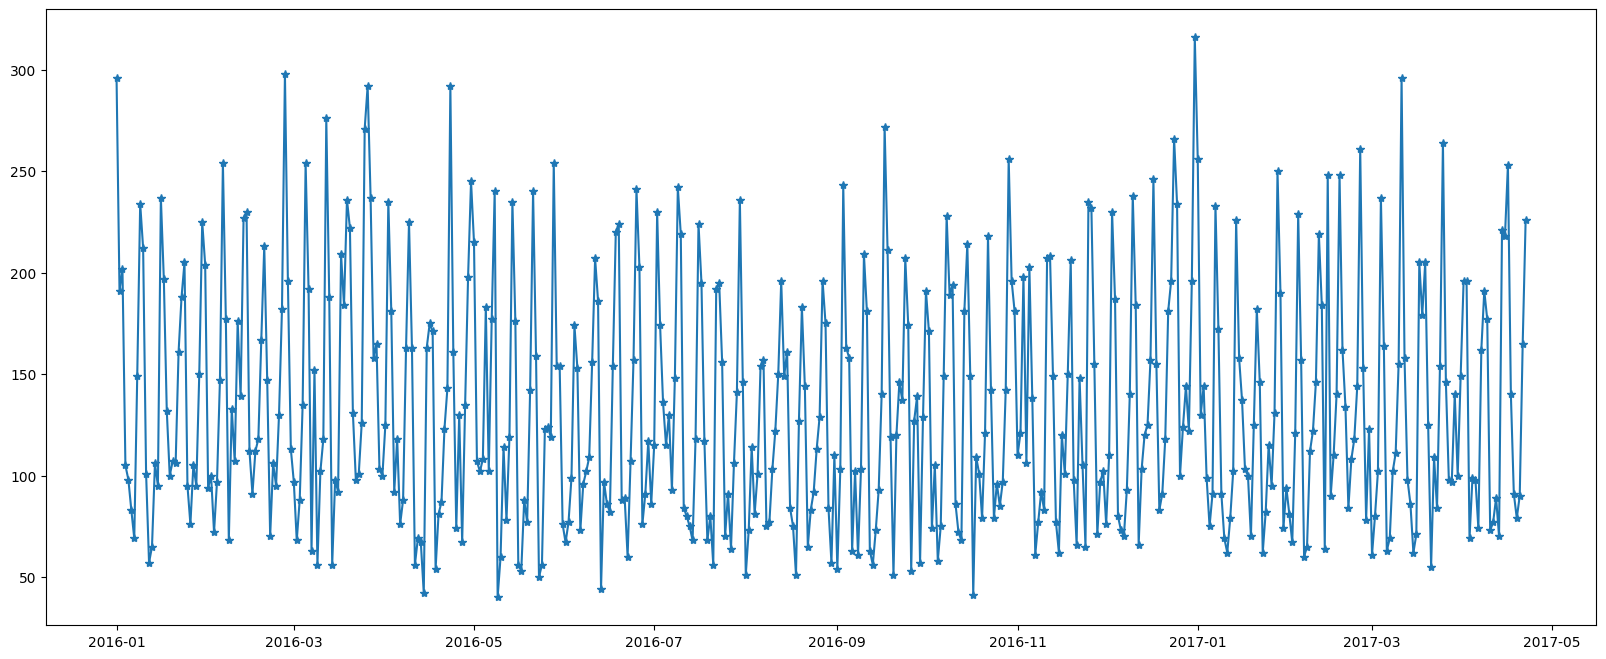

In [ ]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

> **INTERACTION**
> - Can you guess which days of the week can the peaks in the data represent?
> - Ans: weekends

In the above plot, we can see the peaks but we can't map those peaks to any particular days. Therefore let's try to decrease the number of days to plot, so that we get more insights.

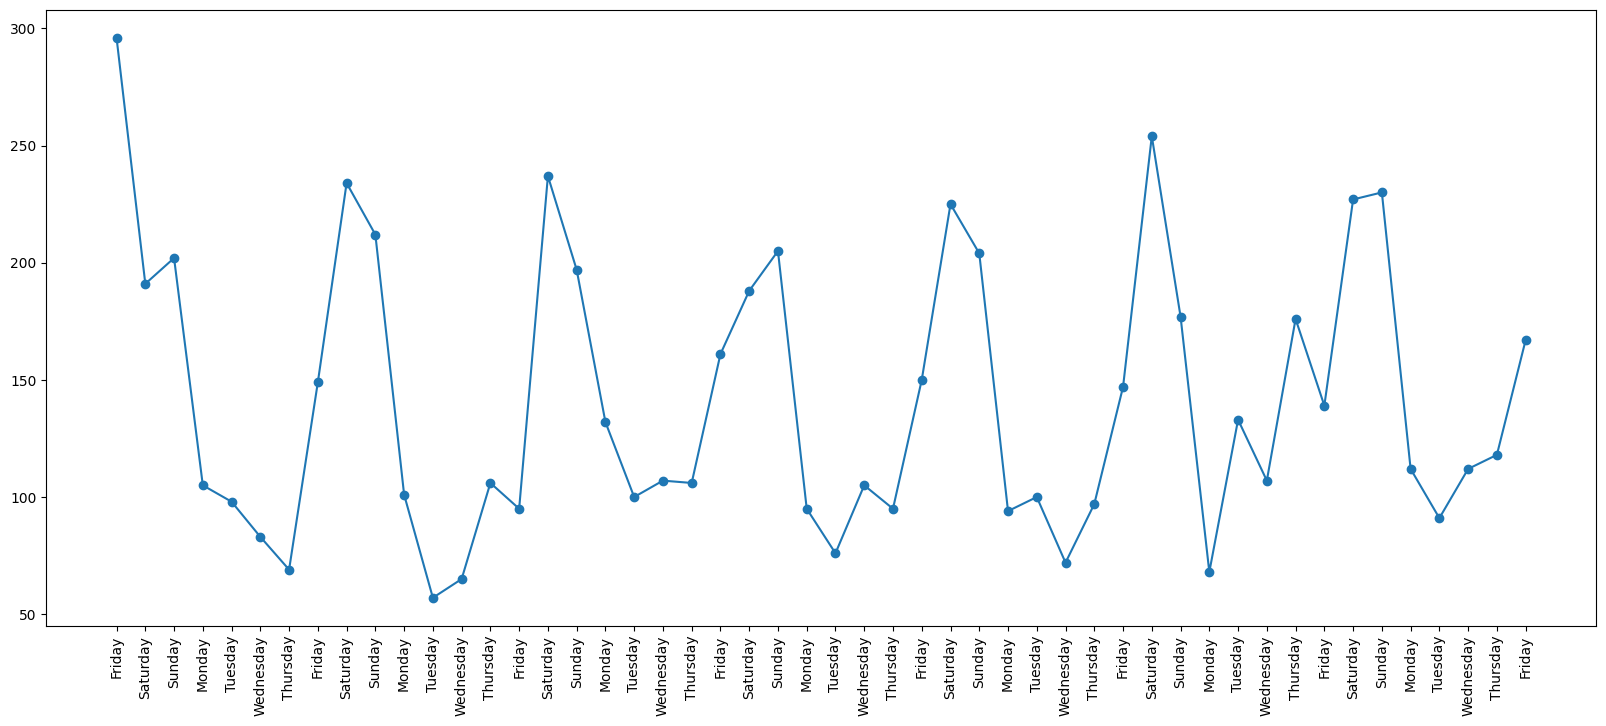

In [ ]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

It is easily observable that the peaks in the number of visitors is around Saturday and Sunday.

#### Plot the data with holidays.

We also have the data about `holidays`, therefore let's visualize it to observe any relationship between holidays and number of people visiting if it exists.

In [ ]:
df['holiday'].value_counts()

0    446
1     32
Name: holiday, dtype: int64

feature `holiday` is representing whether there is holiday (1) on the day or not(0).

Plot of data with `holiday`. Lets use a red line to indicate that the given day is a holiday.

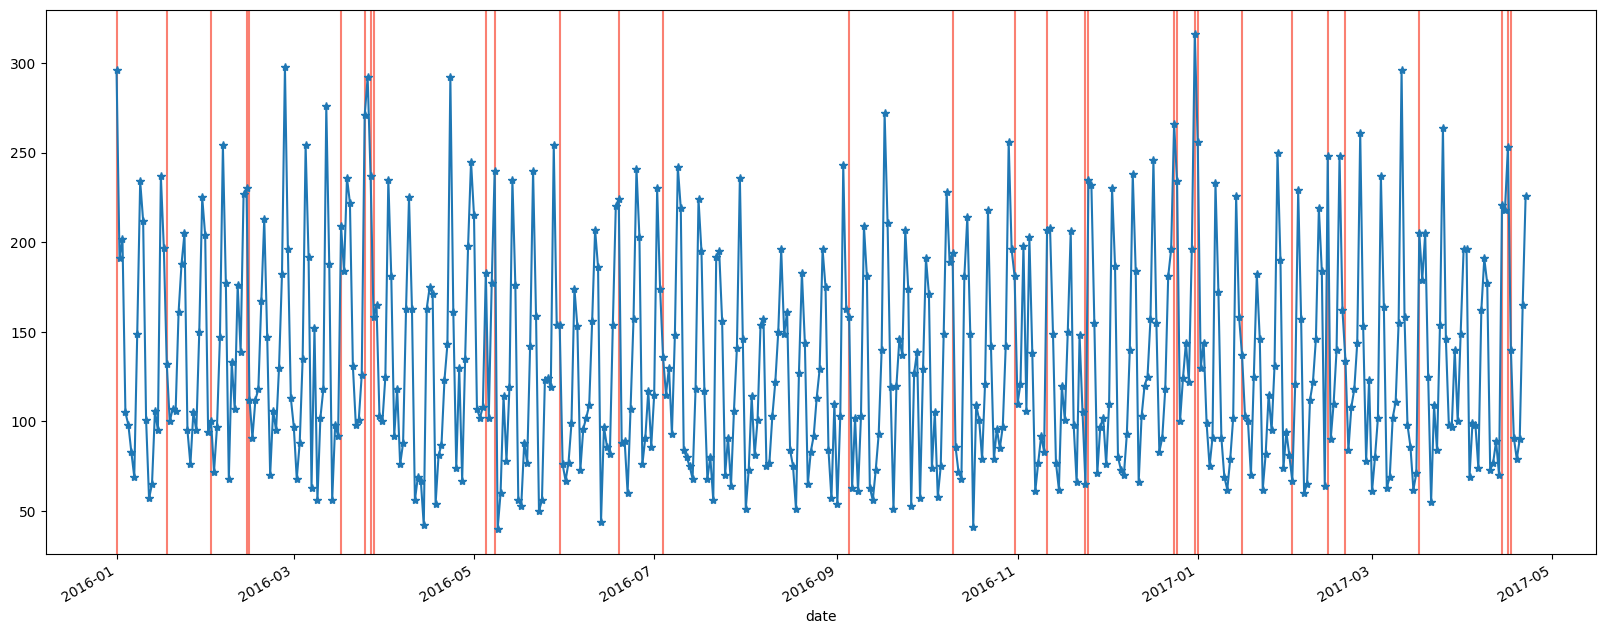

In [ ]:
# Lets take a look at our time series plot
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

**Notice:-**
- We can see that holidays generally see a **peak** in foot falls.

**Now let's try to decompose the time series to see if it follows any pattern**

<Figure size 2000x800 with 0 Axes>

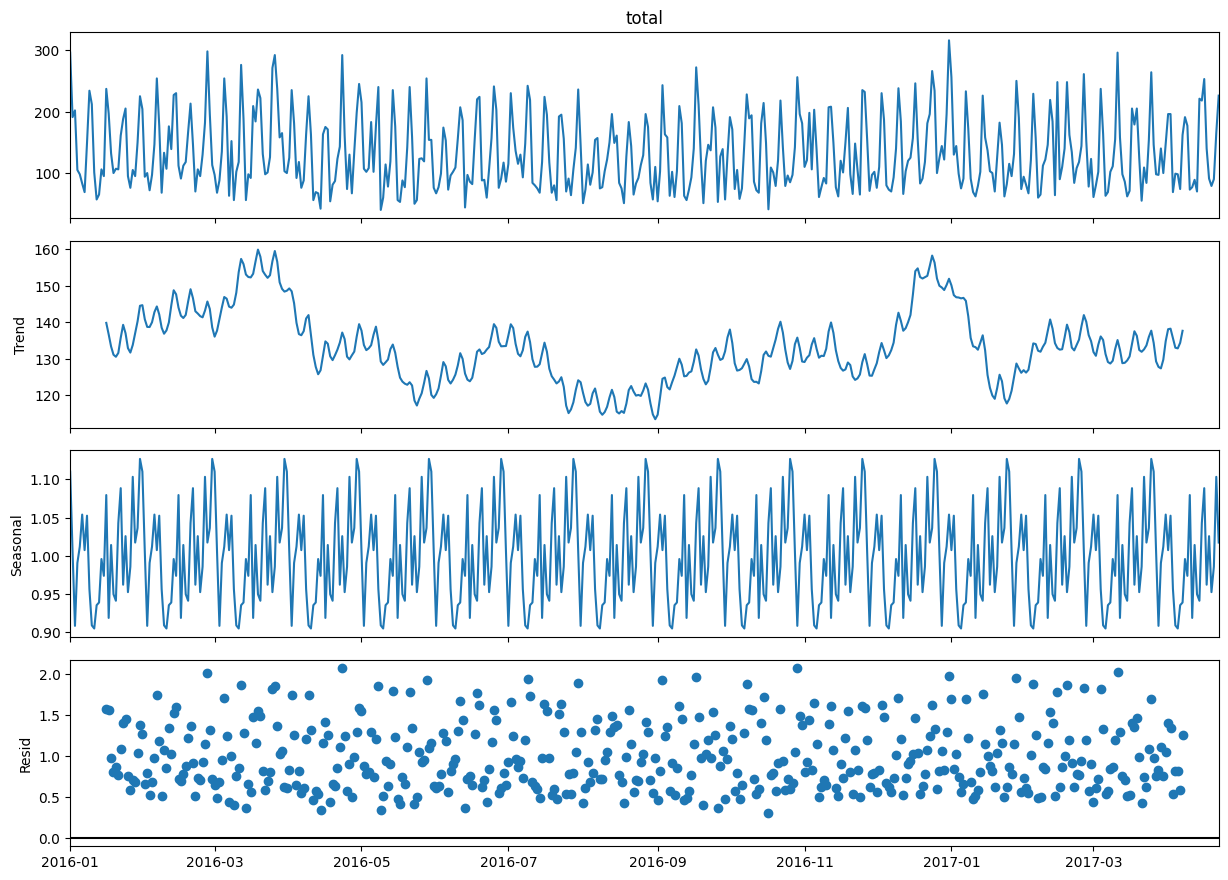

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

* From the above decomposition, it's visible that the data consists of seasonality and the trend is increasing and decreasing which is understandable as the number of visitors will increase during the weekends.

* As their is seasonality, let's try to use SARIMA for the predictions.

In [ ]:
train = df.iloc[:436]
test = df.iloc[436:]

In [ ]:
test.tail()

weekday  holiday  total
date                                 
2017-04-18    Tuesday        0   91.0
2017-04-19  Wednesday        0   79.0
2017-04-20   Thursday        0   90.0
2017-04-21     Friday        0  165.0
2017-04-22   Saturday        0  226.0

Let's train a pure seasonality based model, by ignoring the `p, d, q` hyperparamters

In [ ]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

Let's analyze the residuals after training the model on the SARIMA

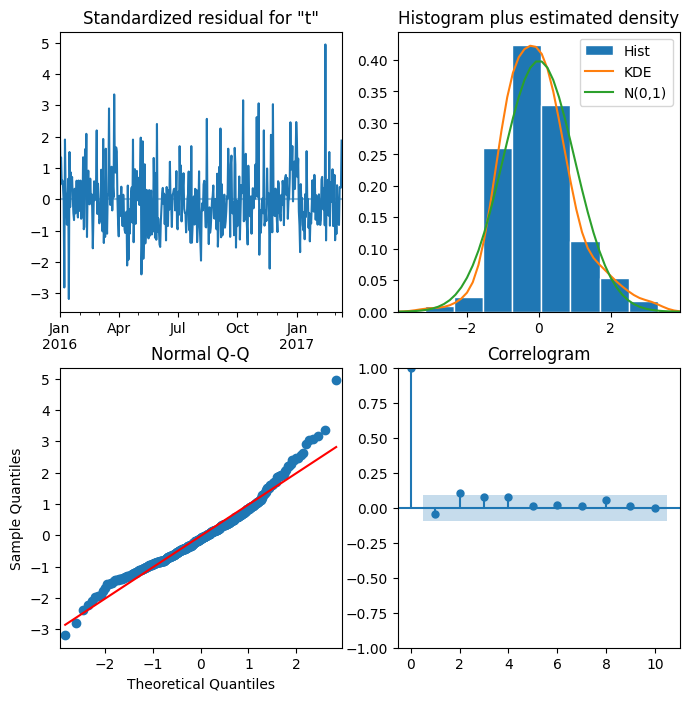

In [ ]:
results.plot_diagnostics(figsize=(8,8));

> **Q. By observing the residual plots, what can we infer about the patterns in the residuals?**

- The residuals have **constant variance**.
- Majority of the dots lie on the red line in the Normal Q-Q plot
 - Hence, the residuals follow a **normal distribution.**
- The residuals are **not auto correlated** as there is no significant pattern.


  

#### Some properties of residuals in time series forecasting
 * The residuals should **not be correlated**
  - Correlated residuals will imply that we are unable to capture some information / pattern in our model.
 * It is useful if the residuals are **normally distributed**
  - It makes calculating the prediction intervals easier.
 * The residuals should have a **zero mean**
  - Otherwise, the forecast can said to be biased.
  - Because a positive mean would mean would imply underfitting and vica-versa

---

## Exogenous Variables

Now let's use the predict() function to get the predictions for the observations in the test data.

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

#### Observing the relation of predicted vs actual values on holidays

Let's plot the predicted forecasts and the actual observed values on the test set, and calculate performance scores.

Also, let's add a red line to indicate the **holidays** in the test set.

**Instructor Note:**
> - No need to run the cell as the plot will be same as the attached image but arrows will not be there.

MAE : 25.159
RMSE : 31.97
MAPE: 0.202


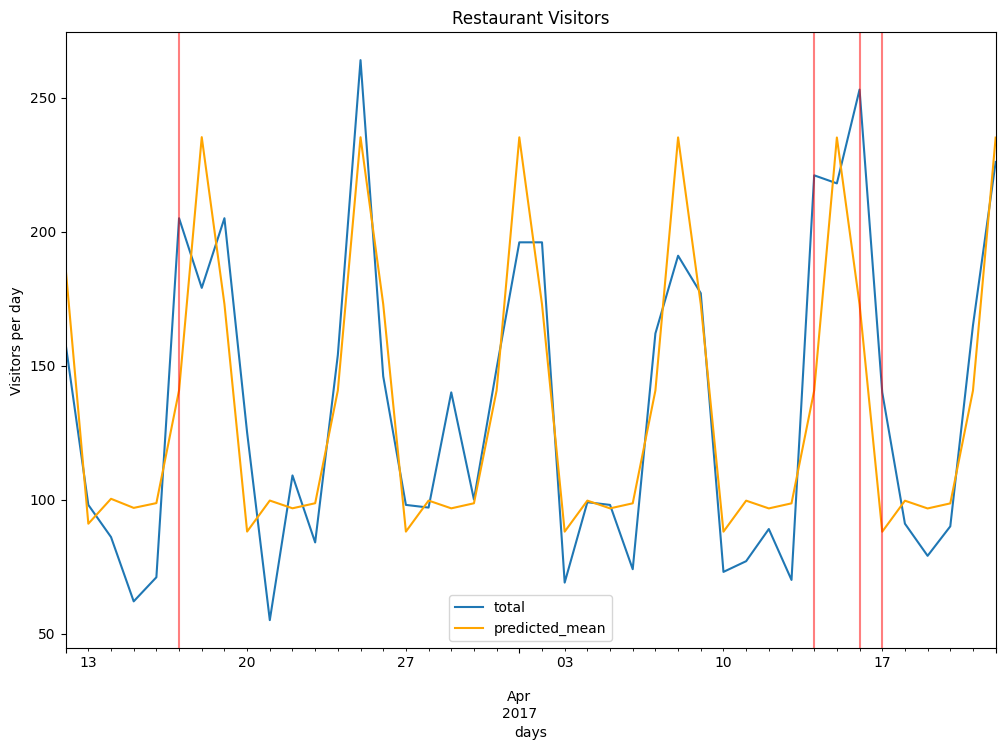

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5)

MAE : 25.159<br>
RMSE : 31.97<br>
MAPE: 0.202<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/768/original/Screenshot_2022-07-22_at_10.41.50_AM.png?1658466294" width="800" height="400">

> **Q. Can you observe any difference between actual and predicted values on the days when there was a holiday?**

 If we look at the plot of total vs predictions, it can be observed that the model has missed peaks for the holidays (see the arrows).

## SARIMAX Model



Now let's fit a SARIMAX model with the exogenous variable 'holiday'.

In [ ]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()

Let's obtain the forecasts with this SARIMAX model trained with exogenous variable.

In [ ]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

#### Let's plot the predicted vs actual forecast values, and observe them closely on holidays.

**Instructor Note:**
> * No need to run the cell as the plot will be the same but arrows will not be there.

MAE : 18.649
RMSE : 22.93
MAPE: 0.161


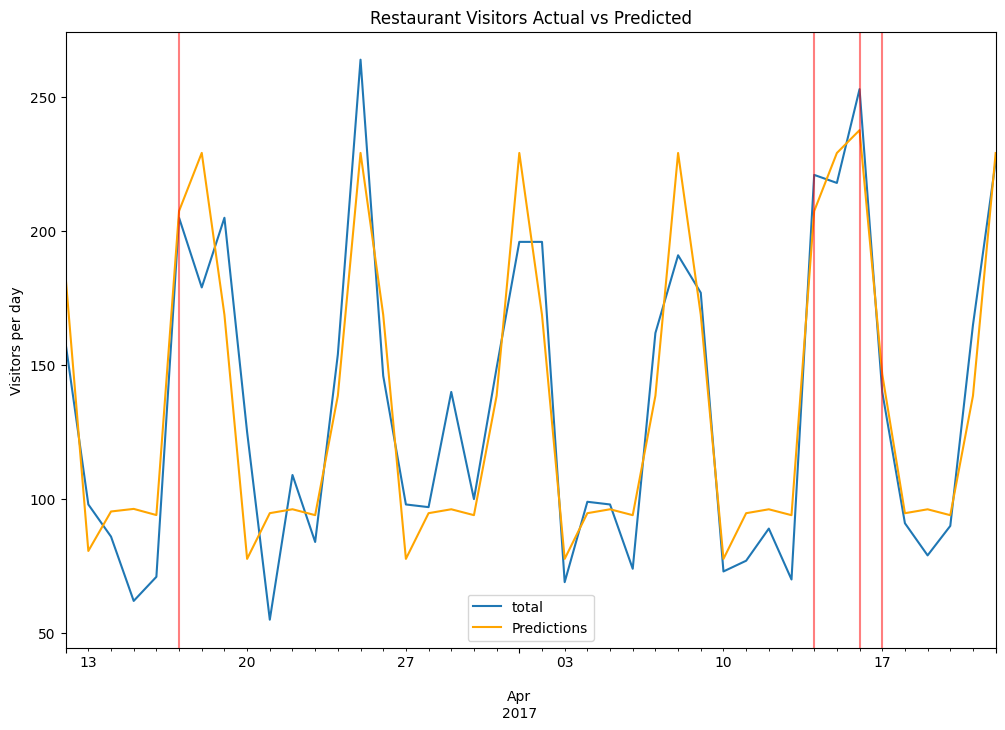

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);

MAE : 18.649<br>
RMSE : 22.93<br>
MAPE: 0.161<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/810/original/Screenshot_2022-07-22_at_9.12.57_PM.png?1658504130" width = 800, height = 400/>

- It can be observed that the predictions now are somewhat more closer to the peaks, for holidays.
 - Observe the arrows.

- Moreover, the peformace has also improved a lot.



####**Forecasting for the 39 newer observations**

We earlier dropped the rows which had Nan in the starting, now let's predict the values of `total` for these 39 observations.

Now we will be using SARIMAX to forecast the number of visitors of the last 39 observations which had null values. We will be using the 'holiday' data.

In [ ]:
model = SARIMAX(df['total'],exog=df['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df1[478:][['holiday']]
fcast = results.predict(478,df1.shape[0]-1,exog = exog_forecast).rename('Forecast')

In the above code snippet we are using `df1` to get the `holiday` data for the rows where the `total` was none and we dropped them.

Here we are just visualizing the last 100 observations of the dataset, for clear visualization.

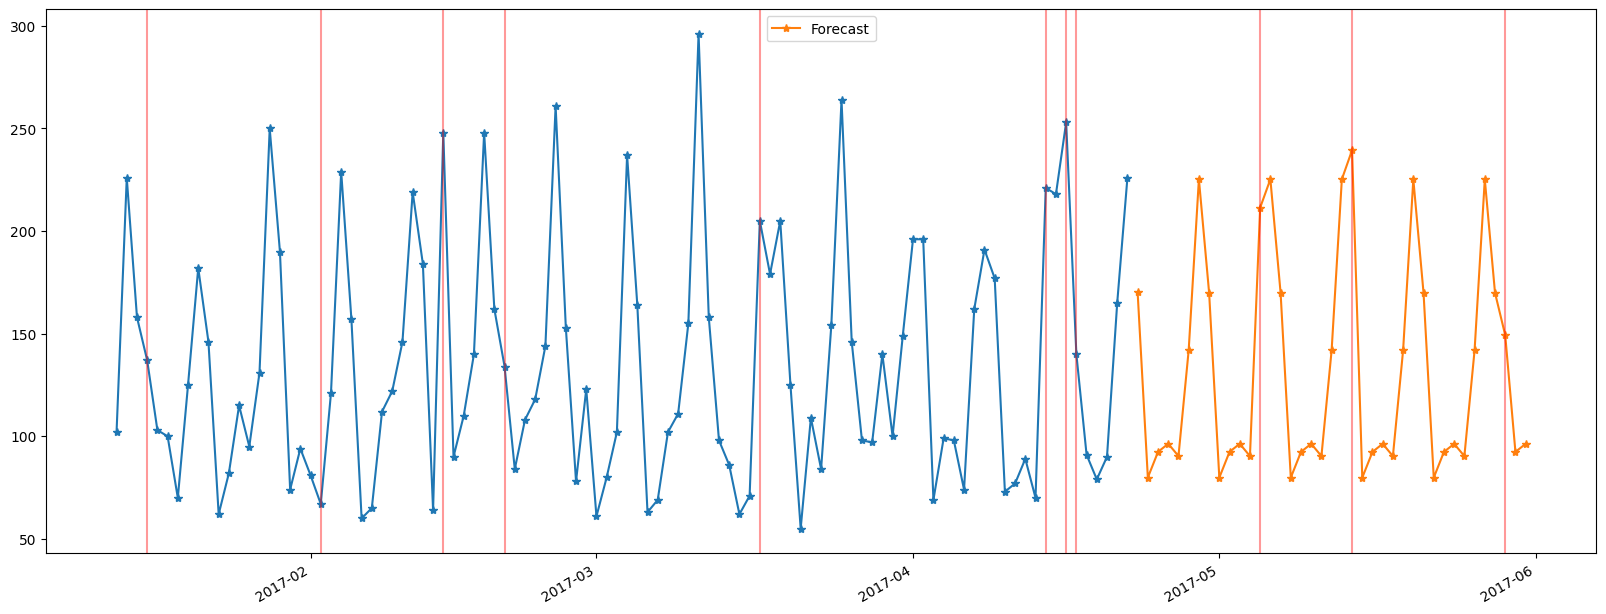

In [ ]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'

# ax = df['total'][-100:].plot(legend=True,figsize=(16,5),title=title, style = '-*')
plt.plot(df[-100:].index, df[-100:].total, '-*')
fcast.plot(legend=True, style = '-*')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df[-100:].query('holiday==1').index:
    plt.axvline(x=x, color='red', alpha = 0.4)

for x in df1[-42:].query('holiday==1').date:
    plt.axvline(x=pd.to_datetime(x), color='red', alpha = 0.4)


Note that as a real forecaster,
- you will have to decide wether the future plot looks correct or not.
- Metrics and other measures aside, it is your responsibility that forecast should be correct.
- Hence forecasting is a game of experience, not just theory and code

## Time Series with Linear Regression

> **INSTRUCOTR NOTES**
> - Go slowly through code, print output at each step

### Can we use a regression for a time series problem?

In the ADF test performed earlier we saw that the data is **stationary**

Therefore let's try to forecast the values using linear regression.


In [ ]:
df = df1.copy()
df['date'] = pd.to_datetime(df['date'])

We have seen in the decomposed plots that the number of visitors alter during weekdays and weekends and there is also some pattern in the trends over the weeks.

> **Q. Keeping the above observations in mind can you think of some new variables that we can derive from the existing values and can use for our predictions?**

Earlier we saw that the number of visitors was higher on the weekends according to the data.

Therefore let's try engineering a new feature which indicates whether there is a weekend or not.

In [ ]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

date      weekday  holiday  total  weekend  working_day
0 2016-01-01  working_day        1  296.0        0            1
1 2016-01-02      weekend        0  191.0        1            0
2 2016-01-03      weekend        0  202.0        1            0
3 2016-01-04  working_day        0  105.0        0            1
4 2016-01-05  working_day        0   98.0        0            1

As we have seen the repetition of patterns over the months therefore let's engineer a feature which consist of the average of the last one month's values.

Now let's calculate the values of past 1-31 days number of visitors for each observation storing in columns with name Lag_i where i is the previous ith day's observation.

In [ ]:
for i in range(1,32):
  df["Lag_{}".format(i)] = df['total'].shift(i)

- We could also have used `resample('M')` in combination with `groupby()` in order to get the average of last 31 days.
- But here we are using `Lag` because we also want to have different `Lag` values.
- Computationally it would make sense to use `resample`, but here we are just going to try different combinations of features.

Let's try to use the average of past one months values for each observation as a feature named `average_monthly_lag`

In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
df.head()

date      weekday  holiday  total  weekend  working_day  Lag_1  \
31 2016-02-01  working_day        0   94.0        0            1  204.0   
32 2016-02-02  working_day        1  100.0        0            1   94.0   
33 2016-02-03  working_day        0   72.0        0            1  100.0   
34 2016-02-04  working_day        0   97.0        0            1   72.0   
35 2016-02-05  working_day        0  147.0        0            1   97.0   

    Lag_2  Lag_3  Lag_4  ...  Lag_23  Lag_24  Lag_25  Lag_26  Lag_27  Lag_28  \
31  225.0  150.0   95.0  ...   234.0   149.0    69.0    83.0    98.0   105.0   
32  204.0  225.0  150.0  ...   212.0   234.0   149.0    69.0    83.0    98.0   
33   94.0  204.0  225.0  ...   101.0   212.0   234.0   149.0    69.0    83.0   
34  100.0   94.0  204.0  ...    57.0   101.0   212.0   234.0   149.0    69.0   
35   72.0  100.0   94.0  ...    65.0    57.0   101.0   212.0   234.0   149.0   

    Lag_29  Lag_30  Lag_31  last_month_avg_level  
31   202.0   191.0   296.0            143.419355  
32   105.0   202.0   191.0            136.903226  
33    98.0   105.0   202.0            133.967742  
34    83.0    98.0   105.0            129.774194  
35    69.0    83.0    98.0            129.516129  

[5 rows x 38 columns]

Similarly let's use a feature 'average_weekly_lag' for an average past 7 days observations.



In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
df.head(3)

date      weekday  holiday  total  weekend  working_day  Lag_1  \
31 2016-02-01  working_day        0   94.0        0            1  204.0   
32 2016-02-02  working_day        1  100.0        0            1   94.0   
33 2016-02-03  working_day        0   72.0        0            1  100.0   

    Lag_2  Lag_3  Lag_4  ...  Lag_24  Lag_25  Lag_26  Lag_27  Lag_28  Lag_29  \
31  225.0  150.0   95.0  ...   149.0    69.0    83.0    98.0   105.0   202.0   
32  204.0  225.0  150.0  ...   234.0   149.0    69.0    83.0    98.0   105.0   
33   94.0  204.0  225.0  ...   212.0   234.0   149.0    69.0    83.0    98.0   

    Lag_30  Lag_31  last_month_avg_level  last_week_avg_level  
31   191.0   296.0            143.419355           135.714286  
32   202.0   191.0            136.903226           135.571429  
33   105.0   202.0            133.967742           139.000000  

[3 rows x 39 columns]

We can have 'average_biweekly_lag' as well.

In [ ]:
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df.head(3)

date      weekday  holiday  total  weekend  working_day  Lag_1  \
31 2016-02-01  working_day        0   94.0        0            1  204.0   
32 2016-02-02  working_day        1  100.0        0            1   94.0   
33 2016-02-03  working_day        0   72.0        0            1  100.0   

    Lag_2  Lag_3  Lag_4  ...  Lag_25  Lag_26  Lag_27  Lag_28  Lag_29  Lag_30  \
31  225.0  150.0   95.0  ...    69.0    83.0    98.0   105.0   202.0   191.0   
32  204.0  225.0  150.0  ...   149.0    69.0    83.0    98.0   105.0   202.0   
33   94.0  204.0  225.0  ...   234.0   149.0    69.0    83.0    98.0   105.0   

    Lag_31  last_month_avg_level  last_week_avg_level  last_2week_avg_level  
31   296.0            143.419355           135.714286            139.214286  
32   191.0            136.903226           135.571429            136.500000  
33   202.0            133.967742           139.000000            136.500000  

[3 rows x 40 columns]

**Now lets capture weekly seasonality**

In [ ]:
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()

sale_wrt_dow  dayofweek
31     89.593750          0
32     94.531250          1
33     94.687500          2
34     99.015625          3
35    147.171875          4
36    229.125000          5
37    178.460317          6

In [ ]:
df.shape

(447, 42)

Let's retrieve the present features and columns in the dataframe to decide which featues we can use in predictions.

In [ ]:
df.columns

Index(['date', 'weekday', 'holiday', 'total', 'weekend', 'working_day',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22',
       'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29',
       'Lag_30', 'Lag_31', 'last_month_avg_level', 'last_week_avg_level',
       'last_2week_avg_level', 'dayofweek', 'sale_wrt_dow'],
      dtype='object')

Let's keep a copy of this version of the dataset so that we could use them later.

In [ ]:
import copy             #dfo has the data with all the columns
dfo = df.copy()

Let's try to use a combination of newly engineered variables with Lag_1 and weekend to train the linear regression model.

Drop all the columns which we don't need to use while predicting the number of visitors in the test data.

In [ ]:
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level',
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']]
df.head()

total  Lag_1  last_month_avg_level  last_week_avg_level  \
31   94.0  204.0            143.419355           135.714286   
32  100.0   94.0            136.903226           135.571429   
33   72.0  100.0            133.967742           139.000000   
34   97.0   72.0            129.774194           134.285714   
35  147.0   97.0            129.516129           134.571429   

    last_2week_avg_level  sale_wrt_dow  holiday  
31            139.214286     89.593750        0  
32            136.500000     94.531250        1  
33            136.500000     94.687500        0  
34            134.000000     99.015625        0  
35            133.357143    147.171875        0

Splitting the dataset into train and test.Preparing X and y for training the model.

In [ ]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]


train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.1550950649148067

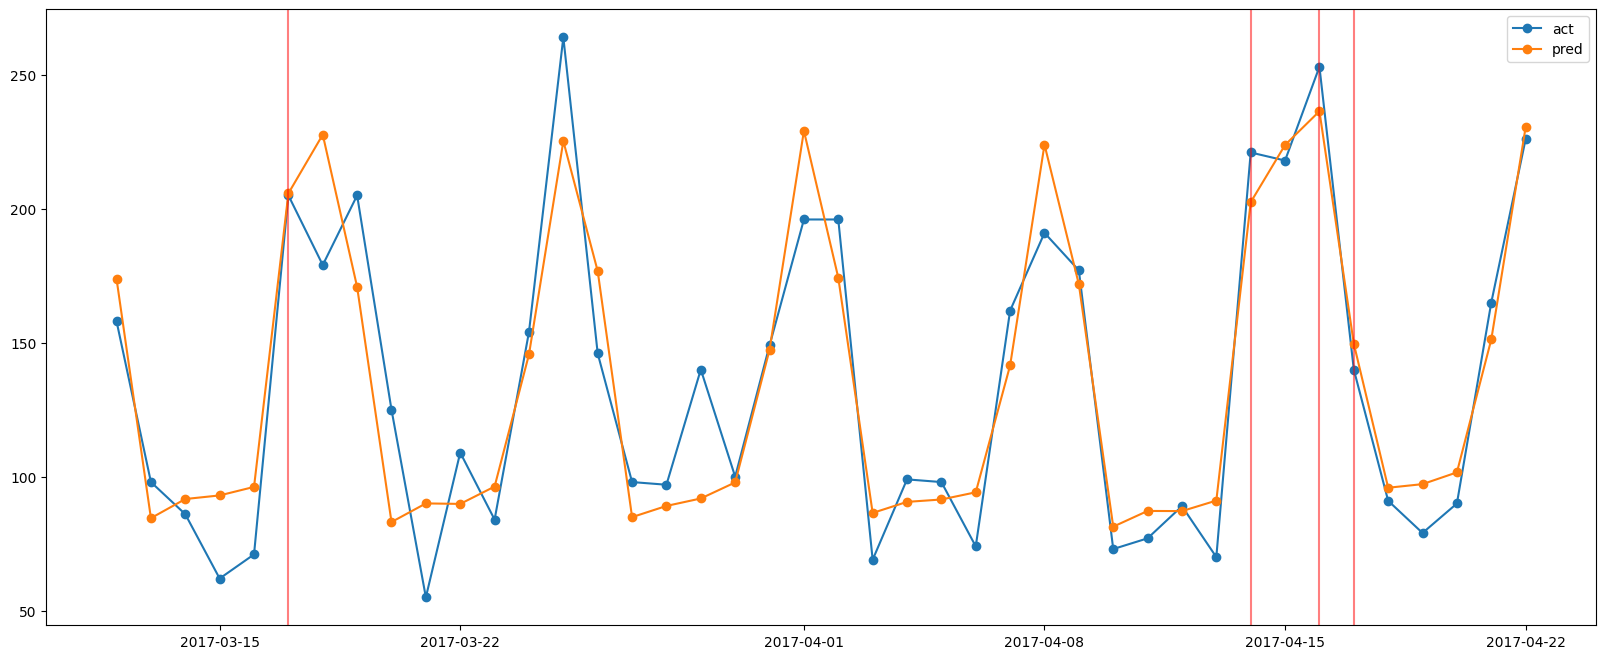

In [ ]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']:
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()

- This performance is surprisingly very good.
- Note that this is a much simpler algorithm than SARIMAX.

Further improvements can be done with

- Thinking of more inovative features.
- Better feature selection
- Different regressors and Hyper parameter tuning
- Stacking / Cascading etc.

> **IMPORTANT NOTE**
> - please note that SARIMAX forecast was 1 - 42 days into the future. This forecast is only 1 day into the future!! Lag_1 has been used as a feature!
> - For multiple days ahead forecast you need a **new LR for each horizon**. Shift your target by -k, where k is horizon-1

## Introduction to Facebook’s Prophet



### Prophet Implementation

* We're using the same dataset .

* For using Prophet, data set should contain only two columns with column names as ‘ds’ and ‘y’

* ‘ds’ should always be in ‘date-time’ format.

In [ ]:
df = df1.copy()

In [ ]:
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       517 non-null    datetime64[ns]
 1   y        478 non-null    float64       
 2   holiday  517 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.2 KB


#### Fitting Prophet

* `make_future_dataframe` creates a placeholder for storing future variables, so we will be predicting future values for 12 periods.

* Firstly, let's try to fit a model without adding seasonality component and holiday effects.

For using `prophet` we need to install `pystan` which is an interface.

**Instructor Note**:
> - This installation will take around 5-6 mins, so better to do it earlier.

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975964 sha256=5a7b091a5d12a27f0a3165b48b0f63eb79680d7f7133cb625e410fdd66955859
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates 

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(df[['ds', 'y']][:-39]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=39,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

ModuleNotFoundError: ignored

* In the plot, black dots are actual visits, deep blue lines are the predicted visits and light blue lines is the 95% confidence interval around the prediction.

- You can see that the lines are flat and the model is not able to capture the seasonality properly so it is not a good fit.
- Here light blue lines are 95% confidence intervals around the predictions.
- Here we also didn't do anything explicitly for `Nan` values it was handled by `prophet`.

Let's see what has the model stored in `forecast` in the above code snippet.


In [ ]:
forecast.tail(4)

There are a lot of added features in the dataframe which include `yhat_lower` and `yhat_upper` for the confidence intervals. `yhat` is the prediction.

Comparing the predictions
- Here we are just plotting the observations and predictions of the dates between `2017-01-01` and `2017-04-22`.

In [ ]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()

- In the plot we can see that the values predicted are flat therefore it's not able to capture the fluctuations properly.

- Here the model is just predicting according to the seasonality it's not taking anything else into account.

- Here the predicted values can be considered as the average seasonality.
  - i.e. The prediction on sunday would be the average of values on past Sundays.

Here we are leaving last 39 observations while calculating the metrics as we don't have actual values of `visitors` for those days.

In [ ]:
performance(df['y'][:-39],forecast['yhat'][:-39])

Now, this time, let's apply seasonality(yearly and weekly), and add holiday effects in our model and fit it in order to get a better model.

This can be done simply by setting `yearly_seasonality` and `weekly_seasonality` as `True`.

####**Q. How can we add exogenous variable to the prophet model?**

We can use `add_regressor` for adding features to the prophet model.

<br>

There is another interesting parameter here: `changepoint_prior_scale`
- If the trend changes are being ovefit (too much flexibility) or underfit (very less flexibility)
- We can adjust the strength of sparse prior using this parameter.
- Default value: 0.05
- Increasing this will make the trend more flexible.

In [ ]:
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

All the metrics have improved from the last model which wasn't using the `holiday` feature.

* We got a Mean absolute percentage error of 18, which might not seem great, but it really depends on the use case.
- The performance has certainly improved in terms of the above mentioned metrics.

In [ ]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.legend()

* We can see the model with added yearly and weekly seasonality and holidays, has a good fit trying to capture most of the data points and patterns.



This time the model didn't give flat outputs.

Even if we don't have the holiday's data, we can use Prophet for getting the holidays data.

In [ ]:
model3=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model3.add_country_holidays(country_name='US') #adding holidays data in the model2
model3.fit(df[:-39])
future = m.make_future_dataframe(periods=39,freq="D")
forecast3 = model3.predict(df)
fig = model3.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast3['yhat'][:-39])

Here the `MAPE` of predictions has gone down to `18.5`
- This is understandable as the `holiday` data given to us would be more exact or subjective to the region which could be more accountable to the fluctuations, than the general holiday data provided by the model.

#### Changing Trends
* Prophet automatically detects the changepoints and will allow the trend to adapt appropriately.

- Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change.

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)

* The vertical lines in this figure indicate where the potential change-points were placed.

* Facebook prophet provides automated methods to forecast.
* The model has easily interpretable parameters that can be changed by the analyst to impose assumptions on the forecast.

> **Q. What makes `Prophet` more usable than the other available methods ?**

- Prophet is a simple library and is great for beginners.
- It works best with time series that have strong seasonal effects.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- We can add multiple regressors or exogenous variables.
- It forms a very good baseline model because almost no feature engineering is required.
- `Interpretability` is one of the key advantages of Prophet.
- If your timeseries follows some business cycles, you can obtain very decent performance quickly.
- It can also be helpful while detecting changepoints.

## Problem Statement

#### Suppose you are a Data Scientsist at a retail store like Walmart/DMart

- The company wants to increase sales and customer satisfaction through their purchase journey
- Your task is to use data to determine the products that are often purchased together:
 - Retailers can optimize product placement
 - Offer special deals and create new product bundles to encourage further sales of these combinations

<br>

#### Q. How to solve this problem?


*   **Transactional data is extremely large** and its very difficult to find patterns to identify which products are purchased together through a manual greedy approach

* Lets have a look at how transactional data looks like


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

In [ ]:
#importing CSV uploaded to drive
id = "1M5IPR96R9efi5cb2n8LxpXIXyx_F0x3v"
print("https://drive.google.com/uc?export=download&id=" + id)
!wget "https://drive.google.com/uc?export=download&id=1M5IPR96R9efi5cb2n8LxpXIXyx_F0x3v" -O Online_Retail.csv

In [ ]:
df = pd.read_csv("Online_Retail.csv")
df.head()

In [ ]:
df.info()

*   This datasets contains 8 features with 541909 rows!

## Data Preprocessing

Lets count the unique invoice numbers (transactions) and unqiue customer IDs

In [ ]:
print('Number of Unique Invoice numbers: {cnt}'.format(cnt=df.InvoiceNo.nunique()))
print('Number of Unique Customer IDs: {cnt}'.format(cnt=df.CustomerID.nunique()))

In [ ]:
df.describe()

> **Q. Why are some values negative under the `Quantity` and `UnitPrice` columns?**

These denote returned or cancelled items.

In order for us to find patterns and analyse the transactional data, we need not consider the items that were returned, we need only look at the items bought by a user in one go.

<br>

Hence, Let's get rid of all rows where quantity is `< 0`.

In [ ]:
df = df[df['Quantity']>=0]
df.info()

Let’s drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [ ]:
df.dropna(axis=0, subset=['InvoiceNo'],inplace=True)
df['InvoiceNo']=df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]
df.shape

Let's explore the column `Country`

In [ ]:
df['Country'].value_counts()

Since most our data is from UK, let's just consider that and drop the rest.

Also, let's convert this data to the form of a **sparse matrix** such that:
* We encode the basket data into a binary data that shows whether an items is bought (1) or not (0)


In [ ]:
data = (df[df['Country'] =="United Kingdom"].groupby(['InvoiceNo', 'Description'])['Quantity']
               .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
data.head(2)

*   For any transaction, if the quantity of an item is >=1 then its encoded as 1 (bought) , else 0 (not bought)


In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

data = data.applymap(encode_units)
data

Since our goal is to find frequently occuring items, let's get rid of all transactions where only one product is bought.

We are going to uncover the association between 2 or more items that is bought according to historical data


In [ ]:
data = data[(data > 0).sum(axis=1) >= 2]
data

According to the result above, we could see that there are 16,539 transaction that bought more than 1 items. It means, 91 % of the basket data is a transaction that has bought more than 1 item


## Apriori Algorithm

> **Q. How to implement Apriori Algorithm in code?**

We have a built-in function that implements apriori for us, under `mlxtend.frequent_patterns` library.

- As we discussed, we need to specify a minimum support threshold value, as parameter of this function.

- Since our column names represent the items, we use `use_colnames=True`

This will give us the most frequent item-sets, so let's sort them in desending order also, using `sort_values()`

Also, for easy interpretation, let's explicitly add a column stating the length of the itemset.

In [ ]:
from mlxtend.frequent_patterns import apriori

In [ ]:
frequent_itemsets_plus = apriori(data, min_support=0.03,
                                 use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)

frequent_itemsets_plus['length'] = frequent_itemsets_plus['itemsets'].apply(lambda x: len(x))

frequent_itemsets_plus

We get 177 most frequently occuring item-sets, using Apriori Algorithm!


*   Using apriori algorithm, we filter frequent itemsets by giving minimum support value of 3%
*   Length is the number of items in the itemset
* Based on the support threshold of 3%, there are 177 itemsets that are considered as frequently bought
* Eg: White hanging Heart T-Light Holder is the most frequently bought items with the support value of 0.129875. i.e the item is bought 2148 times out of the whole transaction


---

## Association Rule

Consider that you are at Domino's,
- It is more likely for a customer to buy combination of **pizza + coke**
- than a combination of **pizza + garlic bread**

Though, both these associations rules hold true:-
- $\left\{ pizza → coke \right \}$
- $\left\{ pizza → garlic \ bread \right \}$

We know that one of them is more strongly associated than the other.

<br>

### Q. Are there any metrics to know how strongly two itemsets are associated?

Yes, there are a couple of different metrics that give us a better idea about associations. These are:-
- Support
- Confidence
- Lift
- Leverage
- Conviction

Lets take a look at them one by one.

**Note:**
- A rule may show a strong correlation in a data set because it appears very often but may occur far less when applied (i.e checked against the antecedent).
 - This would be a **case of high support, but low confidence**.

- Conversely, a rule might not particularly stand out in a data set, but continued analysis shows that it occurs very frequently.
 - This would be a **case of high confidence and low support**.

#### Lift

Consider the combination: {Cornflakes} → {Milk}
- This should be a high confidence rule.

<br>

> **Q. What about {Yogurt} → {Milk}?**

High again.

<br>

> **Q. What about {Toothbrush} → {Milk}?**

Not so sure?
- Confidence for this rule will also be **high** since {Milk} is such a frequent itemset and would be present in every other transaction.

- It does not matter what you have in the antecedent for such a frequent consequent.
- The confidence for an association rule having a very frequent consequent will always be high

Analyse this:
<ul>
<li>Total transactions = 100
<li> 80 of them have milk
<li> 14 of them have toothbrush
<li> 10 of them have both milk and toothbrush
</ul>

Confidence for {Toothbrush} → {Milk} will be 10/14 = 0.7

Looks like a high confidence value. But we know intuitively that these two products have a weak association and there is something misleading about this high confidence value.

<br>

> **Q. How can we overcome this problem?**

Since, Considering just the value of confidence limits our capability to make any business inference.

**Lift** is introduced to overcome this challenge.





> **Q. What is lift?**

Let’s run another mini analytics.
Suppose an X store’s retail transactions database includes the following data:
<ul><li>
Total number of transactions: 600,000
<li>Transactions containing Bread: 7,500 (1.25 percent)
<li>Transactions containing Milk: 60,000 (10 percent)
<li>Transactions containing both Bread and Milk: 6,000 (1.0 percent)
</ul>

From the above figures, we can conclude that
- if there was no relation between Bread and Milk (that is, they were statistically independent),
 - then we would have got only 10% of Bread purchasers to buy Milk too.

- However, as surprising as it may seem, the figures tell us that 80% (=6000/7500) of the people who buy Bread also buy Milk.

This is a significant jump of 8x over what was the expected probability.

This **factor of increase is known as Lift** – which is the ratio of the observed frequency of co-occurrence of our items and the expected frequency.

Based on the low percentages we are seeing here (1.25%, 10%, 1%), we would have expected a low lift%.  

However, the fact that about 80% of Bread purchases include the purchase of Milk indicates a link between Bread and Milk.

TODO: Scribble 1

Now if we analyse the two itemset pair where both had high confidence :

$Lift\left\{Bread -> Milk\right\} = \frac{Confidence \left\{Bread -> Milk\right\}}{ Support(Milk)}$
$ = \frac{6000/7500}{60,000/600,000} = 80$

<br>

Similarly, we get

$ Lift \left\{Toothbrush → Milk \right\} = \frac{Confidence \left\{Toothpaste -> Milk\right\}}{ Support(Milk)} = \frac{0.7}{0.8} = 0.87$

<br>
A value of lift less than 1 shows that having toothbrush on the cart does not increase the chances of occurrence of milk on the cart in spite of the rule showing a high confidence value




#### Leverage

There is another metric called **leverage** that is constructed using support. This is very similar to lift.

<br>

> **Q. How is leverage calculated?**

To compute the leverage of "if X then Y" i.e. $X->Y$, we compute the support of $X and Y$, and subtract the product of support of X, and support of Y from it.

$leverage(X->Y) = support(X \cap Y) - (support(X)*support(Y))$

<br>

> **Q. What is the advantage of using leverage over lift values**

- Though it is similar to lift, but leverage is **easier to interpret**.
- Leverage value lies in the range of **-1 to +1**, whereas lift value ranges from 0 to infinity.

#### Conviction

> **Q. How can we calculate conviction value?**

It can be calculated as the ratio of the expected frequency that X occurs without Y if X and Y were independent divided by the observed frequency of incorrect predictions.

$Conv (X → Y) = \frac{1 - S(Y)}{1 - C(X → Y)}$

<br>

> **Note**

A high value means that the consequent depends strongly on the antecedent.


Now that we've looked at assocation rules, and it's metrics, let's implement it in code.

<br>

> **Q. How to implement this in code?**


- After applying the apriori algorithm and finding the frequently bought item, we apply the association rules.
- From association rules, we could extract information about which items are more effective to be sold together

We have a built-in function for this as well in the same library: `mlxtend.frequent_patterns`.

**Note:**
- We pass the frequent item sets we got from apriori algo as the parameter here.

In [ ]:
from mlxtend.frequent_patterns import association_rules

In [ ]:
association_rules=association_rules(frequent_itemsets_plus, metric='lift',
                  min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)
association_rules.head(5)